Environment versions:
Keras 2.12.0
Matplotlib 3.7.1
Numpy 1.23.5
Pandas 1.5.3
Python 3.11.3
Seaborn 0.12.2
Sklearn 1.2.2
Tensorflow 2.12.0

Colours for plots chosen based on: Choosing Colormaps in Matplotlib — Matplotlib 3.8.1 documentation - colour guide https://matplotlib.org/stable/users/explain/colors/colormaps.html.

Used 'viridis' colour-blind friendly palette for visualisation plots.

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from tensorflow import keras
from tensorflow.keras.utils import image_dataset_from_directory, to_categorical, plot_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, AveragePooling2D, BatchNormalization
from keras.optimizers import Adam
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
from keras.regularizers import l1, l2
from keras.callbacks import EarlyStopping
#from pydotplus import graphviz

Objective-

Develop a CNN model that will identify the species of a flower from a photograph.

*Uploading image data* 

Reference:

Tensorflow (2023) tf.keras.utils.image_dataset_from_directory. Available online: https://www.tensorflow.org/api_docs/python/tf/keras/utils/image_dataset_from_directory [Accessed 16/12/2023].

Ensure that the same train-test split of the images can be re-used to ensure consistent model training going forward.

In [2]:
#Check if train-test split files exist
split_files_exist = True
try:
    np.load("train_test_split.npz")
except FileNotFoundError:
    split_files_exist = False

#Define train_ds and test_ds outside of the conditional block
train_ds = None
test_ds = None
#If the train-test split file already exists then upload, else create new train test split
if split_files_exist:
    #Load train-test split from compressed and saved Numpy array (ensures the same train test split)
    split_data = np.load("train_test_split.npz")
    x_train = split_data["x_train"]
    y_train = split_data["y_train"]
    x_test = split_data["x_test"]
    y_test = split_data["y_test"]

    #Set class_names based on the unique values in y_train
    class_names = np.unique(y_train).astype(str)
else:
    #Split into train and test sets
    train_ds = image_dataset_from_directory(data_dir,
                                             validation_split=0.1,
                                             subset="training",
                                             seed=42,
                                             batch_size=None)

    test_ds = image_dataset_from_directory(data_dir,
                                            validation_split=0.1,
                                            subset="validation",
                                            seed=42,
                                            batch_size=None)

    #Iterate through the train set to extract image data and class labels
    x_train = []
    y_train = []

    for x, y in train_ds:
        x_train.append(np.uint8(x.numpy()))
        y_train.append(y.numpy())

    #Convert train arrays into numpy arrays
    x_train = np.array(x_train)
    y_train = np.array(y_train)

    #Repeat for the test set
    x_test = []
    y_test = []

    for x, y in test_ds:
        x_test.append(np.uint8(x.numpy()))
        y_test.append(y.numpy())
        
    #Convert test arrays into numpy arrays
    x_test = np.array(x_test)
    y_test = np.array(y_test)

    #Save train-test split to files using compressed numpy array
    np.savez_compressed("train_test_split.npz", x_train=x_train, y_train=y_train, x_test=x_test, y_test=y_test)

    #Obtain names of class labels
    class_names = train_ds.class_names if train_ds is not None else test_ds.class_names
    print("Class Names:", class_names)

#Print the size and shape of the arrays
print("x_train shape:", x_train.shape)
print("y_train shape:", y_train.shape)
print("x_test shape:", x_test.shape)
print("y_test shape:", y_test.shape)

x_train shape: (3289, 256, 256, 3)
y_train shape: (3289,)
x_test shape: (365, 256, 256, 3)
y_test shape: (365,)


The first number gives how many images are contained in the array. The second and third number gives the width and height of each image in pixels. Number 3 indicates a RGB colour image corresponding to red, green and blue.

(-0.5, 255.5, 255.5, -0.5)

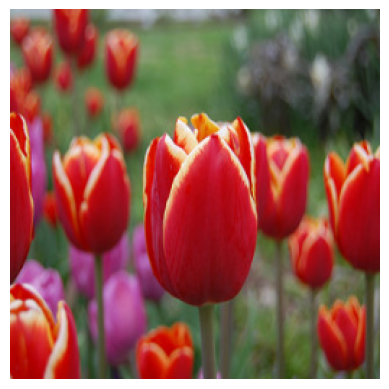

In [3]:
#Plot the first image in the training set
plt.imshow(x_train[0])
#Turn the axis off
plt.gca().axis("off")

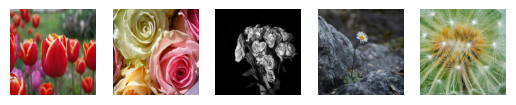

In [4]:
#Print first five images
for i in range(5):
    plt.subplot(1, 5, i + 1)  #Create a subplot for each image
    plt.imshow(x_train[i]) 
    plt.gca().axis('off') 

plt.show()

In [5]:
print("Type of class_names elements:", type(class_names[0]))
print(f"Class Names Array: {class_names}")

Type of class_names elements: <class 'numpy.str_'>
Class Names Array: ['0' '1' '2' '3' '4']


In [6]:
#Print both numerical and string class labels for the first five images
print("Numerical and String Class Labels for the First 5 Images:")
for i in range(5):
    numerical_label = y_train[i]
    string_label = class_names[numerical_label].item() 
    print(f"Image {i + 1}: Numerical Label = {numerical_label}")

Numerical and String Class Labels for the First 5 Images:
Image 1: Numerical Label = 4
Image 2: Numerical Label = 2
Image 3: Numerical Label = 2
Image 4: Numerical Label = 0
Image 5: Numerical Label = 1


In [7]:
#Convert the y_train and y_test arrays to use One Hot Encoding
#from tensorflow.keras.utils import to_categorical
y_train_cat = keras.utils.to_categorical(y_train) 
y_test_cat = keras.utils.to_categorical(y_test)

*Normalise*

Normalise input arrays so pixel values between 0 and 1. Divide arrays by maximum pixels.

In [8]:
print(f'Minimum pixel: {min(x_train.flatten())}') #print min pixel
print(f'Maximum pixel: {max(x_train.flatten())}') #print max pixel
print(f'Data type: {x_train.dtype}') #print dtype- comes out as unsigned integer hence need to convert to float
#No negative values to be considered when choosing activation function for CNN model

Minimum pixel: 0
Maximum pixel: 255
Data type: uint8


In [9]:
#Divide x_train and x_test by max number of pixels in arrays
x_train = x_train.astype('float32')/255
x_test = x_test.astype('float32')/255

*Data Transformation*

Form of regularisation for CNN models to improve generalisation and enhance performance on unseen data.

Data augmentation generates new training samples by applying random transformations to existing data.

Reference for Keras ImageDataGenerator:

Tensorflow (2023) tf.keras.preprocessing.image.ImageDataGenerator. Available online: https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator [Accessed 16/12/2023].

Use this to generate batches of image data with the following transformations: 

• Rotations with a range of 20 degrees. 

• Horizontal and vertical shifts with a range of 10% of the image width and height, 
respectively. 

• Horizontal flips. 

• Shear and zoom with a range of 10% each. 

Text(0.5, 0, 'Augmented image')

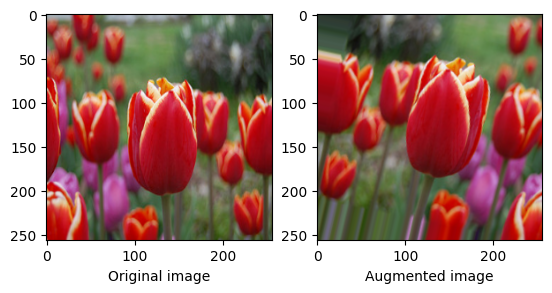

In [28]:
#Use the ImageDataGenerator from Keras to perform data augmentation
#from tensorflow.keras.preprocessing.image import ImageDataGenerator
#Split training set into 20% validation set
train_datagen = ImageDataGenerator(rotation_range=20,
width_shift_range=0.1,
height_shift_range=0.1,
horizontal_flip=True,
vertical_flip=False,
shear_range=0.10,
zoom_range=0.10,
validation_split=0.2)

#Fit the transformation to the normalised images from the training dataset
train_datagen.fit(x_train)

#Make an image of a random transformation of the first image in the training dataset
new_image = train_datagen.random_transform(x_train[0])
fig,ax = plt.subplots(nrows=1, ncols=2)
ax[0].imshow(x_train[0])
ax[1].imshow(new_image)
ax[0].set_xlabel('Original image')
ax[1].set_xlabel('Augmented image')

*Objectives-*

1. Describe the architecture of the CNN model that you used (for example, the number and types of layers that you used, the activation functions that you used etc), and discuss your justifications for the choices that you made.

2. Describe the regularisation methods that you used in your CNN model. How do they affect the accuracy of your results?

3. Discuss any other hyperparameter tuning that you undertook to optimise your model. Which hyperparameters have the strongest effect on the performance of your model? Use suitable figures to visualise the accuracy and performance of your final model.

4. Was there any evidence of overfitting in any of your models? Justify your answer with suitable figures.

In [11]:
#Define width and height, inputted from shape of x_train and x_test above
width_npix = 256
height_npix = 256
num_classes = 5

*Build and compile CNN model*

Tensorflow (2023) tf.keras.Model. Available online: https://www.tensorflow.org/api_docs/python/tf/keras/Model [Accessed 16/12/2023].

Tensorflow (2023) tf.keras.Sequential. Available online: https://www.tensorflow.org/api_docs/python/tf/keras/Sequential [Accessed 16/12/2023].

Tensorflow (2023) tf.keras.layers.Conv2D. Available online: https://www.tensorflow.org/api_docs/python/tf/keras/layers/Conv2D [Accessed 16/12/2023].

Tensorflow (2023) tf.keras.layers.MaxPooling2D. Available online: https://www.tensorflow.org/api_docs/python/tf/keras/layers/MaxPooling2D [Accessed 16/12/2023].

Tensorflow (2023) tf.keras.layers.Dense. Available online: https://www.tensorflow.org/api_docs/python/tf/keras/layers/Dense [Accessed 16/12/2023

Tensorflow (2023) tf.keras.layers.Flatten. Available online: https://www.tensorflow.org/api_docs/python/tf/keras/layers/Flatten [Accessed 16/12/2023].

In [12]:
#Build model function so can play around with different parameters
def build_cnn_model(width_npix, height_npix, num_classes, optimizer='adam', kernel_size=(3, 3), batch_norm=False, 
                    momentum=0.90, early_stopping=False, patience=10, min_delta=0, l1_reg=0.0, l2_reg=0.0, pooling='max', 
                    dropout_rate=0.3, conv_padding='valid', pool_padding='valid', conv_strides=(1, 1), conv_activation='relu'):
    """
    Build a convolutional neural network model.

    Parameters:
    width_npix (int): Width of the input images.
    height_npix (int): Height of the input images.
    num_classes (int): Number of classes for classification.
    optimizer (keras.optimizers.Optimizer): Optimizer for the model.
    kernel_size (tuple): Size of the convolutional kernels.
    batch_norm (bool): Whether to include batch normalization.
    momentum (float): Momentum for batch normalization.
    early_stopping (bool): Whether to use early stopping.
    patience (int): Patience for early stopping.
    min_delta (float): Minimum delta threshold for significant improvement.
    l1_reg (float): L1 regularization strength.
    l2_reg (float): L2 regularization strength.
    pooling (str): Pooling type ('max' or 'average').
    dropout_rate (float): Dropout rate.
    conv_padding (str): Padding type for convolutional layers.
    pool_padding (str): Padding type for pooling layers.
    conv_strides (tuple): Strides for convolutional layers.
    conv_activation (str): Activation function for convolutional layers.

    Returns:
    model (keras.models.Model): The compiled convolutional neural network model.
    """
    #Create an instance of the Sequential class
    model = Sequential()

    #Add layers to the model
    #First input convolutional layer
    model.add(Conv2D(filters=64, kernel_size=kernel_size,
                     input_shape=(width_npix, height_npix, 3),
                     activation=conv_activation, padding=conv_padding, strides=conv_strides))
    #Pooling layer
    if pooling == 'max':
        model.add(MaxPooling2D(pool_size=(2, 2), padding=pool_padding))
    elif pooling == 'average':
        model.add(AveragePooling2D(pool_size=(2, 2), padding=pool_padding))
    #Optional batch normalisation as parameter    
    if batch_norm:
        model.add(BatchNormalization(momentum=momentum))
    #Dropout layer    
    model.add(Dropout(dropout_rate))
    #2nd convolutional layer
    model.add(Conv2D(filters=128, kernel_size=kernel_size, activation=conv_activation, padding=conv_padding, strides=conv_strides))
    #Pooling layer
    if pooling == 'max':
        model.add(MaxPooling2D(pool_size=(2, 2), padding=pool_padding))
    elif pooling == 'average':
        model.add(AveragePooling2D(pool_size=(2, 2), padding=pool_padding))
        
    if batch_norm:
        model.add(BatchNormalization(momentum=momentum))
    #Dropout layer     
    model.add(Dropout(dropout_rate))
    #3rd convolutional layer
    model.add(Conv2D(filters=128, kernel_size=kernel_size, activation=conv_activation, padding=conv_padding, strides=conv_strides))
    #Pooling layer
    if pooling == 'max':
        model.add(MaxPooling2D(pool_size=(2, 2), padding=pool_padding))
    elif pooling == 'average':
        model.add(AveragePooling2D(pool_size=(2, 2), padding=pool_padding))
        
    if batch_norm:
        model.add(BatchNormalization(momentum=momentum))
    #Dropout layer     
    model.add(Dropout(dropout_rate))
    #4th convolutional layer
    model.add(Conv2D(filters=256, kernel_size=kernel_size, activation=conv_activation, padding=conv_padding, strides=conv_strides))
    #Pooling layer
    if pooling == 'max':
        model.add(MaxPooling2D(pool_size=(2, 2), padding=pool_padding))
    elif pooling == 'average':
        model.add(AveragePooling2D(pool_size=(2, 2), padding=pool_padding))
        
    if batch_norm:
        model.add(BatchNormalization(momentum=momentum))
    #Dropout layer     
    model.add(Dropout(dropout_rate))
    #5th convolutional layer#
    model.add(Conv2D(filters=512, kernel_size=kernel_size, activation=conv_activation, padding=conv_padding, strides=conv_strides))
    #Pooling layer
    if pooling == 'max':
        model.add(MaxPooling2D(pool_size=(2, 2), padding=pool_padding))
    elif pooling == 'average':
        model.add(AveragePooling2D(pool_size=(2, 2), padding=pool_padding))
        
    if batch_norm:
        model.add(BatchNormalization(momentum=momentum))
    #Dropout layer     
    model.add(Dropout(dropout_rate))
    #Flatten outputs from convolutional layers
    model.add(Flatten())
    #Dense layer
    model.add(Dense(512, activation='relu'))
    #Dropout layer 
    model.add(Dropout(dropout_rate))
    
    if batch_norm:
        model.add(BatchNormalization(momentum=momentum))
    #Output classification layer with Softmax
    model.add(Dense(num_classes, activation='softmax',
                    kernel_regularizer=l2(l2_reg), activity_regularizer=l1(l1_reg)))
    
    #Additional configurations if early stopping
    if early_stopping:
        early_stopping = EarlyStopping(monitor='val_loss', patience=patience, min_delta=min_delta)

    #Print model summary
    model.summary()
    
    #Compile the model
    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics='accuracy')

    return model

In [12]:
#First model built and compiled with learning rate of 0.001, dropout of 0.3, max pooling and relu activation for all conv2d layers, kernel size 3,3
#No batch normalisation, padding or stride
model1 = build_cnn_model(width_npix, height_npix, num_classes)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 254, 254, 64)      1792      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 127, 127, 64)     0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 127, 127, 64)      0         
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 128)     73856     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 62, 62, 128)      0         
 2D)                                                             
                                                                 
 dropout_1 (Dropout)         (None, 62, 62, 128)       0

*Model architecture*

Convolutional Layer (64 filters):

Filter Size: Specified by kernel_size
Activation Function: Specified by conv_activation
Input Shape: (width_npix, height_npix, 3)

Pooling Layer (Max/Average):

Pool Size: (2, 2)
Padding: Specified by pool_padding

Batch Normalization:

Applied if batch_norm is set to True
Momentum: Specified by momentum

Dropout:

Dropout Rate: Specified by dropout_rate

Repeat the Above Blocks (Convolutional, Pooling, Batch Norm, Dropout):

Two additional blocks with increasing filter counts (128, 128), (256, 512) and respective pooling layers.

Flatten Layer:

Flattens the output for the transition to dense layers.

Dense Layer (512 neurons):

Activation Function: 'relu'

Dropout:

Dropout Rate: Specified by dropout_rate

Batch Normalization:

Applied if batch_norm is set to True

Output Layer (Number of Classes):

Activation Function: 'softmax'

Regularization: L1 and L2 regularization specified by l1_reg and l2_reg

An EarlyStopping callback is also included.

*Training stage*

Train this model for 20 epochs, using batches of randomly transformed images generated from the training data, with a batch size of 64.

In [13]:
#Train the model for 20 epochs and batch size 64
batch_size = 64 #41 batches (80% of training set (3289 images) = 2631.2 / 64 = 41)
history = model1.fit(train_datagen.flow(x_train, y_train_cat,
batch_size = batch_size,
subset = "training"),
epochs = 20, validation_data =
train_datagen.flow(x_train, y_train_cat,
batch_size = batch_size,
subset = "validation"))

Epoch 1/20
42/42 [==============================] - 332s 8s/step - loss: 1.8408 - accuracy: 0.2196 - val_loss: 1.5852 - val_accuracy: 0.2725
Epoch 2/20
42/42 [==============================] - 336s 8s/step - loss: 1.5290 - accuracy: 0.3081 - val_loss: 1.4870 - val_accuracy: 0.3562
Epoch 3/20
42/42 [==============================] - 335s 8s/step - loss: 1.3784 - accuracy: 0.4005 - val_loss: 1.2650 - val_accuracy: 0.4916
Epoch 4/20
42/42 [==============================] - 325s 8s/step - loss: 1.1774 - accuracy: 0.5285 - val_loss: 1.1479 - val_accuracy: 0.5647
Epoch 5/20
42/42 [==============================] - 317s 8s/step - loss: 1.0805 - accuracy: 0.5593 - val_loss: 1.0218 - val_accuracy: 0.6012
Epoch 6/20
42/42 [==============================] - 324s 8s/step - loss: 1.0142 - accuracy: 0.5881 - val_loss: 1.0757 - val_accuracy: 0.5845
Epoch 7/20
42/42 [==============================] - 319s 8s/step - loss: 0.9647 - accuracy: 0.6159 - val_loss: 0.9944 - val_accuracy: 0.5982
Epoch 8/20
42

In [14]:
#Use the history variable that is returned from model.fit() and convert this to a df
history_df = pd.DataFrame(history.history)

In [13]:
#The training and validation losses can then be plotted versus epoch using matplotlib as follows
def plot_training_history(history_df):
    """
    Plot training and validation loss, and accuracy over epochs.

    Parameters:
    history_df (pd.DataFrame): DataFrame containing training history.

    Returns:
    fig (matplotlib.figure.Figure): The created figure.
    """
    #Create subplots with 1 row and 2 columns
    fig, axs = plt.subplots(1, 2, figsize=(12, 5))
    #Plot the training and validation loss
    axs[0].plot(history_df["loss"], label="Training", color=sns.color_palette('viridis')[1])
    axs[0].plot(history_df["val_loss"], label="Validation", color=sns.color_palette('viridis')[4])
    axs[0].set_xlabel('Epoch')
    axs[0].set_ylabel('Loss')
    axs[0].legend()

    #Plot the training and validation accuracy
    axs[1].plot(history_df["accuracy"], label="Training", color=sns.color_palette('viridis')[1])
    axs[1].plot(history_df["val_accuracy"], label="Validation", color=sns.color_palette('viridis')[4])
    axs[1].set_xlabel('Epoch')
    axs[1].set_ylabel('Accuracy')
    axs[1].legend()
    
    plt.tight_layout()

    return fig 

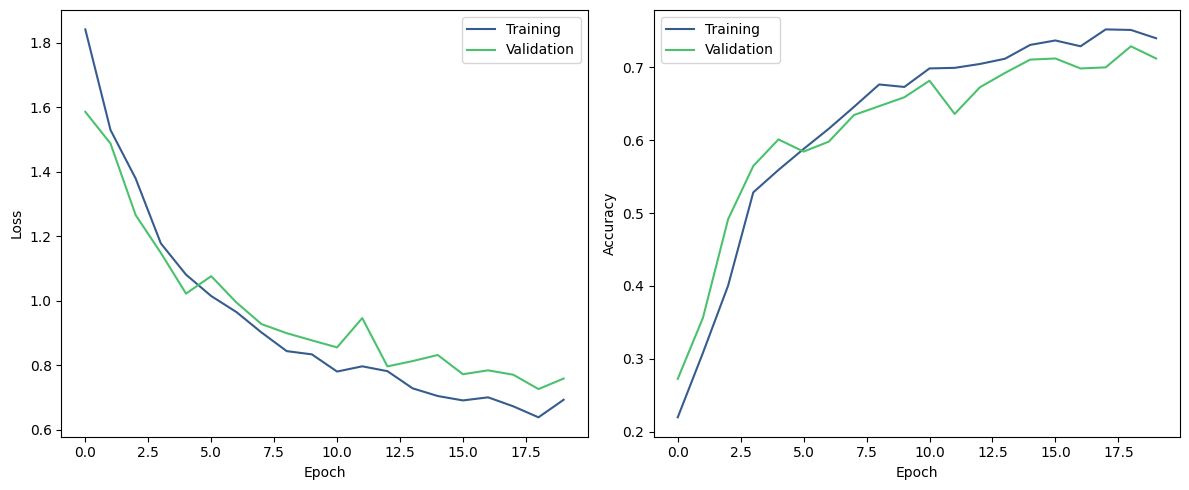

In [51]:
#Print accuracy and loss plots
model1_accuracy_loss_plots = plot_training_history(history_df)
#Save figure as png
model1_accuracy_loss_plots.savefig('model1_accuracy_loss_plots.png')

These plots are useful for diagnosing common issues during training, such as overfitting (where training accuracy is high but validation accuracy is low) or underfitting (where both training and validation accuracy are low). 

The relatively close values of training and validation accuracy indicate that overfitting is happening slightly.

The number of epochs may need to be increased to allow full loss and accuracy to be reached.

In [14]:
#Function to print loss and accuracy metrics
def print_final_metrics(history_df):
    """
    Print the final training and validation metrics.

    Parameters:
    history_df (pd.DataFrame): DataFrame containing the training history.

    Returns:
    None
    """
    #Access the final training accuracy and validation accuracy
    final_train_accuracy = history_df['accuracy'].iloc[-1]
    final_val_accuracy = history_df['val_accuracy'].iloc[-1]

    #Access the final training loss and validation loss
    final_train_loss = history_df['loss'].iloc[-1]
    final_val_loss = history_df['val_loss'].iloc[-1]

    #Print the final metrics
    print(f'Final Training Accuracy: {final_train_accuracy * 100:.2f}%')
    print(f'Final Validation Accuracy: {final_val_accuracy * 100:.2f}%')
    print(f'Final Training Loss: {final_train_loss:.4f}')
    print(f'Final Validation Loss: {final_val_loss:.4f}')

In [53]:
#Print model metrics
metrics_model1 = print_final_metrics(history_df)

Final Training Accuracy: 74.01%
Final Validation Accuracy: 71.23%
Final Training Loss: 0.6927
Final Validation Loss: 0.7584


*Evaluation on test set*

In [15]:
#Function to evaluate model
def evaluate_model(model, x_test, y_test_cat):
    """
    Evaluate a model on the test set, print overall accuracy, and return predicted classes.

    Parameters:
    model: Trained model to be evaluated.
    x_test: Test features.
    y_test_cat: Categorical labels for the test set.

    Returns:
    y_pred_classes: Predicted classes for the test set.
    """
    #Evaluate the model on the test set
    evaluation_results = model.evaluate(x=x_test, y=y_test_cat)

    #Extract the overall accuracy from the evaluation results
    accuracy = evaluation_results[1]

    #Print the overall accuracy
    print(f"Overall Accuracy: {accuracy * 100:.2f}%")

    #Use the model’s predict() function to predict the output values from the input features (x_test) in the test set
    y_pred = model.predict(x_test)

    #Predict the classes for the test data
    y_pred_cat = y_pred.argmax(axis=1)

    return y_pred, y_pred_cat

In [55]:
#Run evaluation function
y_pred, y_pred_cat = evaluate_model(model1, x_test, y_test_cat)

12/12 [==============================] - 9s 752ms/step - loss: 0.7081 - accuracy: 0.7534
Overall Accuracy: 75.34%
12/12 [==============================] - 9s 721ms/step


*Confusion matrix and report*

Tensorflow (2023) tf.math.confusion_matrix. Available online: https://www.tensorflow.org/api_docs/python/tf/math/confusion_matrix [Accessed 16/12/2023].

Scikit learn sklearn.metrics.classification_report. Available online: https://scikit-learn.org/stable/modules/generated/sklearn.metrics.classification_report.html [Accessed 16/12/2023].

Scikit learn sklearn.metrics.precision_recall_fscore_support. Available online: https://scikit-learn.org/stable/modules/generated/sklearn.metrics.precision_recall_fscore_support.html [Accessed 16/12/2023].

In [16]:
#Create a confusion matrix from the model predictions
#from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
def plot_confusion_matrix_report(y_test_cat, y_pred_cat, figsize=(20, 5)):
    """
    Plot a confusion matrix.

    Parameters:
    y_test (array-like): Test class labels.
    y_pred (array-like): Predicted class labels.
    figsize (tuple, optional): Size of the figure.

    Returns:
    matplotlib.figure.Figure: The confusion matrix figure.
    """
    #Predict the classes for the test data
    y_test = y_test_cat.argmax(axis=1)
    #Create and plot confusion matrix
    cm = confusion_matrix(y_test, y_pred_cat)
    display = ConfusionMatrixDisplay(cm)
    
    fig, ax = plt.subplots(figsize=figsize)
    display.plot(ax=ax, cmap='viridis')
    #Print classification report
    print(classification_report(y_test, y_pred_cat))
    
    plt.tight_layout() 
    
    return fig

              precision    recall  f1-score   support

           0       0.70      0.88      0.78        50
           1       0.71      0.90      0.79        91
           2       0.68      0.76      0.72        68
           3       0.89      0.79      0.83        70
           4       0.89      0.49      0.63        86

    accuracy                           0.75       365
   macro avg       0.77      0.76      0.75       365
weighted avg       0.78      0.75      0.75       365



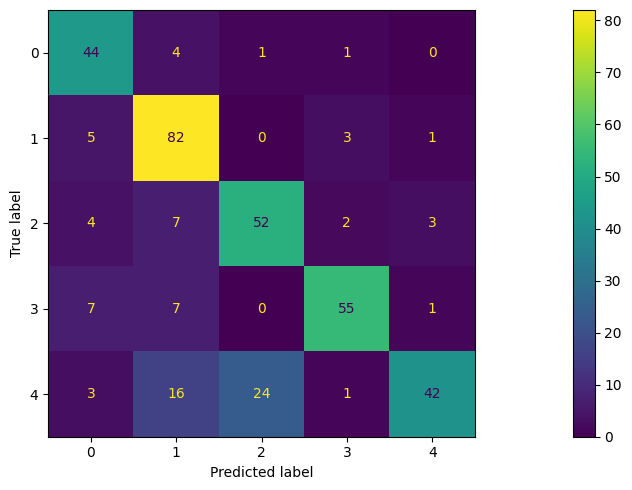

In [88]:
#Print and save confusion matrix
confusion_matrix_model1 = plot_confusion_matrix_report(y_test_cat, y_pred_cat)
confusion_matrix_model1.savefig('confusion_matrix_model1.png')

Precision: How many of the predicted positive instances are actually positive.

Recall: How many of the actual positive instances were captured by the model.

F1-score: A balance between precision and recall, useful when there is an imbalance between classes.

Support: The number of actual occurrences of each class in the dataset.

References: 

Scikit learn sklearn.metrics.precision_recall_fscore_support. Available online: https://scikit-learn.org/stable/modules/generated/sklearn.metrics.precision_recall_fscore_support.html [Accessed 16/12/2023].

Scikit learn sklearn.metrics.classification_report. Available online: https://scikit-learn.org/stable/modules/generated/sklearn.metrics.classification_report.html [Accessed 16/12/2023].

**Summary of first model**

Overall accuracy of model on test data is 75.34% when compared to ground truth category labels. As indicated by plots of loss and accuracy for training and validation data, the model may be slightly overfitting. In terms of classification, the model is confusing 4 with 1 and 2, indicated by lower f1 score.The current model can be improved and needs to be optimised.

*Remove convolutional/pooling/dropout layer/block*

Determine if removing a layer decreases complexity and reduces overfitting without affecting accuracy.

In [104]:
#Another model function minus one convolutional layer
def build_cnn_model_minus_layer(width_npix, height_npix, num_classes, optimizer='adam', kernel_size=(3, 3), batch_norm=False, 
                    momentum=0.90, early_stopping=False, patience=10, l1_reg=0.0, l2_reg=0.0, pooling='max', dropout_rate=0.3, 
                    conv_padding='valid', pool_padding='valid', conv_strides=(1, 1), conv_activation='relu'):
    """
    Build a convolutional neural network model.

    Parameters:
    width_npix (int): Width of the input images.
    height_npix (int): Height of the input images.
    num_classes (int): Number of classes for classification.
    optimizer (keras.optimizers.Optimizer): Optimizer for the model.
    kernel_size (tuple): Size of the convolutional kernels.
    batch_norm (bool): Whether to include batch normalization.
    momentum (float): Momentum for batch normalization.
    early_stopping (bool): Whether to use early stopping.
    patience (int): Patience for early stopping.
    l1_reg (float): L1 regularization strength.
    l2_reg (float): L2 regularization strength.
    pooling (str): Pooling type ('max' or 'average').
    dropout_rate (float): Dropout rate.
    conv_padding (str): Padding type for convolutional layers.
    pool_padding (str): Padding type for pooling layers.
    conv_strides (tuple): Strides for convolutional layers.
    conv_activation (str): Activation function for convolutional layers.

    Returns:
    model (keras.models.Model): The compiled convolutional neural network model.
    """
    #Create an instance of the Sequential class
    model = Sequential()

    #Add layers to the model
    #Input convolutional layer
    model.add(Conv2D(filters=64, kernel_size=kernel_size,
                     input_shape=(width_npix, height_npix, 3),
                     activation=conv_activation, padding=conv_padding, strides=conv_strides))
    #Pooling layer
    if pooling == 'max':
        model.add(MaxPooling2D(pool_size=(2, 2), padding=pool_padding))
    elif pooling == 'average':
        model.add(AveragePooling2D(pool_size=(2, 2), padding=pool_padding))
    #Option to add batch normalisation as parameter  
    if batch_norm:
        model.add(BatchNormalization(momentum=momentum))
    #Dropout layer    
    model.add(Dropout(dropout_rate))
    #Second convolutional layer
    model.add(Conv2D(filters=128, kernel_size=kernel_size, activation=conv_activation, padding=conv_padding, strides=conv_strides))
    #Pooling layer
    if pooling == 'max':
        model.add(MaxPooling2D(pool_size=(2, 2), padding=pool_padding))
    elif pooling == 'average':
        model.add(AveragePooling2D(pool_size=(2, 2), padding=pool_padding))
        
    if batch_norm:
        model.add(BatchNormalization(momentum=momentum))
    #Dropout layer    
    model.add(Dropout(dropout_rate))
    #Third convolutional layer
    model.add(Conv2D(filters=256, kernel_size=kernel_size, activation=conv_activation, padding=conv_padding, strides=conv_strides))
    #Pooling layer
    if pooling == 'max':
        model.add(MaxPooling2D(pool_size=(2, 2), padding=pool_padding))
    elif pooling == 'average':
        model.add(AveragePooling2D(pool_size=(2, 2), padding=pool_padding))
        
    if batch_norm:
        model.add(BatchNormalization(momentum=momentum))
    #Dropout layer    
    model.add(Dropout(dropout_rate))
    #Fourth convolutional layer
    model.add(Conv2D(filters=512, kernel_size=kernel_size, activation=conv_activation, padding=conv_padding, strides=conv_strides))
    #Pooling layer
    if pooling == 'max':
        model.add(MaxPooling2D(pool_size=(2, 2), padding=pool_padding))
    elif pooling == 'average':
        model.add(AveragePooling2D(pool_size=(2, 2), padding=pool_padding))
        
    if batch_norm:
        model.add(BatchNormalization(momentum=momentum))
    #Dropout layer    
    model.add(Dropout(dropout_rate))

    model.add(Flatten())
    #Dense layer
    model.add(Dense(512, activation='relu'))
    #Dropout layer
    model.add(Dropout(dropout_rate))
    
    if batch_norm:
        model.add(BatchNormalization(momentum=momentum))
    #Output layer with softmax
    model.add(Dense(num_classes, activation='softmax',
                    kernel_regularizer=l2(l2_reg), activity_regularizer=l1(l1_reg)))
    
    #Additional configurations if early stopping
    if early_stopping:
        early_stopping = EarlyStopping(monitor='val_loss', patience=patience)

    #Print model summary
    model.summary()
    
    #Compile the model
    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics='accuracy')

    return model

In [105]:
#Removed Conv2D layer, learning rate of 0.001, dropout of 0.3, max pooling and relu activation for all conv2d layers, kernel size 3,3
#No batch normalisation, padding or stride
model2 = build_cnn_model_minus_layer(width_npix, height_npix, num_classes)

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_9 (Conv2D)           (None, 254, 254, 64)      1792      
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 127, 127, 64)     0         
 2D)                                                             
                                                                 
 dropout_11 (Dropout)        (None, 127, 127, 64)      0         
                                                                 
 conv2d_10 (Conv2D)          (None, 125, 125, 128)     73856     
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, 62, 62, 128)      0         
 g2D)                                                            
                                                                 
 dropout_12 (Dropout)        (None, 62, 62, 128)      

In [106]:
#Train the model for 20 epochs and batch size 64
batch_size = 64 #41 batches (80% of training set (3289 images) = 2631.2 / 64 = 41)
history2 = model2.fit(train_datagen.flow(x_train, y_train_cat,
batch_size = batch_size,
subset = "training"),
epochs = 20, validation_data =
train_datagen.flow(x_train, y_train_cat,
batch_size = batch_size,
subset = "validation"))

Epoch 1/20
42/42 [==============================] - 407s 10s/step - loss: 3.3197 - accuracy: 0.2299 - val_loss: 1.5581 - val_accuracy: 0.2725
Epoch 2/20
42/42 [==============================] - 420s 10s/step - loss: 1.5355 - accuracy: 0.2815 - val_loss: 1.5904 - val_accuracy: 0.2755
Epoch 3/20
42/42 [==============================] - 404s 10s/step - loss: 1.4970 - accuracy: 0.3089 - val_loss: 1.5093 - val_accuracy: 0.3242
Epoch 4/20
42/42 [==============================] - 404s 10s/step - loss: 1.4586 - accuracy: 0.3651 - val_loss: 1.5148 - val_accuracy: 0.2877
Epoch 5/20
42/42 [==============================] - 403s 10s/step - loss: 1.3690 - accuracy: 0.4016 - val_loss: 1.3766 - val_accuracy: 0.3059
Epoch 6/20
42/42 [==============================] - 404s 10s/step - loss: 1.2142 - accuracy: 0.5049 - val_loss: 1.1520 - val_accuracy: 0.4962
Epoch 7/20
42/42 [==============================] - 401s 10s/step - loss: 1.1026 - accuracy: 0.5407 - val_loss: 1.1052 - val_accuracy: 0.5708
Epoch 

In [107]:
#Convert history2 to df
history2_df = pd.DataFrame(history2.history)

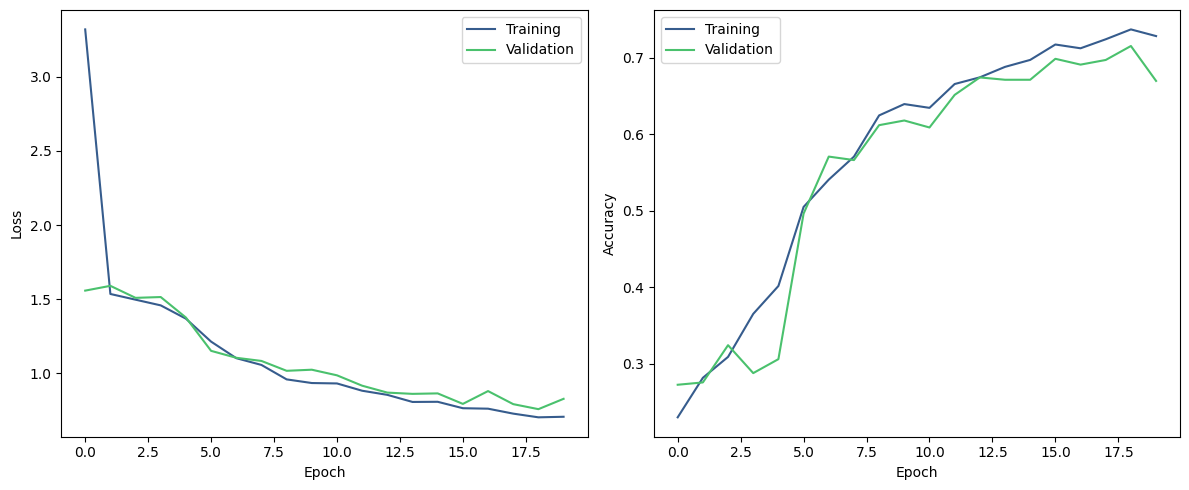

In [108]:
#Print and save accuracy plots
model2_accuracy_loss_plots = plot_training_history(history2_df)
model2_accuracy_loss_plots.savefig('model2_accuracy_loss_plots.png')

In [109]:
#Print metrics
metrics_model2 = print_final_metrics(history2_df)

Final Training Accuracy: 72.83%
Final Validation Accuracy: 66.97%
Final Training Loss: 0.7074
Final Validation Loss: 0.8284


In [110]:
#Evalute model on test set
y_pred, y_pred_cat = evaluate_model(model2, x_test, y_test_cat)

12/12 [==============================] - 11s 926ms/step - loss: 0.7954 - accuracy: 0.7096
Overall Accuracy: 70.96%
12/12 [==============================] - 11s 931ms/step


              precision    recall  f1-score   support

           0       0.78      0.80      0.79        50
           1       0.63      0.91      0.74        91
           2       0.83      0.29      0.43        68
           3       0.83      0.84      0.84        70
           4       0.66      0.66      0.66        86

    accuracy                           0.71       365
   macro avg       0.75      0.70      0.69       365
weighted avg       0.73      0.71      0.69       365



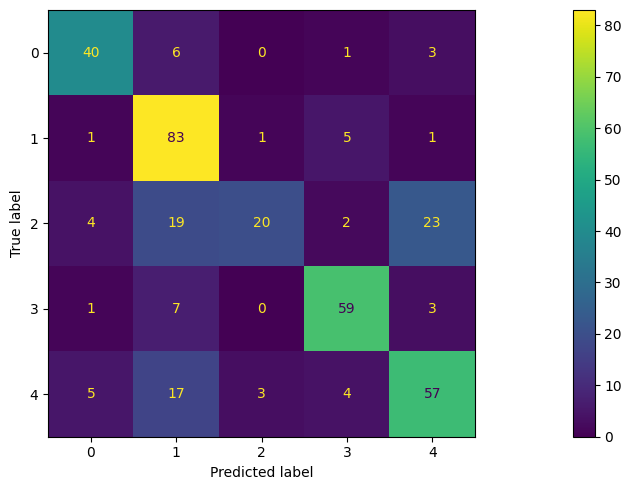

In [111]:
#Print and save confusion matrix
confusion_matrix_model2 = plot_confusion_matrix_report(y_test_cat, y_pred_cat)
confusion_matrix_model2.savefig('confusion_matrix_model2.png')

**Summary of removing one layer**

Removing layer reduced training and validation accuracy with presence of over-fitting. The extra layer is a better fit to the data. Classification performance is also poorer with particularly lowe recall score for 2 and low recall for 4 as well.

**Regularisation**

Methods of regularisation can try:

1. Dropout

Dropout is a technique where randomly selected neurons are ignored during training. It helps prevent co-adaptation of neurons and reduces overfitting.

from keras.layers import Dropout

Tensorflow (2023) tf.keras.layers.Dropout. Available online: https://www.tensorflow.org/api_docs/python/tf/keras/layers/Dropout [Accessed 16/12/2023].

2. Batch normalisation

Batch Normalisation normalises the input of each layer by adjusting and scaling the activations. It helps stabilise and accelerate training. Can fine tune momentum to optmisie batch normalisation too.

Often used as default in deep learning models.

from keras.layers import BatchNormalization

Tensorflow (2023) tf.keras.layers.BatchNormalization. Available online: https://www.tensorflow.org/api_docs/python/tf/keras/layers/BatchNormalization [Accessed 16/12/2023].

3. Early stopping

Early stopping halts training when the performance on a validation set stops improving, preventing overfitting. Fine tue patience and minimum delta accordingly.

from keras.callbacks import EarlyStopping

Tensorflow (2023) tf.keras.callbacks.EarlyStopping. Available online: https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/EarlyStopping [Accessed 16/12/2023].

4. L1 and L2 Regularisation

L1 regularization adds a penalty term to the loss function based on the absolute values of the weights. It encourages sparsity in the weight matrix.

L2 regularization adds a penalty term based on the squared values of the weights. It discourages large weights.

from keras.regularizers import l1, l2

Tensorflow (2023) tf.keras.regularizers.Regularizer. Available online: https://www.tensorflow.org/api_docs/python/tf/keras/regularizers/Regularizer [Accessed 16/12/2023].

*Dropout*

Dropout randomly drops a fraction of the neurons in the network during training. It is a regularisation technique to prevent overfitting.

I am increasing dropout from 0.3 to 0.5 because of evidence so far of slight overfitting in model 1.

References:

Mehdi, C. A., Nour-Eddine, J. & Mohamed, E. (2022) Regularization in CNN: A mathematical study for L1 and L2 and dropout regularizers, International Conference on Advanced Intelligent Systems for Sustainable Development. Rabat, Morocco, 22-27 May 2022. Springer, 442-450.

Yang, J. & Yang, G. C. (2018) Modified convolutional neural network based on dropout and the stochastic gradient descent optimizer. Algorithms, 11(3), 28.

In [12]:
#Model 3 with dropout rate increased to 0.5
model3 = build_cnn_model(width_npix, height_npix, num_classes, dropout_rate=0.5)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 254, 254, 64)      1792      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 127, 127, 64)     0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 127, 127, 64)      0         
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 128)     73856     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 62, 62, 128)      0         
 2D)                                                             
                                                                 
 dropout_1 (Dropout)         (None, 62, 62, 128)       0

In [13]:
#Train the model for 20 epochs and batch size 64
batch_size = 64 #41 batches (80% of training set (3289 images) = 2631.2 / 64 = 41)
history3 = model3.fit(train_datagen.flow(x_train, y_train_cat,
batch_size = batch_size,
subset = "training"),
epochs = 20, validation_data =
train_datagen.flow(x_train, y_train_cat,
batch_size = batch_size,
subset = "validation"))

Epoch 1/20
42/42 [==============================] - 359s 8s/step - loss: 1.9719 - accuracy: 0.2299 - val_loss: 1.6020 - val_accuracy: 0.2725
Epoch 2/20
42/42 [==============================] - 337s 8s/step - loss: 1.5506 - accuracy: 0.2880 - val_loss: 1.5484 - val_accuracy: 0.2877
Epoch 3/20
42/42 [==============================] - 334s 8s/step - loss: 1.4325 - accuracy: 0.3606 - val_loss: 1.4111 - val_accuracy: 0.4658
Epoch 4/20
42/42 [==============================] - 331s 8s/step - loss: 1.2791 - accuracy: 0.4730 - val_loss: 1.3200 - val_accuracy: 0.4277
Epoch 5/20
42/42 [==============================] - 338s 8s/step - loss: 1.1676 - accuracy: 0.5091 - val_loss: 1.3202 - val_accuracy: 0.4353
Epoch 6/20
42/42 [==============================] - 318s 8s/step - loss: 1.1099 - accuracy: 0.5479 - val_loss: 1.1979 - val_accuracy: 0.5068
Epoch 7/20
42/42 [==============================] - 320s 8s/step - loss: 1.0630 - accuracy: 0.5509 - val_loss: 1.1933 - val_accuracy: 0.5160
Epoch 8/20
42

In [18]:
#Convert history3 to df
history3_df = pd.DataFrame(history3.history)

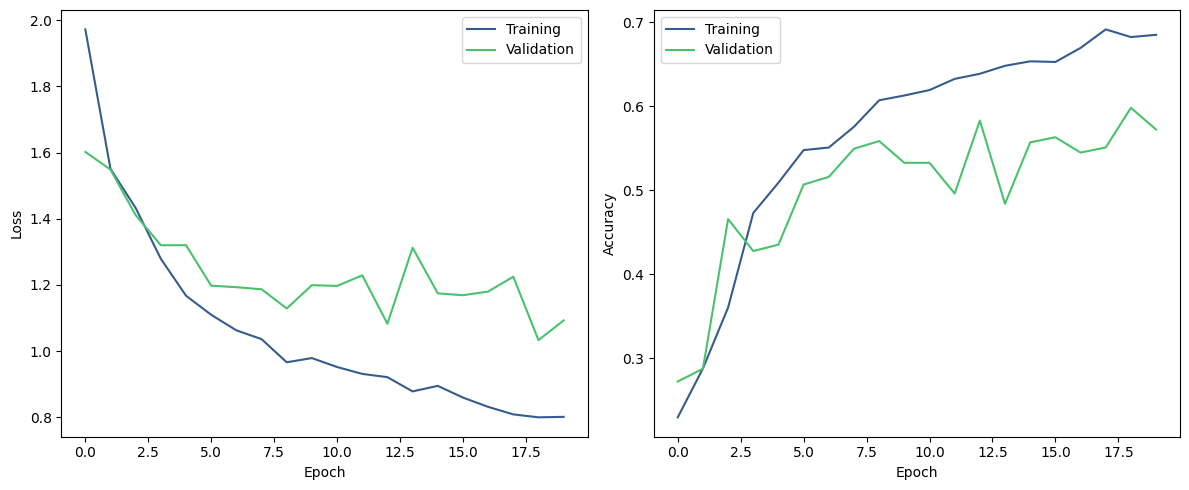

In [19]:
#Print and save accuracy plots
model3_accuracy_loss_plots = plot_training_history(history3_df)
model3_accuracy_loss_plots.savefig('model3_accuracy_loss_plots.png')

In [20]:
#Print metrics
metrics_model3 = print_final_metrics(history3_df)

Final Training Accuracy: 68.50%
Final Validation Accuracy: 57.23%
Final Training Loss: 0.8016
Final Validation Loss: 1.0930


In [21]:
#Evalute model on test set
y_pred, y_pred_cat = evaluate_model(model3, x_test, y_test_cat)

12/12 [==============================] - 12s 986ms/step - loss: 1.0331 - accuracy: 0.5863
Overall Accuracy: 58.63%
12/12 [==============================] - 12s 1s/step


              precision    recall  f1-score   support

           0       0.61      0.90      0.73        50
           1       0.51      0.87      0.64        91
           2       0.39      0.25      0.30        68
           3       0.76      0.79      0.77        70
           4       0.86      0.21      0.34        86

    accuracy                           0.59       365
   macro avg       0.63      0.60      0.56       365
weighted avg       0.63      0.59      0.54       365



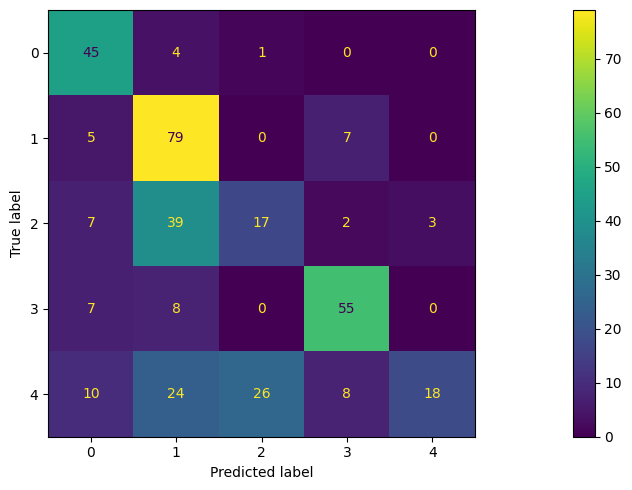

In [22]:
#Print and save confusion matrix
confusion_matrix_model3 = plot_confusion_matrix_report(y_test_cat, y_pred_cat)
confusion_matrix_model3.savefig('confusion_matrix_model3.png')

**Summary of dropout**

Increasing dropout increased over-fitting significantly as indicated by lower validation accuracy compared to dropout of 0.3. Successful classifications also reduced. Really low precision, recall and subsequently f1 score for 2. ALso low recall and f1 score for 4.

Will try dropout 0.3 with batch normalisation.

May reduce dropout to 0.2 later on to see effect with different regularisation techniques.

*Batch normalisation*

BatchNormalization takes an optional parameter, the momentum, which it uses when calculating moving averages across batches. If set too high the plots of loss and accuracy versus epoch become very noisy.

Momentum set to 0.9 (typically between 0.9 and 0.999). Higher than 0.9 and increases noise.

A momentum value of 1 is where the moving average is updated completely with each mini-batch. In this scenario, the moving average converges to the overall mean and variance of the entire dataset, and the effect of the current mini-batch diminishes.

If the training is too slow, try a lower momentum value.

If the training is too fast, try a higher momentum value.

References:

Ioffe, S. & Szegedy, C. (2015) Batch normalization: accelerating deep network training by reducing internal covariate shift, 32nd International Conference on Machine Learning. Lille, France, 7-9 July 2015. 448-456.

Dive into deep learning (n .d.) Batch normalization. Available online: https://d2l.ai/chapter_convolutional-modern/batch-norm.html [Accessed 16/12/2023].

In [17]:
#Add batch normalisation (momentum default 0.90) to model 4
model4 = build_cnn_model(width_npix, height_npix, num_classes, batch_norm=True)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 254, 254, 64)      1792      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 127, 127, 64)     0         
 )                                                               
                                                                 
 batch_normalization (BatchN  (None, 127, 127, 64)     256       
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 127, 127, 64)      0         
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 128)     73856     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 62, 62, 128)      0

In [18]:
#Train the model for 20 epochs and batch size 64
batch_size = 64 #41 batches (80% of training set (3289 images) = 2631.2 / 64 = 41)
history4 = model4.fit(train_datagen.flow(x_train, y_train_cat,
batch_size = batch_size,
subset = "training"),
epochs = 20, validation_data =
train_datagen.flow(x_train, y_train_cat,
batch_size = batch_size,
subset = "validation"))

Epoch 1/20
42/42 [==============================] - 456s 11s/step - loss: 1.5965 - accuracy: 0.4810 - val_loss: 2.2197 - val_accuracy: 0.2846
Epoch 2/20
42/42 [==============================] - 437s 10s/step - loss: 1.1263 - accuracy: 0.5714 - val_loss: 1.1182 - val_accuracy: 0.5830
Epoch 3/20
42/42 [==============================] - 435s 10s/step - loss: 1.0461 - accuracy: 0.5942 - val_loss: 1.3321 - val_accuracy: 0.5084
Epoch 4/20
42/42 [==============================] - 435s 10s/step - loss: 0.9854 - accuracy: 0.6334 - val_loss: 1.3118 - val_accuracy: 0.5556
Epoch 5/20
42/42 [==============================] - 394s 9s/step - loss: 0.9471 - accuracy: 0.6429 - val_loss: 1.1888 - val_accuracy: 0.5571
Epoch 6/20
42/42 [==============================] - 455s 11s/step - loss: 0.8568 - accuracy: 0.6736 - val_loss: 1.1009 - val_accuracy: 0.6043
Epoch 7/20
42/42 [==============================] - 408s 10s/step - loss: 0.8379 - accuracy: 0.6809 - val_loss: 1.1050 - val_accuracy: 0.6301
Epoch 8

In [19]:
#Convert history4 to df
history4_df = pd.DataFrame(history4.history)

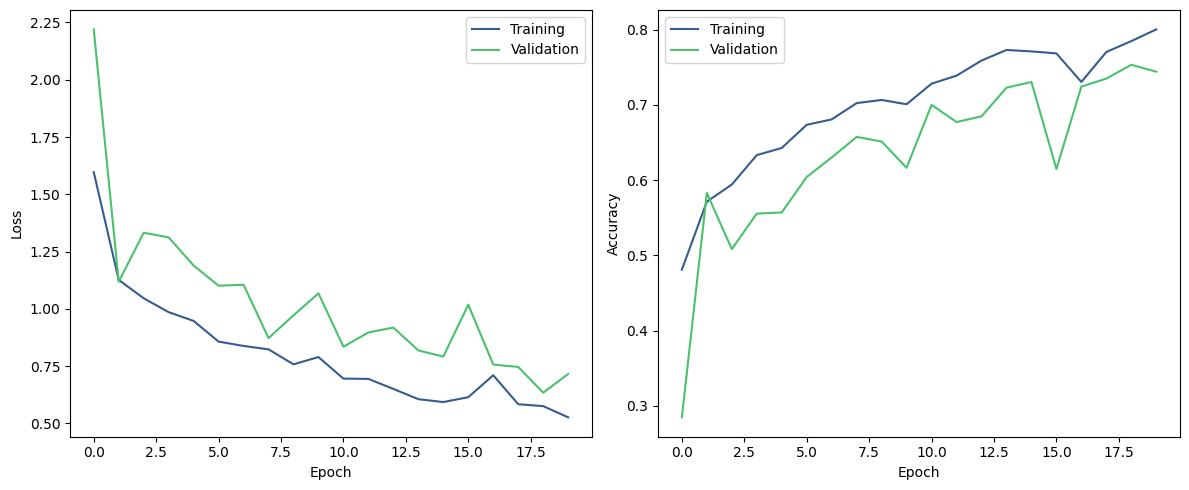

In [20]:
#Print and save accuracy plots
model4_accuracy_loss_plots = plot_training_history(history4_df)
model4_accuracy_loss_plots.savefig('model4_accuracy_loss_plots.png')

In [21]:
#Print metrics
metrics_model4 = print_final_metrics(history4_df)

Final Training Accuracy: 80.05%
Final Validation Accuracy: 74.43%
Final Training Loss: 0.5263
Final Validation Loss: 0.7154


In [22]:
#Evalute model on test set
y_pred, y_pred_cat = evaluate_model(model4, x_test, y_test_cat)

12/12 [==============================] - 11s 855ms/step - loss: 0.6300 - accuracy: 0.7370
Overall Accuracy: 73.70%
12/12 [==============================] - 11s 872ms/step


              precision    recall  f1-score   support

           0       0.66      0.82      0.73        50
           1       0.79      0.81      0.80        91
           2       0.66      0.49      0.56        68
           3       0.84      0.84      0.84        70
           4       0.70      0.72      0.71        86

    accuracy                           0.74       365
   macro avg       0.73      0.74      0.73       365
weighted avg       0.74      0.74      0.73       365



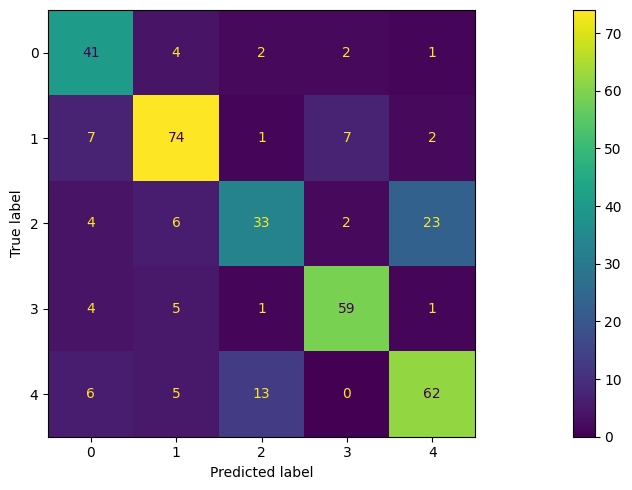

In [23]:
#Print and save confusion matrix
confusion_matrix_model4 = plot_confusion_matrix_report(y_test_cat, y_pred_cat)
confusion_matrix_model4.savefig('confusion_matrix_model4.png')

**Summary of batch normalisation**

Adding batch normalisation has slightly reduced accuracy and caused over-fitting. Low recall and f1 score for 2. Next will try and add additional regularisation with L1 and L2 combined (elastic).

Also need to play around with learning rate because the optimal rate may have changed with batch normalisation (try increasing to 0.01)

*L1 and L2 regularisation*

Can be applied to convolutional and dense layers to improve generalisation and prevent overfitting.

Layers that have a larger number of parameters or connections are often more prone to overfitting. Fully connected layers typically have more parameters than convolutional layers, so will try L1 and L2 regularisation on densely connected layers.

Applying to final softmax layer as might be overfitting in the last layers of the network because model is not generalising to new unseen data and tends to memorise the training data.

Regularisation strength can also be tuned. Testing 0.001, 0.01, 0.1 and 1.

Applying both L1 and L2 regularisation (Elastic Net) promoting sparsity and handlng correlated features. Going to keep strength the same for both L1 and L2 and make incremental increases of both together. 

References:

Neptune.ai (2023) Fighting overfitting with L1 or L2 regularization: which one is better? Available online: https://neptune.ai/blog/fighting-overfitting-with-l1-or-l2-regularization [Accessed 16/12/2023].

Mehdi, C. A., Nour-Eddine, J. & Mohamed, E. (2022) Regularization in CNN: A mathematical study for L1 and L2 and dropout regularizers, International Conference on Advanced Intelligent Systems for Sustainable Development. Rabat, Morocco, 22-27 May 2022. Springer, 442-450.

Tensorflow (2023) tf.keras.regularizers.Regularizer. Available online: https://www.tensorflow.org/api_docs/python/tf/keras/regularizers/Regularizer [Accessed 16/12/2023].

In [30]:
#Add L1 and L2 regularisation to model 5, 0.01 strength for both, with batch normalisation, dropout rate 0.3
model5 = build_cnn_model(width_npix, height_npix, num_classes, batch_norm=True, l1_reg=0.01, l2_reg=0.01)

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_10 (Conv2D)          (None, 254, 254, 64)      1792      
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, 127, 127, 64)     0         
 g2D)                                                            
                                                                 
 batch_normalization_6 (Batc  (None, 127, 127, 64)     256       
 hNormalization)                                                 
                                                                 
 dropout_12 (Dropout)        (None, 127, 127, 64)      0         
                                                                 
 conv2d_11 (Conv2D)          (None, 125, 125, 128)     73856     
                                                                 
 max_pooling2d_11 (MaxPoolin  (None, 62, 62, 128)     

In [31]:
#Train the model for 20 epochs and batch size 64
batch_size = 64 #41 batches (80% of training set (3289 images) = 2631.2 / 64 = 41)
history5 = model5.fit(train_datagen.flow(x_train, y_train_cat,
batch_size = batch_size,
subset = "training"),
epochs = 20, validation_data =
train_datagen.flow(x_train, y_train_cat,
batch_size = batch_size,
subset = "validation"))

Epoch 1/20
42/42 [==============================] - 418s 10s/step - loss: 1.6776 - accuracy: 0.4711 - val_loss: 2.5811 - val_accuracy: 0.2725
Epoch 2/20
42/42 [==============================] - 457s 11s/step - loss: 1.2785 - accuracy: 0.5566 - val_loss: 1.4928 - val_accuracy: 0.4597
Epoch 3/20
42/42 [==============================] - 427s 10s/step - loss: 1.1950 - accuracy: 0.5809 - val_loss: 1.3839 - val_accuracy: 0.5129
Epoch 4/20
42/42 [==============================] - 487s 12s/step - loss: 1.0969 - accuracy: 0.6151 - val_loss: 1.3420 - val_accuracy: 0.5312
Epoch 5/20
42/42 [==============================] - 453s 11s/step - loss: 0.9876 - accuracy: 0.6626 - val_loss: 1.4665 - val_accuracy: 0.5160
Epoch 6/20
42/42 [==============================] - 449s 11s/step - loss: 0.9267 - accuracy: 0.6706 - val_loss: 1.3745 - val_accuracy: 0.5601
Epoch 7/20
42/42 [==============================] - 445s 11s/step - loss: 0.8720 - accuracy: 0.6903 - val_loss: 1.1054 - val_accuracy: 0.5997
Epoch 

In [32]:
#Convert history5 to df
history5_df = pd.DataFrame(history5.history)

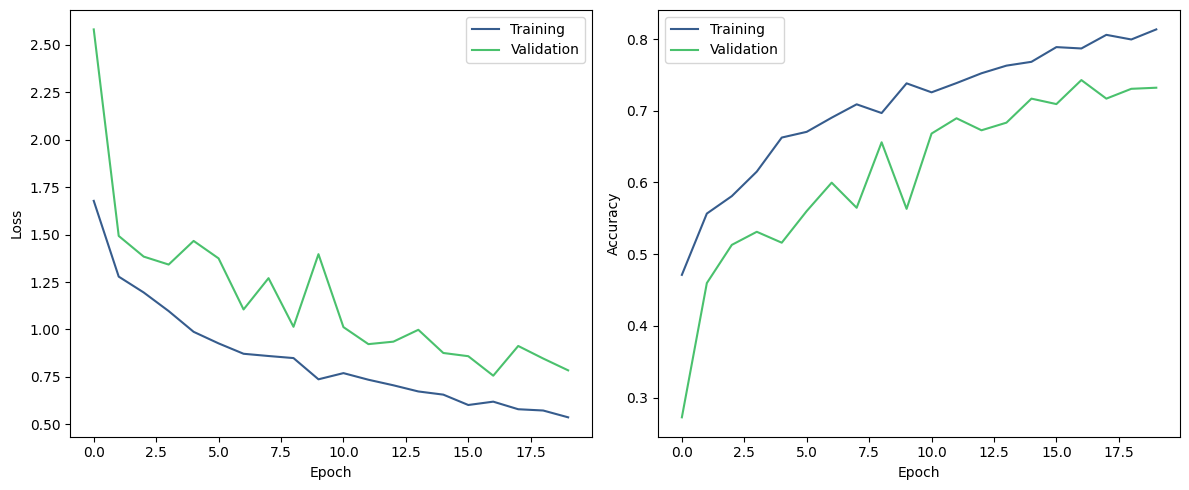

In [33]:
#Print and save accuracy plots
model5_accuracy_loss_plots = plot_training_history(history5_df)
model5_accuracy_loss_plots.savefig('model5_accuracy_loss_plots.png')

In [34]:
#Print metrics
metrics_model5 = print_final_metrics(history5_df)

Final Training Accuracy: 81.34%
Final Validation Accuracy: 73.21%
Final Training Loss: 0.5371
Final Validation Loss: 0.7846


In [35]:
#Evalute model on test set
y_pred, y_pred_cat = evaluate_model(model5, x_test, y_test_cat)

12/12 [==============================] - 11s 903ms/step - loss: 0.7113 - accuracy: 0.7562
Overall Accuracy: 75.62%
12/12 [==============================] - 11s 908ms/step


              precision    recall  f1-score   support

           0       0.89      0.64      0.74        50
           1       0.82      0.82      0.82        91
           2       0.59      0.78      0.67        68
           3       0.83      0.81      0.82        70
           4       0.75      0.69      0.72        86

    accuracy                           0.76       365
   macro avg       0.77      0.75      0.75       365
weighted avg       0.77      0.76      0.76       365



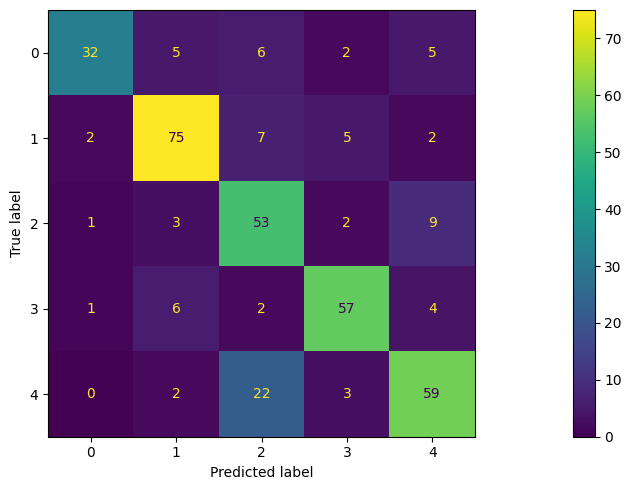

In [36]:
#Print and save confusion matrix
confusion_matrix_model5 = plot_confusion_matrix_report(y_test_cat, y_pred_cat)
confusion_matrix_model5.savefig('confusion_matrix_model5.png')

4 is misclassified as 2 most significantly, indicated by lower recall. Precision is lower for 2 (misclassyfying as 4). Model is overfitting.

In [37]:
#Add L1 and L2 regularisation to model 6, 0.1 strength for both, with batch normalisation
model6 = build_cnn_model(width_npix, height_npix, num_classes, batch_norm=True, l1_reg=0.1, l2_reg=0.1)

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_15 (Conv2D)          (None, 254, 254, 64)      1792      
                                                                 
 max_pooling2d_15 (MaxPoolin  (None, 127, 127, 64)     0         
 g2D)                                                            
                                                                 
 batch_normalization_12 (Bat  (None, 127, 127, 64)     256       
 chNormalization)                                                
                                                                 
 dropout_18 (Dropout)        (None, 127, 127, 64)      0         
                                                                 
 conv2d_16 (Conv2D)          (None, 125, 125, 128)     73856     
                                                                 
 max_pooling2d_16 (MaxPoolin  (None, 62, 62, 128)     

In [38]:
#Train the model for 20 epochs and batch size 64
batch_size = 64 #41 batches (80% of training set (3289 images) = 2631.2 / 64 = 41)
history6 = model6.fit(train_datagen.flow(x_train, y_train_cat,
batch_size = batch_size,
subset = "training"),
epochs = 20, validation_data =
train_datagen.flow(x_train, y_train_cat,
batch_size = batch_size,
subset = "validation"))

Epoch 1/20
42/42 [==============================] - 392s 9s/step - loss: 2.4524 - accuracy: 0.4890 - val_loss: 2.6585 - val_accuracy: 0.2831
Epoch 2/20
42/42 [==============================] - 428s 10s/step - loss: 1.7567 - accuracy: 0.5783 - val_loss: 1.9678 - val_accuracy: 0.4612
Epoch 3/20
42/42 [==============================] - 459s 11s/step - loss: 1.4766 - accuracy: 0.6132 - val_loss: 1.6672 - val_accuracy: 0.5068
Epoch 4/20
42/42 [==============================] - 450s 10s/step - loss: 1.2802 - accuracy: 0.6459 - val_loss: 1.4577 - val_accuracy: 0.5525
Epoch 5/20
42/42 [==============================] - 455s 11s/step - loss: 1.1212 - accuracy: 0.6763 - val_loss: 1.7489 - val_accuracy: 0.5068
Epoch 6/20
42/42 [==============================] - 461s 11s/step - loss: 1.0614 - accuracy: 0.6812 - val_loss: 1.2899 - val_accuracy: 0.6027
Epoch 7/20
42/42 [==============================] - 457s 11s/step - loss: 0.9906 - accuracy: 0.6976 - val_loss: 1.1566 - val_accuracy: 0.6256
Epoch 8

In [39]:
#Convert history6 to df
history6_df = pd.DataFrame(history6.history)

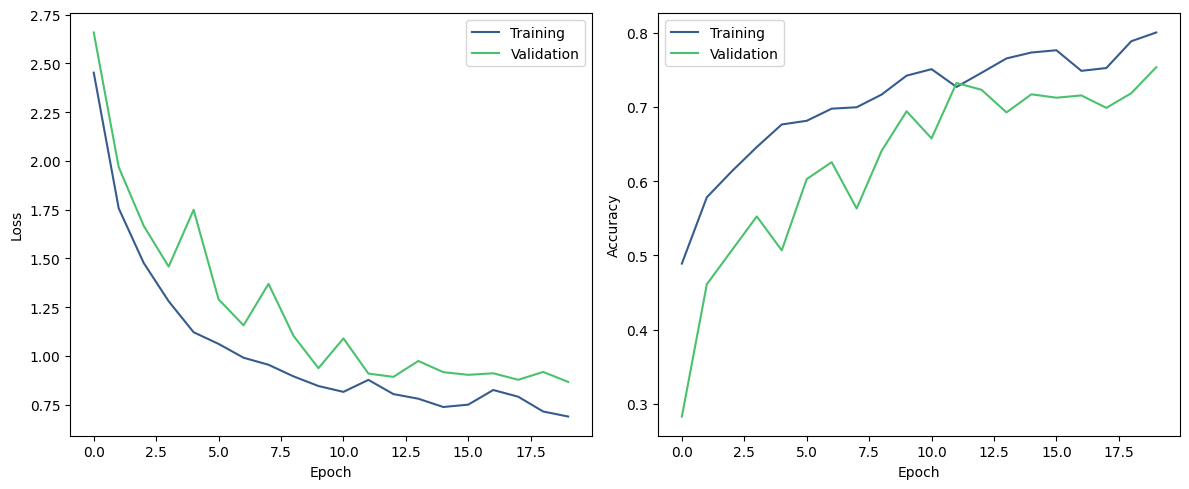

In [40]:
#Print and save accuracy plots
model6_accuracy_loss_plots = plot_training_history(history6_df)
model6_accuracy_loss_plots.savefig('model6_accuracy_loss_plots.png')

In [41]:
#Print metrics
metrics_model6 = print_final_metrics(history6_df)

Final Training Accuracy: 80.02%
Final Validation Accuracy: 75.34%
Final Training Loss: 0.6891
Final Validation Loss: 0.8666


In [42]:
#Evalute model on test set
y_pred, y_pred_cat = evaluate_model(model6, x_test, y_test_cat)

12/12 [==============================] - 12s 956ms/step - loss: 0.8682 - accuracy: 0.7288
Overall Accuracy: 72.88%
12/12 [==============================] - 12s 915ms/step


              precision    recall  f1-score   support

           0       0.66      0.82      0.73        50
           1       0.76      0.82      0.79        91
           2       0.69      0.75      0.72        68
           3       0.88      0.53      0.66        70
           4       0.70      0.72      0.71        86

    accuracy                           0.73       365
   macro avg       0.74      0.73      0.72       365
weighted avg       0.74      0.73      0.73       365



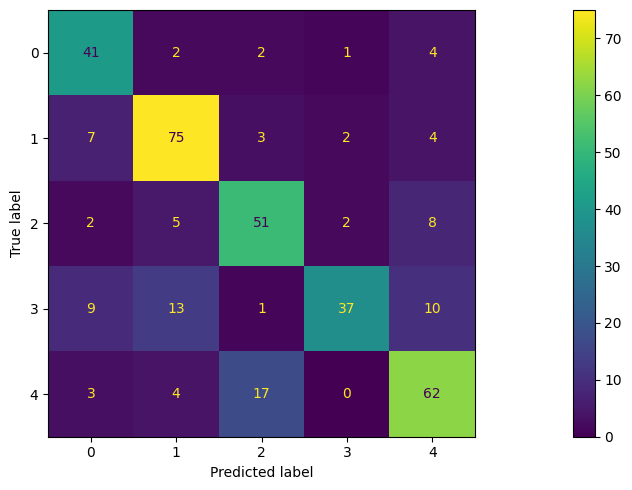

In [43]:
#Print and save confusion matrix
confusion_matrix_model6 = plot_confusion_matrix_report(y_test_cat, y_pred_cat)
confusion_matrix_model6.savefig('confusion_matrix_model6.png')

3 has low recall and is confused for 0,1, and 4. 4 is also misclassifying as 2. Model is overfitting.

In [44]:
#Add L1 and L2 regularisation to model 7, 1 strength for both, with batch normalisation
model7 = build_cnn_model(width_npix, height_npix, num_classes, batch_norm=True, l1_reg=1, l2_reg=1)

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_20 (Conv2D)          (None, 254, 254, 64)      1792      
                                                                 
 max_pooling2d_20 (MaxPoolin  (None, 127, 127, 64)     0         
 g2D)                                                            
                                                                 
 batch_normalization_18 (Bat  (None, 127, 127, 64)     256       
 chNormalization)                                                
                                                                 
 dropout_24 (Dropout)        (None, 127, 127, 64)      0         
                                                                 
 conv2d_21 (Conv2D)          (None, 125, 125, 128)     73856     
                                                                 
 max_pooling2d_21 (MaxPoolin  (None, 62, 62, 128)     

In [45]:
#Train the model for 20 epochs and batch size 64
batch_size = 64 #41 batches (80% of training set (3289 images) = 2631.2 / 64 = 41)
history7 = model7.fit(train_datagen.flow(x_train, y_train_cat,
batch_size = batch_size,
subset = "training"),
epochs = 20, validation_data =
train_datagen.flow(x_train, y_train_cat,
batch_size = batch_size,
subset = "validation"))

Epoch 1/20
42/42 [==============================] - 453s 11s/step - loss: 8.5039 - accuracy: 0.4783 - val_loss: 5.5992 - val_accuracy: 0.2861
Epoch 2/20
42/42 [==============================] - 443s 11s/step - loss: 3.6797 - accuracy: 0.5866 - val_loss: 2.9476 - val_accuracy: 0.4688
Epoch 3/20
42/42 [==============================] - 443s 11s/step - loss: 2.4151 - accuracy: 0.6163 - val_loss: 2.3604 - val_accuracy: 0.5556
Epoch 4/20
42/42 [==============================] - 439s 10s/step - loss: 2.1040 - accuracy: 0.6512 - val_loss: 2.2128 - val_accuracy: 0.5830
Epoch 5/20
42/42 [==============================] - 469s 11s/step - loss: 2.0287 - accuracy: 0.6634 - val_loss: 2.0933 - val_accuracy: 0.6332
Epoch 6/20
42/42 [==============================] - 440s 10s/step - loss: 1.9667 - accuracy: 0.6858 - val_loss: 2.2740 - val_accuracy: 0.5830
Epoch 7/20
42/42 [==============================] - 460s 11s/step - loss: 1.9459 - accuracy: 0.7006 - val_loss: 2.2506 - val_accuracy: 0.5693
Epoch 

In [46]:
#Convert history7 to df
history7_df = pd.DataFrame(history7.history)

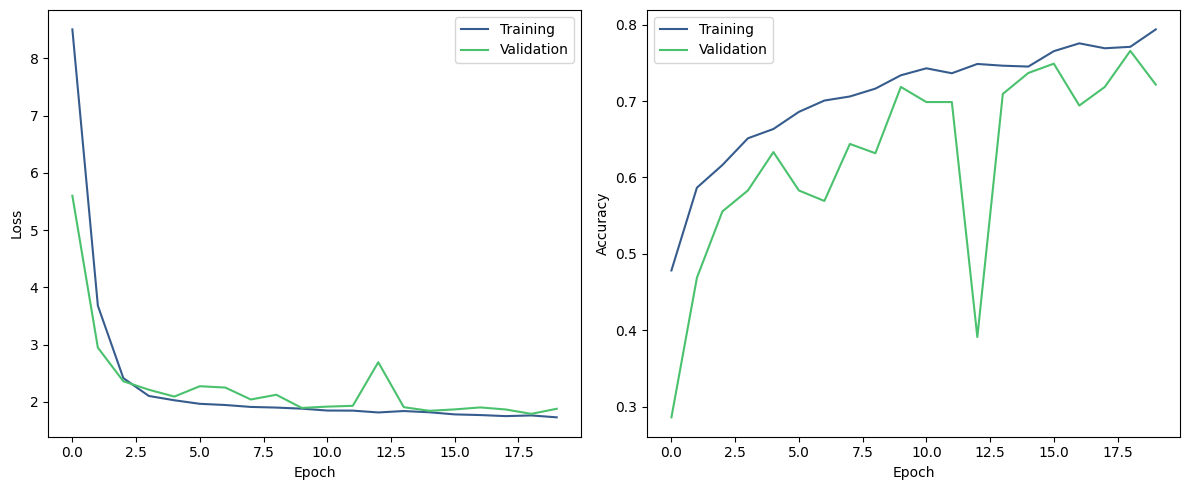

In [47]:
#Print and save accuracy plots
model7_accuracy_loss_plots = plot_training_history(history7_df)
model7_accuracy_loss_plots.savefig('model7_accuracy_loss_plots.png')

In [48]:
#Print metrics
metrics_model7 = print_final_metrics(history7_df)

Final Training Accuracy: 79.37%
Final Validation Accuracy: 72.15%
Final Training Loss: 1.7309
Final Validation Loss: 1.8798


In [49]:
#Evalute model on test set
y_pred, y_pred_cat = evaluate_model(model7, x_test, y_test_cat)

12/12 [==============================] - 10s 838ms/step - loss: 1.8428 - accuracy: 0.7589
Overall Accuracy: 75.89%
12/12 [==============================] - 11s 907ms/step


              precision    recall  f1-score   support

           0       0.87      0.78      0.82        50
           1       0.73      0.91      0.81        91
           2       0.66      0.76      0.71        68
           3       0.74      0.89      0.81        70
           4       0.93      0.48      0.63        86

    accuracy                           0.76       365
   macro avg       0.79      0.76      0.76       365
weighted avg       0.79      0.76      0.75       365



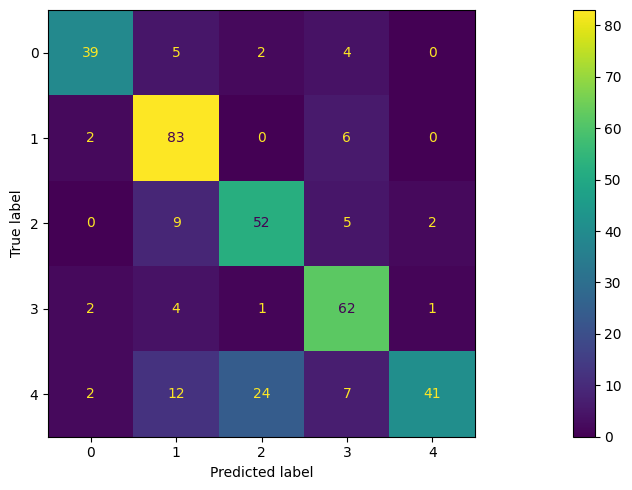

In [50]:
#Print and save confusion matrix
confusion_matrix_model7 = plot_confusion_matrix_report(y_test_cat, y_pred_cat)
confusion_matrix_model7.savefig('confusion_matrix_model7.png')

4 is misclassifying as 1 and 2, indicated by lower recall. Overfitting present.

In [16]:
#Add L1 and L2 regularisation to model 8, 0.001 strength for both, with batch normalisation
model8 = build_cnn_model(width_npix, height_npix, num_classes, batch_norm=True, l1_reg=0.001, l2_reg=0.001)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 254, 254, 64)      1792      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 127, 127, 64)     0         
 )                                                               
                                                                 
 batch_normalization (BatchN  (None, 127, 127, 64)     256       
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 127, 127, 64)      0         
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 128)     73856     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 62, 62, 128)      0

In [17]:
#Train the model for 20 epochs and batch size 64
batch_size = 64 #41 batches (80% of training set (3289 images) = 2631.2 / 64 = 41)
history8 = model8.fit(train_datagen.flow(x_train, y_train_cat,
batch_size = batch_size,
subset = "training"),
epochs = 20, validation_data =
train_datagen.flow(x_train, y_train_cat,
batch_size = batch_size,
subset = "validation"))

Epoch 1/20
42/42 [==============================] - 370s 9s/step - loss: 1.6412 - accuracy: 0.4723 - val_loss: 3.1682 - val_accuracy: 0.2801
Epoch 2/20
42/42 [==============================] - 376s 9s/step - loss: 1.1897 - accuracy: 0.5653 - val_loss: 1.2267 - val_accuracy: 0.4947
Epoch 3/20
42/42 [==============================] - 369s 9s/step - loss: 1.0493 - accuracy: 0.6003 - val_loss: 1.1653 - val_accuracy: 0.5677
Epoch 4/20
42/42 [==============================] - 366s 9s/step - loss: 1.0148 - accuracy: 0.6212 - val_loss: 1.3158 - val_accuracy: 0.5662
Epoch 5/20
42/42 [==============================] - 383s 9s/step - loss: 0.9303 - accuracy: 0.6486 - val_loss: 0.9440 - val_accuracy: 0.6377
Epoch 6/20
42/42 [==============================] - 376s 9s/step - loss: 0.8675 - accuracy: 0.6702 - val_loss: 1.0922 - val_accuracy: 0.6149
Epoch 7/20
42/42 [==============================] - 367s 9s/step - loss: 0.7927 - accuracy: 0.6995 - val_loss: 1.0954 - val_accuracy: 0.6332
Epoch 8/20
42

In [18]:
#Convert history8 to df
history8_df = pd.DataFrame(history8.history)

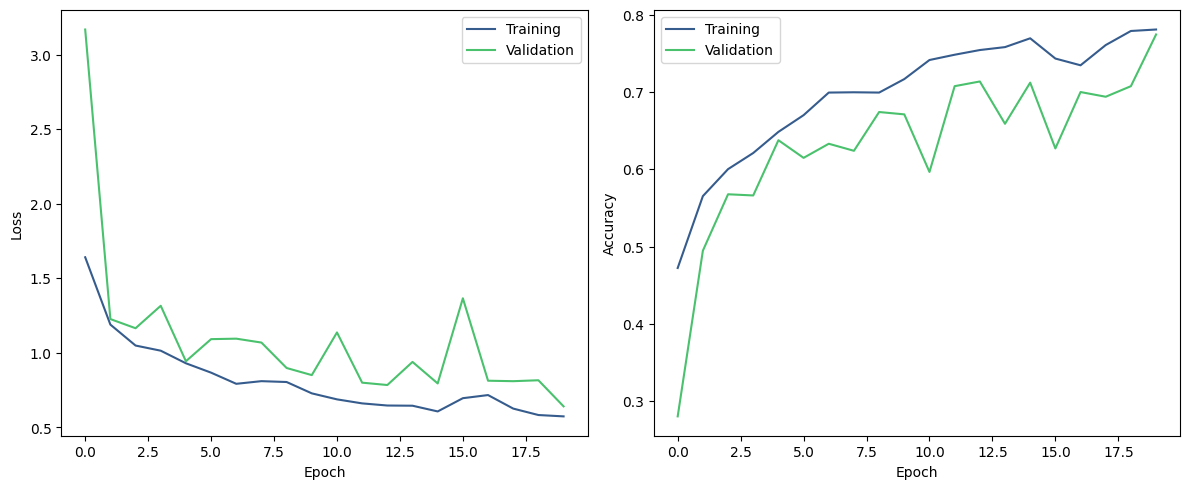

In [19]:
#Print and save accuracy plots
model8_accuracy_loss_plots = plot_training_history(history8_df)
model8_accuracy_loss_plots.savefig('model8_accuracy_loss_plots.png')

In [20]:
#Evalute model on test set
y_pred, y_pred_cat = evaluate_model(model8, x_test, y_test_cat)

12/12 [==============================] - 11s 883ms/step - loss: 0.6216 - accuracy: 0.7671
Overall Accuracy: 76.71%
12/12 [==============================] - 11s 909ms/step


              precision    recall  f1-score   support

           0       0.76      0.84      0.80        50
           1       0.77      0.87      0.82        91
           2       0.62      0.75      0.68        68
           3       0.91      0.74      0.82        70
           4       0.81      0.65      0.72        86

    accuracy                           0.77       365
   macro avg       0.78      0.77      0.77       365
weighted avg       0.78      0.77      0.77       365



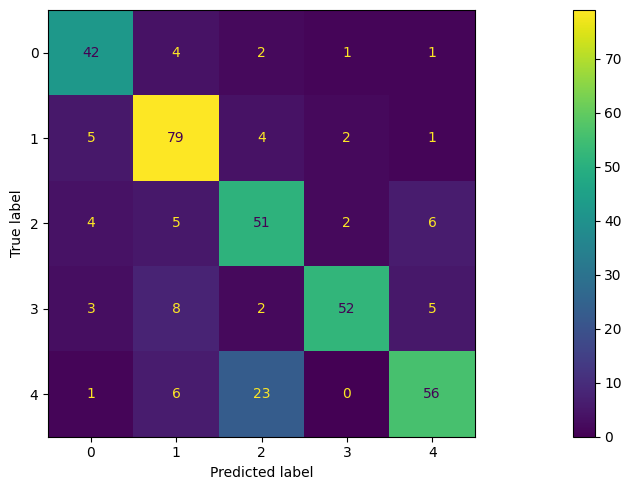

In [21]:
#Print and save confusion matrix
confusion_matrix_model8 = plot_confusion_matrix_report(y_test_cat, y_pred_cat)
confusion_matrix_model8.savefig('confusion_matrix_model8.png')

Accuracy good, model overfitting, 4 misclassified as 2, with lower recall for 4, lower precision for 2.

In [16]:
#L1 and L2 0.001 strength for both, with batch normalisation, dropout reduced to 0.2
model9 = build_cnn_model(width_npix, height_npix, num_classes, batch_norm=True, dropout_rate=0.2, l1_reg=0.001, l2_reg=0.001)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 254, 254, 64)      1792      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 127, 127, 64)     0         
 )                                                               
                                                                 
 batch_normalization (BatchN  (None, 127, 127, 64)     256       
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 127, 127, 64)      0         
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 128)     73856     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 62, 62, 128)      0

In [17]:
#Train the model for 20 epochs and batch size 64
batch_size = 64 #41 batches (80% of training set (3289 images) = 2631.2 / 64 = 41)
history9 = model9.fit(train_datagen.flow(x_train, y_train_cat,
batch_size = batch_size,
subset = "training"),
epochs = 20, validation_data =
train_datagen.flow(x_train, y_train_cat,
batch_size = batch_size,
subset = "validation"))

Epoch 1/20
42/42 [==============================] - 402s 10s/step - loss: 1.7315 - accuracy: 0.4696 - val_loss: 1.9535 - val_accuracy: 0.2831
Epoch 2/20
42/42 [==============================] - 383s 9s/step - loss: 1.1256 - accuracy: 0.5634 - val_loss: 1.3403 - val_accuracy: 0.5312
Epoch 3/20
42/42 [==============================] - 364s 9s/step - loss: 1.0292 - accuracy: 0.6056 - val_loss: 1.2349 - val_accuracy: 0.4992
Epoch 4/20
42/42 [==============================] - 369s 9s/step - loss: 0.9278 - accuracy: 0.6493 - val_loss: 1.1673 - val_accuracy: 0.5936
Epoch 5/20
42/42 [==============================] - 368s 9s/step - loss: 0.9051 - accuracy: 0.6478 - val_loss: 0.8792 - val_accuracy: 0.6636
Epoch 6/20
42/42 [==============================] - 361s 9s/step - loss: 0.8408 - accuracy: 0.6843 - val_loss: 0.8658 - val_accuracy: 0.6819
Epoch 7/20
42/42 [==============================] - 362s 9s/step - loss: 0.7957 - accuracy: 0.7014 - val_loss: 0.8915 - val_accuracy: 0.6773
Epoch 8/20
4

In [18]:
#Convert history9 to df
history9_df = pd.DataFrame(history9.history)

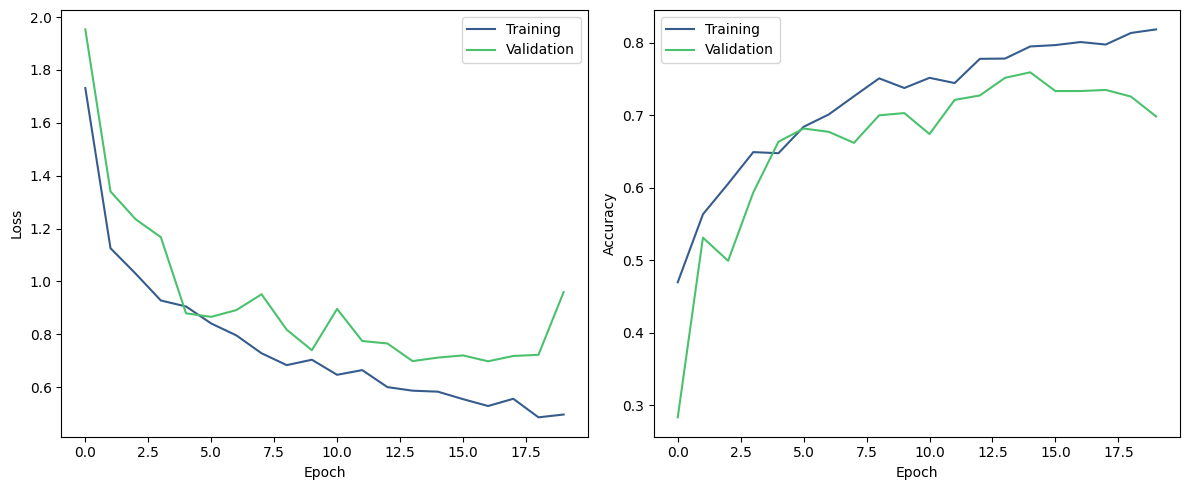

In [19]:
#Print and save accuracy plots
model9_accuracy_loss_plots = plot_training_history(history9_df)
model9_accuracy_loss_plots.savefig('model9_accuracy_loss_plots.png')

In [20]:
#Print metrics
metrics_model9 = print_final_metrics(history9_df)

Final Training Accuracy: 81.88%
Final Validation Accuracy: 69.86%
Final Training Loss: 0.4963
Final Validation Loss: 0.9596


In [21]:
#Evalute model on test set
y_pred, y_pred_cat = evaluate_model(model9, x_test, y_test_cat)

12/12 [==============================] - 11s 905ms/step - loss: 0.9593 - accuracy: 0.7041
Overall Accuracy: 70.41%
12/12 [==============================] - 11s 889ms/step


              precision    recall  f1-score   support

           0       0.57      0.88      0.69        50
           1       0.77      0.82      0.80        91
           2       0.65      0.49      0.55        68
           3       0.67      0.89      0.77        70
           4       0.90      0.50      0.64        86

    accuracy                           0.70       365
   macro avg       0.71      0.72      0.69       365
weighted avg       0.73      0.70      0.70       365



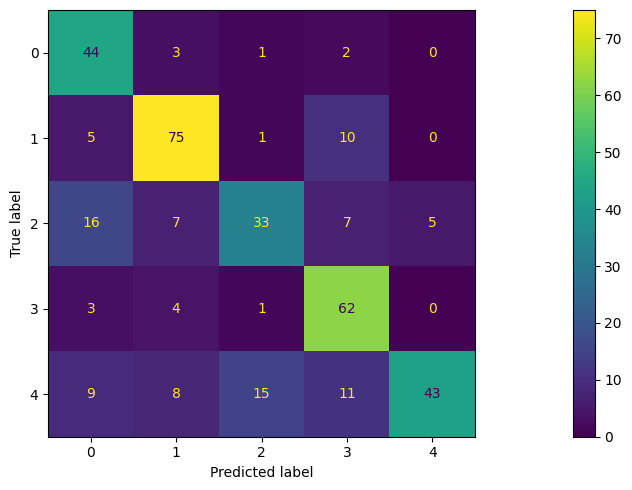

In [22]:
#Print and save confusion matrix
confusion_matrix_model9 = plot_confusion_matrix_report(y_test_cat, y_pred_cat)
confusion_matrix_model9.savefig('confusion_matrix_model9.png')

Accuracy reduced, overfitting present, classification performance reduced. 0 precision reduced and 2 and 4 misclassified with lower recall and fl score.

**Summary of L1 and L2 regularisation**

Dropout of 0.3 seems to be the best value for dropout (better than 0.2 and 0.5)
Need to increase epochs and include early stopping to give model longer to train, to give the models a chance to converge.

0.001 strength appears to better of the L1 and L2 regularisation techniques so will use with early stopping (epochs 40) to see if with more training, there is convergence. The data seems quite noisy, which might be improved with the regularisation technqiues and with further hyperparameter tuning.

*Early stopping*

Tensorflow (2023) tf.keras.callbacks.EarlyStopping. Available online: https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/EarlyStopping [Accessed 16/12/2023].

Monitors performance on validation set during training and stops the training process when the performance stops improving or starts to degrade i.e. starts to overfit.

Monitoring validation loss.

Start with patience of 7

Increase epochs to 40

Dropout rate 0.3

L1 and L2 strength 0.001 with and without

Batch normalisation with and without

In [23]:
#L1 and L2 0.001 strength for both, with batch normalisation, dropout 0.3, early stopping, patience 7, 40 epochs
model10 = build_cnn_model(width_npix, height_npix, num_classes, batch_norm=True, l1_reg=0.001, l2_reg=0.001, early_stopping=True, patience=7)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_5 (Conv2D)           (None, 254, 254, 64)      1792      
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 127, 127, 64)     0         
 2D)                                                             
                                                                 
 batch_normalization_6 (Batc  (None, 127, 127, 64)     256       
 hNormalization)                                                 
                                                                 
 dropout_6 (Dropout)         (None, 127, 127, 64)      0         
                                                                 
 conv2d_6 (Conv2D)           (None, 125, 125, 128)     73856     
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 62, 62, 128)     

In [24]:
#Train the model for 40 epochs and batch size 64
batch_size = 64 #41 batches (80% of training set (3289 images) = 2631.2 / 64 = 41)
history10 = model10.fit(train_datagen.flow(x_train, y_train_cat,
batch_size = batch_size,
subset = "training"),
epochs = 40, validation_data =
train_datagen.flow(x_train, y_train_cat,
batch_size = batch_size,
subset = "validation"))

Epoch 1/40
42/42 [==============================] - 398s 9s/step - loss: 1.6649 - accuracy: 0.4476 - val_loss: 2.6840 - val_accuracy: 0.2801
Epoch 2/40
42/42 [==============================] - 376s 9s/step - loss: 1.1732 - accuracy: 0.5486 - val_loss: 1.3462 - val_accuracy: 0.4901
Epoch 3/40
42/42 [==============================] - 358s 9s/step - loss: 1.0757 - accuracy: 0.5950 - val_loss: 1.1408 - val_accuracy: 0.5616
Epoch 4/40
42/42 [==============================] - 364s 9s/step - loss: 0.9965 - accuracy: 0.6193 - val_loss: 1.0414 - val_accuracy: 0.5708
Epoch 5/40
42/42 [==============================] - 372s 9s/step - loss: 0.9754 - accuracy: 0.6265 - val_loss: 1.2910 - val_accuracy: 0.5084
Epoch 6/40
42/42 [==============================] - 371s 9s/step - loss: 0.9018 - accuracy: 0.6550 - val_loss: 1.0690 - val_accuracy: 0.5830
Epoch 7/40
42/42 [==============================] - 374s 9s/step - loss: 0.8493 - accuracy: 0.6926 - val_loss: 0.9202 - val_accuracy: 0.6362
Epoch 8/40
42

In [25]:
#Convert history10 to df
history10_df = pd.DataFrame(history10.history)

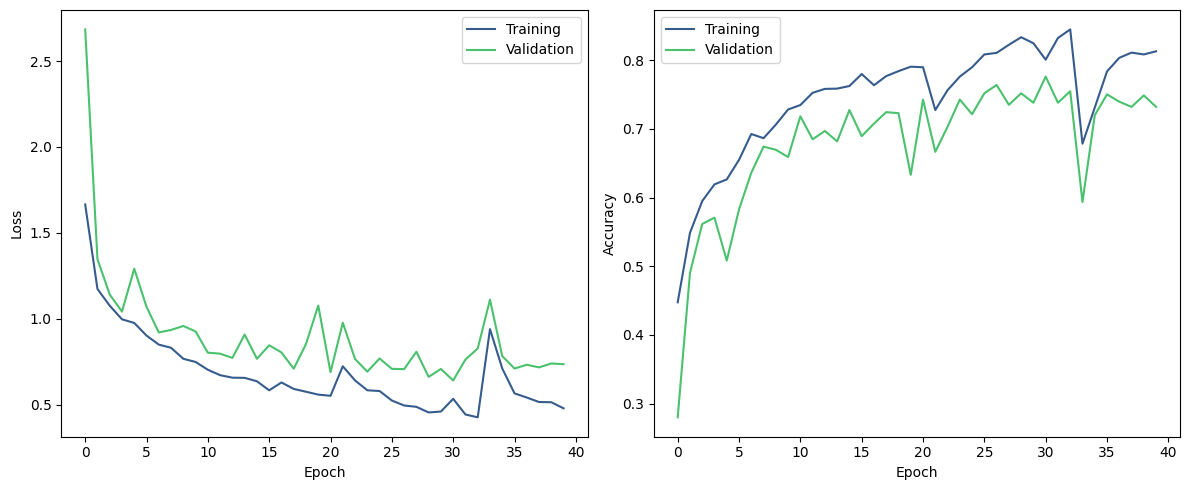

In [26]:
#Print and save accuracy plots
model10_accuracy_loss_plots = plot_training_history(history10_df)
model10_accuracy_loss_plots.savefig('model10_accuracy_loss_plots.png')

In [27]:
#Print metrics
metrics_model10 = print_final_metrics(history10_df)

Final Training Accuracy: 81.31%
Final Validation Accuracy: 73.21%
Final Training Loss: 0.4783
Final Validation Loss: 0.7352


In [28]:
#Evalute model on test set
y_pred, y_pred_cat = evaluate_model(model10, x_test, y_test_cat)

12/12 [==============================] - 10s 812ms/step - loss: 0.7195 - accuracy: 0.7644
Overall Accuracy: 76.44%
12/12 [==============================] - 10s 806ms/step


              precision    recall  f1-score   support

           0       0.65      0.88      0.75        50
           1       0.80      0.84      0.82        91
           2       0.70      0.71      0.70        68
           3       0.83      0.77      0.80        70
           4       0.84      0.66      0.74        86

    accuracy                           0.76       365
   macro avg       0.76      0.77      0.76       365
weighted avg       0.77      0.76      0.76       365



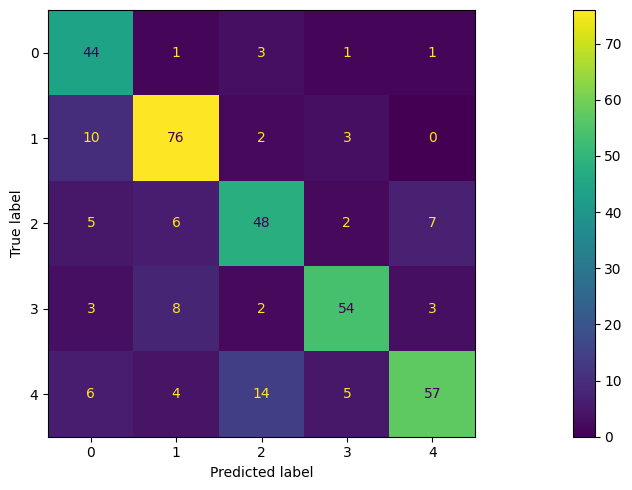

In [29]:
#Print and save confusion matrix
confusion_matrix_model10 = plot_confusion_matrix_report(y_test_cat, y_pred_cat)
confusion_matrix_model10.savefig('confusion_matrix_model10.png')

Overfitting present, good accuracy on test data, 0 lower precision and 4 misclassified, but to lesser extent.

In [16]:
#No L1 and L2 or batch normalisation, dropout 0.3, early stopping, patience 7, 40 epochs
model11 = build_cnn_model(width_npix, height_npix, num_classes, early_stopping=True, patience=7)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 254, 254, 64)      1792      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 127, 127, 64)     0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 127, 127, 64)      0         
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 128)     73856     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 62, 62, 128)      0         
 2D)                                                             
                                                                 
 dropout_1 (Dropout)         (None, 62, 62, 128)       0

In [17]:
#Train the model for 40 epochs and batch size 64
batch_size = 64 #41 batches (80% of training set (3289 images) = 2631.2 / 64 = 41)
history11 = model11.fit(train_datagen.flow(x_train, y_train_cat,
batch_size = batch_size,
subset = "training"),
epochs = 40, validation_data =
train_datagen.flow(x_train, y_train_cat,
batch_size = batch_size,
subset = "validation"))

Epoch 1/40
42/42 [==============================] - 342s 8s/step - loss: 1.7789 - accuracy: 0.2253 - val_loss: 1.5772 - val_accuracy: 0.3318
Epoch 2/40
42/42 [==============================] - 344s 8s/step - loss: 1.4670 - accuracy: 0.3416 - val_loss: 1.3754 - val_accuracy: 0.4977
Epoch 3/40
42/42 [==============================] - 335s 8s/step - loss: 1.2361 - accuracy: 0.4856 - val_loss: 1.2250 - val_accuracy: 0.5251
Epoch 4/40
42/42 [==============================] - 331s 8s/step - loss: 1.1403 - accuracy: 0.5441 - val_loss: 1.1216 - val_accuracy: 0.5556
Epoch 5/40
42/42 [==============================] - 341s 8s/step - loss: 1.0931 - accuracy: 0.5597 - val_loss: 1.0955 - val_accuracy: 0.5495
Epoch 6/40
42/42 [==============================] - 339s 8s/step - loss: 1.0368 - accuracy: 0.5813 - val_loss: 0.9924 - val_accuracy: 0.6104
Epoch 7/40
42/42 [==============================] - 320s 8s/step - loss: 0.9557 - accuracy: 0.6185 - val_loss: 0.9826 - val_accuracy: 0.6164
Epoch 8/40
42

In [18]:
#Convert history11 to df
history11_df = pd.DataFrame(history11.history)

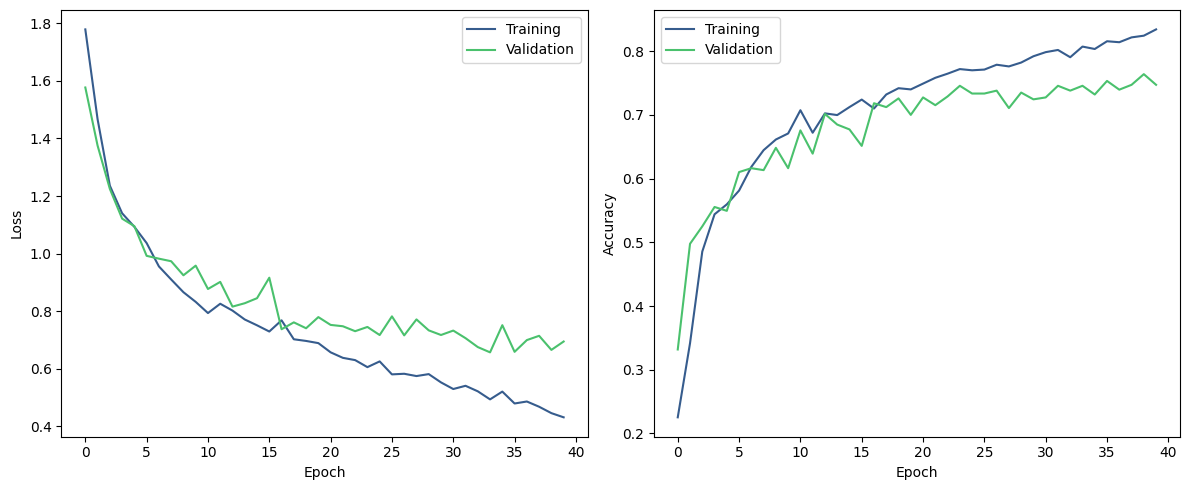

In [19]:
#Print and save accuracy plots
model11_accuracy_loss_plots = plot_training_history(history11_df)
model11_accuracy_loss_plots.savefig('model11_accuracy_loss_plots.png')

In [20]:
#Print metrics
metrics_model11 = print_final_metrics(history11_df)

Final Training Accuracy: 83.43%
Final Validation Accuracy: 74.73%
Final Training Loss: 0.4315
Final Validation Loss: 0.6949


In [21]:
#Evalute model on test set
y_pred, y_pred_cat = evaluate_model(model11, x_test, y_test_cat)

12/12 [==============================] - 12s 974ms/step - loss: 0.7079 - accuracy: 0.7699
Overall Accuracy: 76.99%
12/12 [==============================] - 13s 1s/step


              precision    recall  f1-score   support

           0       0.78      0.90      0.83        50
           1       0.72      0.91      0.80        91
           2       0.75      0.66      0.70        68
           3       0.85      0.80      0.82        70
           4       0.80      0.60      0.69        86

    accuracy                           0.77       365
   macro avg       0.78      0.78      0.77       365
weighted avg       0.78      0.77      0.77       365



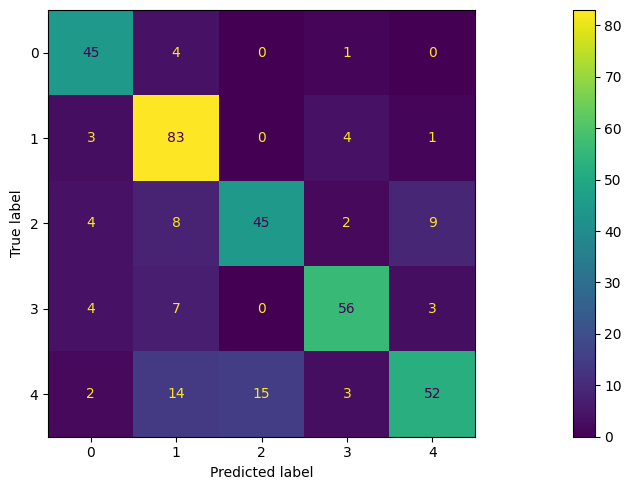

In [22]:
#Print and save confusion matrix
confusion_matrix_model11 = plot_confusion_matrix_report(y_test_cat, y_pred_cat)
confusion_matrix_model11.savefig('confusion_matrix_model11.png')

Overfitting occurs at later epochs, accuracy is good, recall reduced for 2 and 4, but less significant misclassification.

**Summary of adding early stopping**

With and without batch normalisation and L1 and L2 regularisation (0.001). Early stopping was not triggered with a patience of 7. The data seems quite noisy, even with regularisation methods. Further tuning of ealry stopping of patience and min_delta to increase the noise threshold needs to be performed. 

Going to try increasing learning rate to encourage convergence and stability. Will try with regularisation (batch norm and L1 and L2 0.01 and 0.001).

*Learning rate*

The loss curve seems quite noisy still, it may be that the learning rate needs adjusting. will try increasing from 0.001 (default) to 0.01. I am going to try on 1l and 12 regularisation 0f 0.01 with batch normalisation and without L1 and L2.

Tensorflow (2023) tf.keras.optimizers.Adam. Available online: https://www.tensorflow.org/api_docs/python/tf/keras/optimizers/Adam [Accessed 16/12/2023].

In [16]:
#Learning rate set to 0.01 (default is 0.001)
adam_optimizer = Adam(learning_rate = 0.01)

In [17]:
#Adam is 0.01, L1 and L2 0.01 strength for both, with batch normalisation, dropout 0.3, 40 epochs
model12 = build_cnn_model(width_npix, height_npix, num_classes, batch_norm=True, optimizer=adam_optimizer, l1_reg=0.01, l2_reg=0.01)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 254, 254, 64)      1792      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 127, 127, 64)     0         
 )                                                               
                                                                 
 batch_normalization (BatchN  (None, 127, 127, 64)     256       
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 127, 127, 64)      0         
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 128)     73856     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 62, 62, 128)      0

In [19]:
#Train the model for 40 epochs and batch size 64
batch_size = 64 #41 batches (80% of training set (3289 images) = 2631.2 / 64 = 41)
history12 = model12.fit(train_datagen.flow(x_train, y_train_cat,
batch_size = batch_size,
subset = "training"),
epochs = 40, validation_data =
train_datagen.flow(x_train, y_train_cat,
batch_size = batch_size,
subset = "validation"))

Epoch 1/40
42/42 [==============================] - 377s 9s/step - loss: 1.3482 - accuracy: 0.5144 - val_loss: 1.3922 - val_accuracy: 0.4399
Epoch 2/40
42/42 [==============================] - 393s 9s/step - loss: 1.3104 - accuracy: 0.5118 - val_loss: 1.1249 - val_accuracy: 0.5586
Epoch 3/40
42/42 [==============================] - 402s 10s/step - loss: 1.1786 - accuracy: 0.5699 - val_loss: 1.1681 - val_accuracy: 0.5510
Epoch 4/40
42/42 [==============================] - 387s 9s/step - loss: 1.1336 - accuracy: 0.5760 - val_loss: 1.0487 - val_accuracy: 0.6012
Epoch 5/40
42/42 [==============================] - 408s 10s/step - loss: 1.0539 - accuracy: 0.5980 - val_loss: 1.1402 - val_accuracy: 0.5723
Epoch 6/40
42/42 [==============================] - 382s 9s/step - loss: 1.1495 - accuracy: 0.5627 - val_loss: 1.1256 - val_accuracy: 0.5845
Epoch 7/40
42/42 [==============================] - 374s 9s/step - loss: 1.0628 - accuracy: 0.6068 - val_loss: 1.0431 - val_accuracy: 0.5982
Epoch 8/40


In [20]:
#Convert history12 to df
history12_df = pd.DataFrame(history12.history)

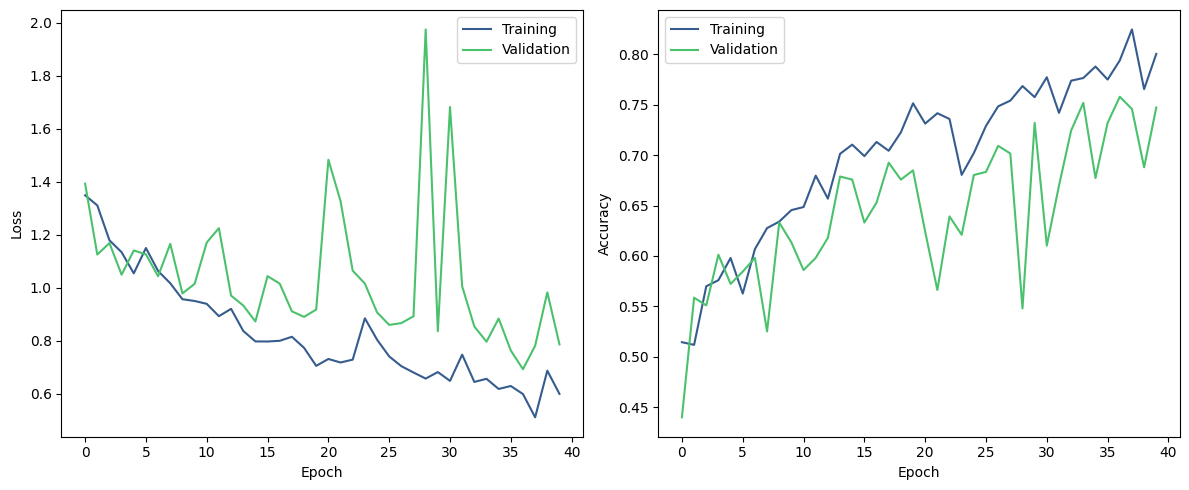

In [21]:
#Print and save accuracy plots
model12_accuracy_loss_plots = plot_training_history(history12_df)
model12_accuracy_loss_plots.savefig('model12_accuracy_loss_plots.png')

In [22]:
#Print metrics
metrics_model12 = print_final_metrics(history12_df)

Final Training Accuracy: 80.05%
Final Validation Accuracy: 74.73%
Final Training Loss: 0.5992
Final Validation Loss: 0.7860


In [23]:
#Evalute model on test set
y_pred, y_pred_cat = evaluate_model(model12, x_test, y_test_cat)

12/12 [==============================] - 12s 955ms/step - loss: 0.7529 - accuracy: 0.7479
Overall Accuracy: 74.79%
12/12 [==============================] - 11s 922ms/step


              precision    recall  f1-score   support

           0       0.83      0.76      0.79        50
           1       0.73      0.81      0.77        91
           2       0.63      0.76      0.69        68
           3       0.73      0.83      0.78        70
           4       0.91      0.59      0.72        86

    accuracy                           0.75       365
   macro avg       0.77      0.75      0.75       365
weighted avg       0.77      0.75      0.75       365



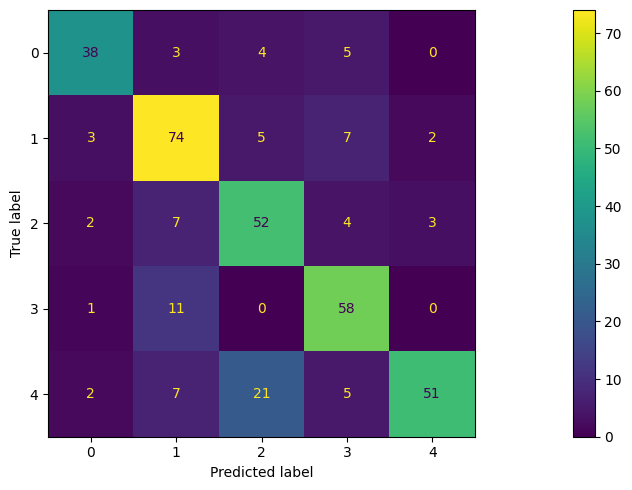

In [24]:
#Print and save confusion matrix
confusion_matrix_model12 = plot_confusion_matrix_report(y_test_cat, y_pred_cat)
confusion_matrix_model12.savefig('confusion_matrix_model12.png')

Overfitting present, accuracy ok but slightly reduced compared to 0.001 learning rate, misclassifying 4 as 2 indicated by reduced recall and precision, respectively.

In [27]:
#Adam is 0.01, l1 and l2 0.001, batch norm, dropout 0.3, 40 epochs
model13 = build_cnn_model(width_npix, height_npix, num_classes, batch_norm=True, optimizer=adam_optimizer, l1_reg=0.001, l2_reg=0.001)

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_10 (Conv2D)          (None, 254, 254, 64)      1792      
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, 127, 127, 64)     0         
 g2D)                                                            
                                                                 
 batch_normalization_6 (Batc  (None, 127, 127, 64)     256       
 hNormalization)                                                 
                                                                 
 dropout_12 (Dropout)        (None, 127, 127, 64)      0         
                                                                 
 conv2d_11 (Conv2D)          (None, 125, 125, 128)     73856     
                                                                 
 max_pooling2d_11 (MaxPoolin  (None, 62, 62, 128)     

In [28]:
#Train the model for 40 epochs and batch size 64
batch_size = 64 #41 batches (80% of training set (3289 images) = 2631.2 / 64 = 41)
history13 = model13.fit(train_datagen.flow(x_train, y_train_cat,
batch_size = batch_size,
subset = "training"),
epochs = 40, validation_data =
train_datagen.flow(x_train, y_train_cat,
batch_size = batch_size,
subset = "validation"))

Epoch 1/40
42/42 [==============================] - 413s 10s/step - loss: 2.9277 - accuracy: 0.3514 - val_loss: 1.8336 - val_accuracy: 0.4414
Epoch 2/40
42/42 [==============================] - 432s 10s/step - loss: 1.5588 - accuracy: 0.4430 - val_loss: 1.3774 - val_accuracy: 0.4323
Epoch 3/40
42/42 [==============================] - 407s 10s/step - loss: 1.3378 - accuracy: 0.4597 - val_loss: 1.1871 - val_accuracy: 0.5099
Epoch 4/40
42/42 [==============================] - 421s 10s/step - loss: 1.2280 - accuracy: 0.4970 - val_loss: 1.2367 - val_accuracy: 0.4825
Epoch 5/40
42/42 [==============================] - 434s 10s/step - loss: 1.1411 - accuracy: 0.5323 - val_loss: 1.1028 - val_accuracy: 0.5419
Epoch 6/40
42/42 [==============================] - 423s 10s/step - loss: 1.1029 - accuracy: 0.5391 - val_loss: 1.0632 - val_accuracy: 0.5845
Epoch 7/40
42/42 [==============================] - 455s 11s/step - loss: 1.0733 - accuracy: 0.5634 - val_loss: 1.0826 - val_accuracy: 0.5647
Epoch 

In [29]:
#Convert history13 to df
history13_df = pd.DataFrame(history13.history)

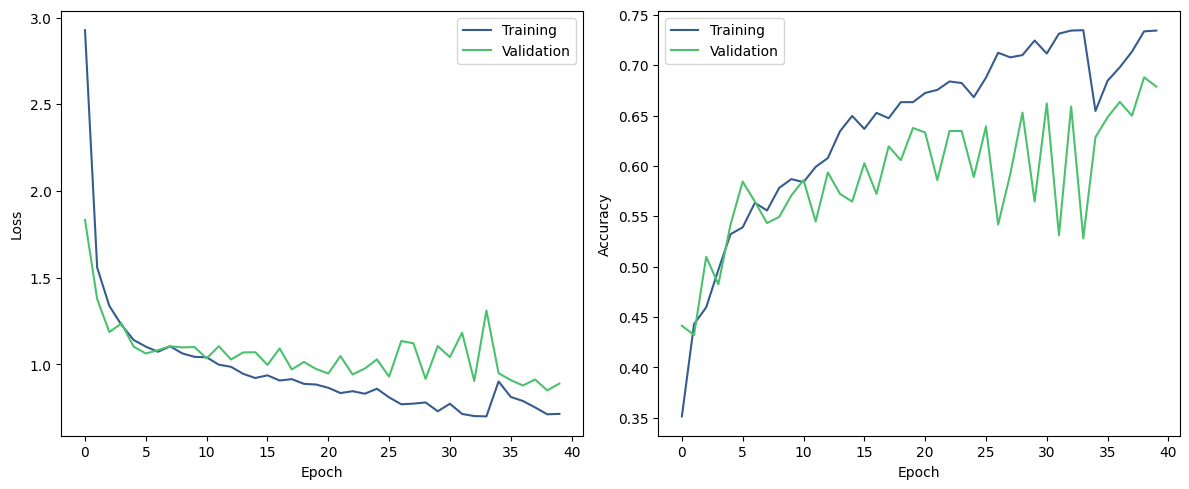

In [30]:
#Print and save accuracy plots
model13_accuracy_loss_plots = plot_training_history(history13_df)
model13_accuracy_loss_plots.savefig('model13_accuracy_loss_plots.png')

In [31]:
#Print metrics
metrics_model13 = print_final_metrics(history13_df)

Final Training Accuracy: 73.44%
Final Validation Accuracy: 67.88%
Final Training Loss: 0.7151
Final Validation Loss: 0.8901


In [32]:
#Evalute model on test set
y_pred, y_pred_cat = evaluate_model(model13, x_test, y_test_cat)

12/12 [==============================] - 22s 2s/step - loss: 0.8810 - accuracy: 0.7014
Overall Accuracy: 70.14%
12/12 [==============================] - 19s 2s/step


              precision    recall  f1-score   support

           0       0.84      0.72      0.77        50
           1       0.63      0.88      0.73        91
           2       0.59      0.54      0.56        68
           3       0.82      0.90      0.86        70
           4       0.73      0.47      0.57        86

    accuracy                           0.70       365
   macro avg       0.72      0.70      0.70       365
weighted avg       0.71      0.70      0.69       365



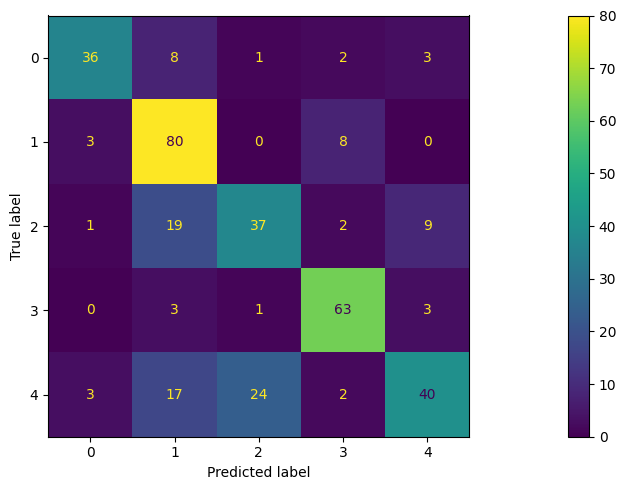

In [33]:
#Print and save confusion matrix
confusion_matrix_model13 = plot_confusion_matrix_report(y_test_cat, y_pred_cat)
confusion_matrix_model13.savefig('confusion_matrix_model13.png')

Slightly reduced accuracy, overfitting, classification performance poorer.

In [34]:
#Adam is 0.01, no L1 and L2, with batch normalisation, dropout 0.3, 40 epochs
model14 = build_cnn_model(width_npix, height_npix, num_classes, batch_norm=True, optimizer=adam_optimizer)

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_15 (Conv2D)          (None, 254, 254, 64)      1792      
                                                                 
 max_pooling2d_15 (MaxPoolin  (None, 127, 127, 64)     0         
 g2D)                                                            
                                                                 
 batch_normalization_12 (Bat  (None, 127, 127, 64)     256       
 chNormalization)                                                
                                                                 
 dropout_18 (Dropout)        (None, 127, 127, 64)      0         
                                                                 
 conv2d_16 (Conv2D)          (None, 125, 125, 128)     73856     
                                                                 
 max_pooling2d_16 (MaxPoolin  (None, 62, 62, 128)     

In [35]:
#Train the model for 40 epochs and batch size 64
batch_size = 64 #41 batches (80% of training set (3289 images) = 2631.2 / 64 = 41)
history14 = model14.fit(train_datagen.flow(x_train, y_train_cat,
batch_size = batch_size,
subset = "training"),
epochs = 40, validation_data =
train_datagen.flow(x_train, y_train_cat,
batch_size = batch_size,
subset = "validation"))

Epoch 1/40
42/42 [==============================] - 564s 13s/step - loss: 2.7819 - accuracy: 0.3359 - val_loss: 1.6437 - val_accuracy: 0.4216
Epoch 2/40
42/42 [==============================] - 463s 11s/step - loss: 1.4258 - accuracy: 0.4681 - val_loss: 1.1876 - val_accuracy: 0.4962
Epoch 3/40
42/42 [==============================] - 458s 11s/step - loss: 1.1943 - accuracy: 0.5357 - val_loss: 1.1507 - val_accuracy: 0.5236
Epoch 4/40
42/42 [==============================] - 465s 11s/step - loss: 1.1266 - accuracy: 0.5509 - val_loss: 1.0468 - val_accuracy: 0.5693
Epoch 5/40
42/42 [==============================] - 446s 11s/step - loss: 1.0446 - accuracy: 0.5691 - val_loss: 1.1421 - val_accuracy: 0.5388
Epoch 6/40
42/42 [==============================] - 423s 10s/step - loss: 1.0430 - accuracy: 0.5832 - val_loss: 1.0714 - val_accuracy: 0.5586
Epoch 7/40
42/42 [==============================] - 429s 10s/step - loss: 1.0270 - accuracy: 0.5900 - val_loss: 1.2096 - val_accuracy: 0.5449
Epoch 

In [36]:
#Convert history14 to df
history14_df = pd.DataFrame(history14.history)

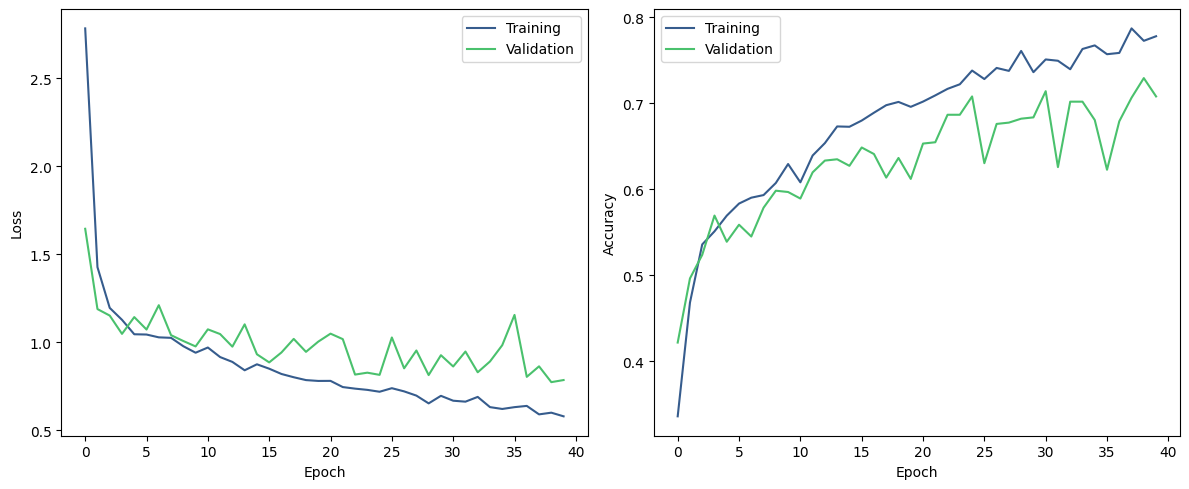

In [37]:
#Print and save accuracy plots
model14_accuracy_loss_plots = plot_training_history(history14_df)
model14_accuracy_loss_plots.savefig('model14_accuracy_loss_plots.png')

In [38]:
#Print metrics
metrics_model14 = print_final_metrics(history14_df)

Final Training Accuracy: 77.77%
Final Validation Accuracy: 70.78%
Final Training Loss: 0.5784
Final Validation Loss: 0.7845


In [39]:
#Evalute model on test set
y_pred, y_pred_cat = evaluate_model(model14, x_test, y_test_cat)

12/12 [==============================] - 10s 814ms/step - loss: 0.6815 - accuracy: 0.7452
Overall Accuracy: 74.52%
12/12 [==============================] - 10s 806ms/step


              precision    recall  f1-score   support

           0       0.80      0.66      0.73        50
           1       0.67      0.91      0.77        91
           2       0.73      0.54      0.62        68
           3       0.88      0.83      0.85        70
           4       0.73      0.71      0.72        86

    accuracy                           0.75       365
   macro avg       0.76      0.73      0.74       365
weighted avg       0.75      0.75      0.74       365



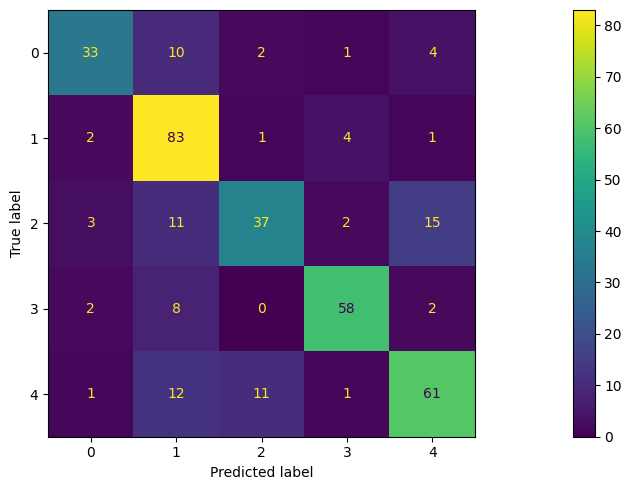

In [40]:
#Print and save confusion matrix
confusion_matrix_model14 = plot_confusion_matrix_report(y_test_cat, y_pred_cat)
confusion_matrix_model14.savefig('confusion_matrix_model14.png')

Classification poorer for 2 and 4 (lower recall), overfitting evident, OK accuracy.

In [41]:
#Adam is default 0.001, no L1 and L2, with batch normalisation, dropout 0.3, 40 epochs
model15 = build_cnn_model(width_npix, height_npix, num_classes, batch_norm=True)

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_20 (Conv2D)          (None, 254, 254, 64)      1792      
                                                                 
 max_pooling2d_20 (MaxPoolin  (None, 127, 127, 64)     0         
 g2D)                                                            
                                                                 
 batch_normalization_18 (Bat  (None, 127, 127, 64)     256       
 chNormalization)                                                
                                                                 
 dropout_24 (Dropout)        (None, 127, 127, 64)      0         
                                                                 
 conv2d_21 (Conv2D)          (None, 125, 125, 128)     73856     
                                                                 
 max_pooling2d_21 (MaxPoolin  (None, 62, 62, 128)     

In [42]:
#Train the model for 40 epochs and batch size 64
batch_size = 64 #41 batches (80% of training set (3289 images) = 2631.2 / 64 = 41)
history15 = model15.fit(train_datagen.flow(x_train, y_train_cat,
batch_size = batch_size,
subset = "training"),
epochs = 40, validation_data =
train_datagen.flow(x_train, y_train_cat,
batch_size = batch_size,
subset = "validation"))

Epoch 1/40
42/42 [==============================] - 390s 9s/step - loss: 1.5892 - accuracy: 0.4715 - val_loss: 2.4272 - val_accuracy: 0.2938
Epoch 2/40
42/42 [==============================] - 372s 9s/step - loss: 1.1341 - accuracy: 0.5574 - val_loss: 1.3452 - val_accuracy: 0.4536
Epoch 3/40
42/42 [==============================] - 366s 9s/step - loss: 1.0602 - accuracy: 0.6014 - val_loss: 1.2014 - val_accuracy: 0.5312
Epoch 4/40
42/42 [==============================] - 379s 9s/step - loss: 0.9771 - accuracy: 0.6296 - val_loss: 1.3810 - val_accuracy: 0.5053
Epoch 5/40
42/42 [==============================] - 369s 9s/step - loss: 0.9482 - accuracy: 0.6474 - val_loss: 1.1139 - val_accuracy: 0.5982
Epoch 6/40
42/42 [==============================] - 378s 9s/step - loss: 0.9096 - accuracy: 0.6565 - val_loss: 1.0108 - val_accuracy: 0.6073
Epoch 7/40
42/42 [==============================] - 373s 9s/step - loss: 0.8025 - accuracy: 0.7025 - val_loss: 1.0061 - val_accuracy: 0.6104
Epoch 8/40
42

In [43]:
#Convert history15 to df
history15_df = pd.DataFrame(history15.history)

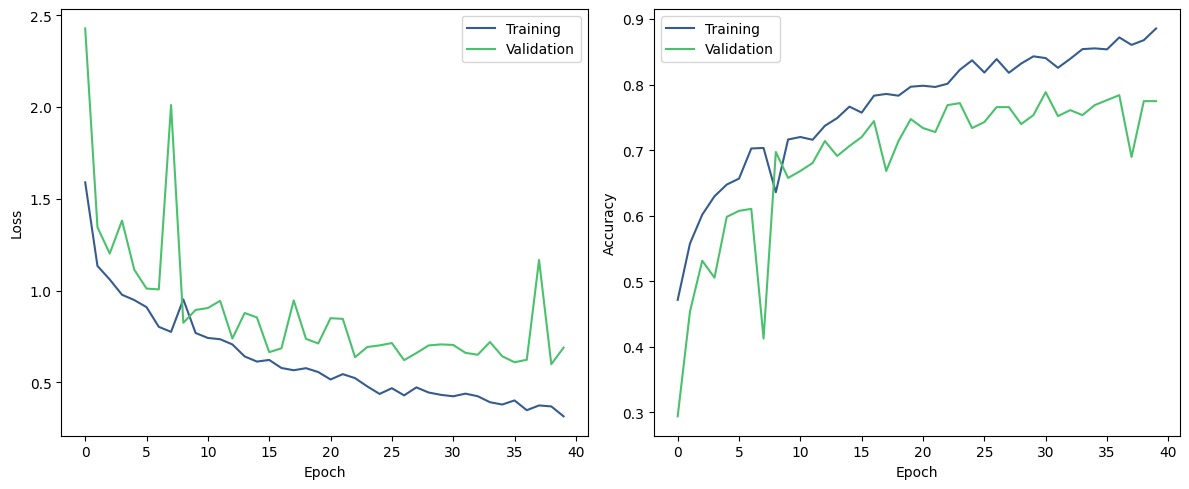

In [44]:
#Print and save accuracy plots
model15_accuracy_loss_plots = plot_training_history(history15_df)
model15_accuracy_loss_plots.savefig('model15_accuracy_loss_plots.png')

In [45]:
#Print metrics
metrics_model15 = print_final_metrics(history15_df)

Final Training Accuracy: 88.56%
Final Validation Accuracy: 77.47%
Final Training Loss: 0.3151
Final Validation Loss: 0.6891


In [46]:
#Evalute model on test set
y_pred, y_pred_cat = evaluate_model(model15, x_test, y_test_cat)

12/12 [==============================] - 10s 811ms/step - loss: 0.6775 - accuracy: 0.8110
Overall Accuracy: 81.10%
12/12 [==============================] - 10s 847ms/step


              precision    recall  f1-score   support

           0       0.79      0.82      0.80        50
           1       0.80      0.90      0.85        91
           2       0.70      0.79      0.74        68
           3       0.89      0.89      0.89        70
           4       0.89      0.66      0.76        86

    accuracy                           0.81       365
   macro avg       0.81      0.81      0.81       365
weighted avg       0.82      0.81      0.81       365



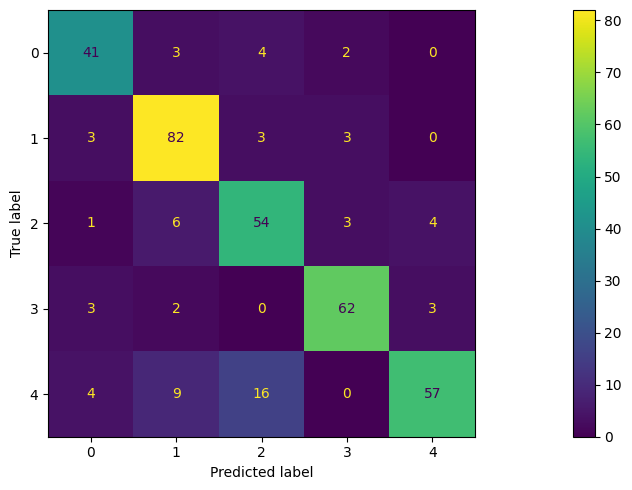

In [47]:
#Print and save confusion matrix
confusion_matrix_model15 = plot_confusion_matrix_report(y_test_cat, y_pred_cat)
confusion_matrix_model15.savefig('confusion_matrix_model15.png')

Overfitting present, really good test data accuracy, classification good, lowest recall for 4 (misclassified as 2/1).

*Summary of learning rate*

Increasing learning rate did not increase accuracy and caused overfitting. Adam learning rate (0.001) seems to increase accuracy for this data set (although overfitting was present with batch normalisation alone).

*Batch size*

Try 32 and 128 with and without batch normalisation.

Dropout 0.3, adam optimiser (0.001).

Reducing or increasing the number of data samples processed in each iteration of training.

Smaller batch sizes lead to faster training iterations, as each iteration processes fewer data samples and consume less memory during training. 

With a smaller batch size, the model parameters are updated more frequently, introduce more noise into the training process, which can act as a form of regularisation, which may help prevent overfitting.

Changing the batch size may require adjusting the learning rate. Smaller batch sizes may benefit from a smaller learning rate to prevent overshooting.

Reference:

Kandel, I. & Castelli, M. (2020) The effect of batch size on the generalizability of the convolutional neural networks on a histopathology dataset. ICT Express, 6(4), 312-315.

In [22]:
#Adam is 0.001 (default), no L1 and L2, with batch normalisation, dropout 0.3
model16 = build_cnn_model(width_npix, height_npix, num_classes, batch_norm=True)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_5 (Conv2D)           (None, 254, 254, 64)      1792      
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 127, 127, 64)     0         
 2D)                                                             
                                                                 
 batch_normalization (BatchN  (None, 127, 127, 64)     256       
 ormalization)                                                   
                                                                 
 dropout_6 (Dropout)         (None, 127, 127, 64)      0         
                                                                 
 conv2d_6 (Conv2D)           (None, 125, 125, 128)     73856     
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 62, 62, 128)     

In [17]:
#Train the model for 30 epochs and batch size 32
batch_size = 32 #82 batches (80% of training set (3289 images) = 2631.2 / 32 = 82)
history16 = model16.fit(train_datagen.flow(x_train, y_train_cat,
batch_size = batch_size,
subset = "training"),
epochs = 30, validation_data =
train_datagen.flow(x_train, y_train_cat,
batch_size = batch_size,
subset = "validation"))

Epoch 1/30
83/83 [==============================] - 384s 5s/step - loss: 1.5519 - accuracy: 0.4719 - val_loss: 1.1852 - val_accuracy: 0.5190
Epoch 2/30
83/83 [==============================] - 403s 5s/step - loss: 1.1918 - accuracy: 0.5410 - val_loss: 1.1474 - val_accuracy: 0.5251
Epoch 3/30
83/83 [==============================] - 379s 5s/step - loss: 1.0464 - accuracy: 0.6098 - val_loss: 1.5703 - val_accuracy: 0.4855
Epoch 4/30
83/83 [==============================] - 382s 5s/step - loss: 0.9877 - accuracy: 0.6269 - val_loss: 1.0829 - val_accuracy: 0.6027
Epoch 5/30
83/83 [==============================] - 379s 5s/step - loss: 0.8839 - accuracy: 0.6676 - val_loss: 1.0540 - val_accuracy: 0.6149
Epoch 6/30
83/83 [==============================] - 368s 4s/step - loss: 0.8603 - accuracy: 0.6729 - val_loss: 0.9053 - val_accuracy: 0.6667
Epoch 7/30
83/83 [==============================] - 370s 4s/step - loss: 0.8174 - accuracy: 0.6998 - val_loss: 0.8925 - val_accuracy: 0.6591
Epoch 8/30
83

In [18]:
#Convert history16 to df
history16_df = pd.DataFrame(history16.history)

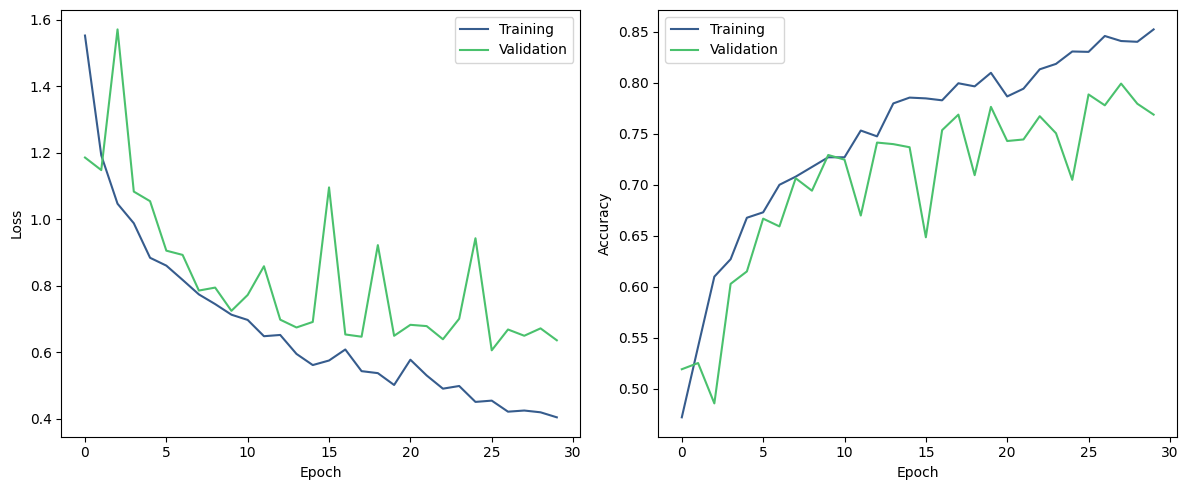

In [19]:
#Print and save accuracy plots
model16_accuracy_loss_plots = plot_training_history(history16_df)
model16_accuracy_loss_plots.savefig('model16_accuracy_loss_plots.png')

In [20]:
#Print metrics
metrics_model16 = print_final_metrics(history16_df)

Final Training Accuracy: 85.22%
Final Validation Accuracy: 76.86%
Final Training Loss: 0.4043
Final Validation Loss: 0.6358


In [21]:
#Evalute model on test set
y_pred, y_pred_cat = evaluate_model(model16, x_test, y_test_cat)

12/12 [==============================] - 10s 810ms/step - loss: 0.7237 - accuracy: 0.7616
Overall Accuracy: 76.16%
12/12 [==============================] - 10s 778ms/step


              precision    recall  f1-score   support

           0       0.67      0.88      0.76        50
           1       0.84      0.80      0.82        91
           2       0.60      0.76      0.68        68
           3       0.89      0.83      0.86        70
           4       0.84      0.59      0.69        86

    accuracy                           0.76       365
   macro avg       0.77      0.77      0.76       365
weighted avg       0.78      0.76      0.76       365



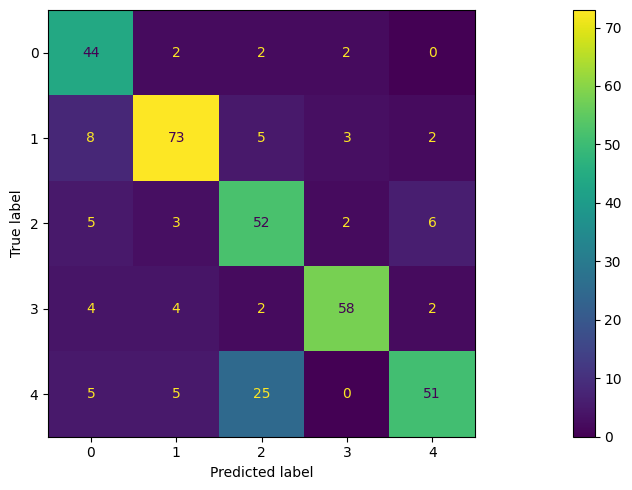

In [22]:
#Print and save confusion matrix
confusion_matrix_model16 = plot_confusion_matrix_report(y_test_cat, y_pred_cat)
confusion_matrix_model16.savefig('confusion_matrix_model16.png')

Overfitting, good accuracy, misclassifying 4 for 2 (lower recall and precision, respectively).

In [23]:
#Train the model for 30 epochs and batch size 128
batch_size = 128 #21 batches (80% of training set (3289 images) = 2631.2 / 128 = 21)
history17 = model16.fit(train_datagen.flow(x_train, y_train_cat,
batch_size = batch_size,
subset = "training"),
epochs = 30, validation_data =
train_datagen.flow(x_train, y_train_cat,
batch_size = batch_size,
subset = "validation"))

Epoch 1/30
21/21 [==============================] - 375s 18s/step - loss: 1.8392 - accuracy: 0.4392 - val_loss: 2.7461 - val_accuracy: 0.2725
Epoch 2/30
21/21 [==============================] - 360s 17s/step - loss: 1.1807 - accuracy: 0.5532 - val_loss: 1.7644 - val_accuracy: 0.3272
Epoch 3/30
21/21 [==============================] - 386s 18s/step - loss: 1.0689 - accuracy: 0.5897 - val_loss: 1.5682 - val_accuracy: 0.4444
Epoch 4/30
21/21 [==============================] - 415s 20s/step - loss: 1.0069 - accuracy: 0.6189 - val_loss: 1.1798 - val_accuracy: 0.5556
Epoch 5/30
21/21 [==============================] - 378s 18s/step - loss: 0.9543 - accuracy: 0.6417 - val_loss: 1.3461 - val_accuracy: 0.4764
Epoch 6/30
21/21 [==============================] - 371s 18s/step - loss: 0.9251 - accuracy: 0.6539 - val_loss: 1.2392 - val_accuracy: 0.5616
Epoch 7/30
21/21 [==============================] - 371s 18s/step - loss: 0.8812 - accuracy: 0.6577 - val_loss: 1.0481 - val_accuracy: 0.5967
Epoch 

In [24]:
#Convert history17 to df
history17_df = pd.DataFrame(history17.history)

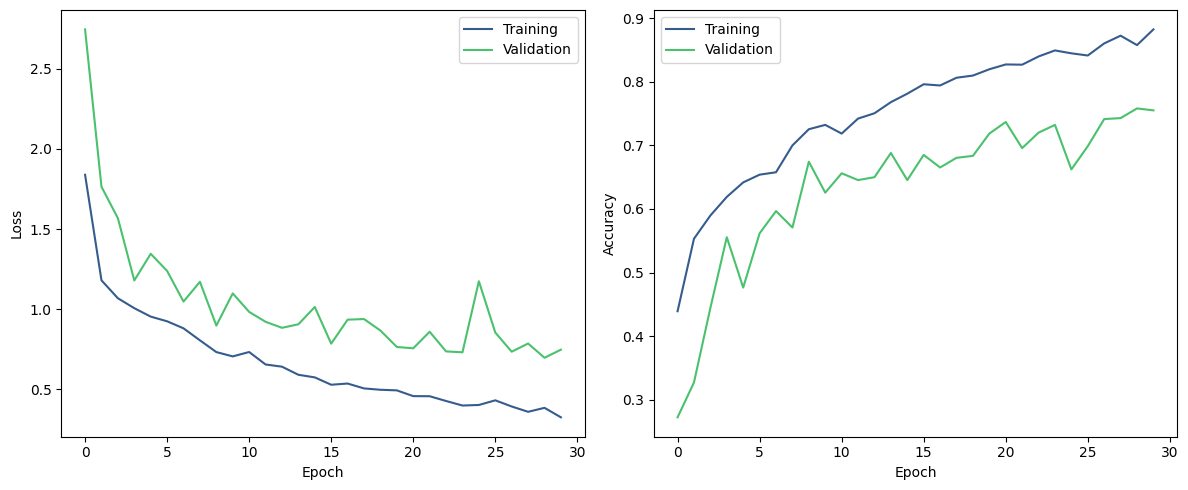

In [25]:
#Print and save accuracy plots
model16_128_accuracy_loss_plots = plot_training_history(history17_df)
model16_128_accuracy_loss_plots.savefig('model16_128_accuracy_loss_plots.png')

In [26]:
#Print metrics
metrics_model16_128 = print_final_metrics(history17_df)

Final Training Accuracy: 96.62%
Final Validation Accuracy: 81.28%
Final Training Loss: 0.0949
Final Validation Loss: 0.6284


In [27]:
#Evalute model on test set
y_pred, y_pred_cat = evaluate_model(model16, x_test, y_test_cat)

12/12 [==============================] - 10s 788ms/step - loss: 0.6548 - accuracy: 0.7945
Overall Accuracy: 79.45%
12/12 [==============================] - 9s 783ms/step


              precision    recall  f1-score   support

           0       0.79      0.84      0.82        50
           1       0.81      0.87      0.84        91
           2       0.70      0.72      0.71        68
           3       0.89      0.73      0.80        70
           4       0.79      0.80      0.80        86

    accuracy                           0.79       365
   macro avg       0.80      0.79      0.79       365
weighted avg       0.80      0.79      0.79       365



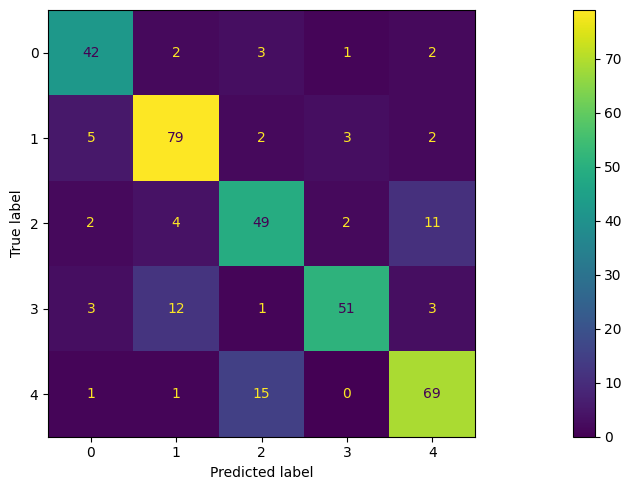

In [28]:
#Print and save confusion matrix
confusion_matrix_model16_128 = plot_confusion_matrix_report(y_test_cat, y_pred_cat)
confusion_matrix_model16_128.savefig('confusion_matrix_model16_128.png')

Overfitting more pronounced, accuracy good, classification pretty good, consufing 2 and 4 and 3 with 1, but to lesser extent.

*Without batch normalisation batch size 32 or 128*

In [18]:
#Adam is 0.001 (default), no L1 and L2, without batch normalisation, dropout 0.3, 30 epochs
model17 = build_cnn_model(width_npix, height_npix, num_classes)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 254, 254, 64)      1792      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 127, 127, 64)     0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 127, 127, 64)      0         
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 128)     73856     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 62, 62, 128)      0         
 2D)                                                             
                                                                 
 dropout_1 (Dropout)         (None, 62, 62, 128)       0

In [17]:
#Train the model for 30 epochs and batch size 32
batch_size = 32 #82 batches (80% of training set (3289 images) = 2631.2 / 32 = 82)
history18 = model17.fit(train_datagen.flow(x_train, y_train_cat,
batch_size = batch_size,
subset = "training"),
epochs = 30, validation_data =
train_datagen.flow(x_train, y_train_cat,
batch_size = batch_size,
subset = "validation"))

Epoch 1/30
83/83 [==============================] - 323s 4s/step - loss: 1.6334 - accuracy: 0.2489 - val_loss: 1.5485 - val_accuracy: 0.2694
Epoch 2/30
83/83 [==============================] - 323s 4s/step - loss: 1.3346 - accuracy: 0.4331 - val_loss: 1.1550 - val_accuracy: 0.4871
Epoch 3/30
83/83 [==============================] - 326s 4s/step - loss: 1.1318 - accuracy: 0.5236 - val_loss: 1.1217 - val_accuracy: 0.5434
Epoch 4/30
83/83 [==============================] - 310s 4s/step - loss: 1.0305 - accuracy: 0.5912 - val_loss: 1.1042 - val_accuracy: 0.5708
Epoch 5/30
83/83 [==============================] - 324s 4s/step - loss: 0.9823 - accuracy: 0.6182 - val_loss: 0.9156 - val_accuracy: 0.6499
Epoch 6/30
83/83 [==============================] - 314s 4s/step - loss: 0.8995 - accuracy: 0.6565 - val_loss: 0.9313 - val_accuracy: 0.6377
Epoch 7/30
83/83 [==============================] - 323s 4s/step - loss: 0.8863 - accuracy: 0.6596 - val_loss: 0.9988 - val_accuracy: 0.6286
Epoch 8/30
83

In [18]:
#Convert history18 to df
history18_df = pd.DataFrame(history18.history)

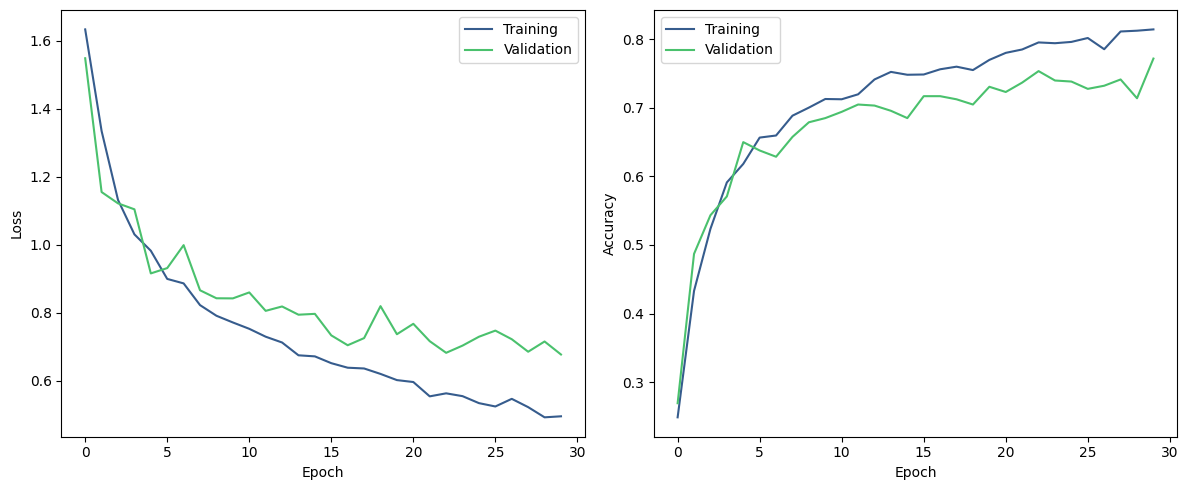

In [19]:
#Print and save accuracy plots
model17_accuracy_loss_plots = plot_training_history(history18_df)
model17_accuracy_loss_plots.savefig('model17_accuracy_loss_plots.png')

In [20]:
#Print metrics
metrics_model17 = print_final_metrics(history18_df)

Final Training Accuracy: 81.42%
Final Validation Accuracy: 77.17%
Final Training Loss: 0.4953
Final Validation Loss: 0.6771


In [21]:
#Evalute model on test set
y_pred, y_pred_cat = evaluate_model(model17, x_test, y_test_cat)

12/12 [==============================] - 9s 732ms/step - loss: 0.5763 - accuracy: 0.7945
Overall Accuracy: 79.45%
12/12 [==============================] - 9s 713ms/step


              precision    recall  f1-score   support

           0       0.86      0.86      0.86        50
           1       0.84      0.84      0.84        91
           2       0.71      0.81      0.75        68
           3       0.83      0.74      0.78        70
           4       0.76      0.74      0.75        86

    accuracy                           0.79       365
   macro avg       0.80      0.80      0.80       365
weighted avg       0.80      0.79      0.79       365



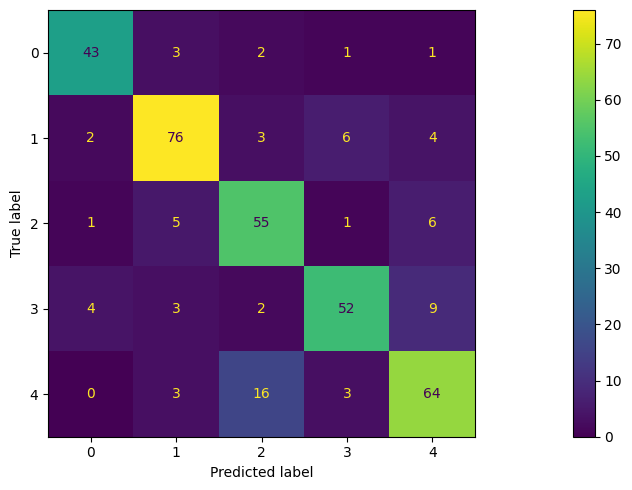

In [22]:
#Print and save confusion matrix
confusion_matrix_model17 = plot_confusion_matrix_report(y_test_cat, y_pred_cat)
confusion_matrix_model17.savefig('confusion_matrix_model17.png')

Slight overfitting, accuracy good, classfication really good, just confusing 4 with 2 to smaller extent.

In [19]:
#Train the model for 30 epochs and batch size 128
batch_size = 128 #21 batches (80% of training set (3289 images) = 2631.2 / 128 = 21)
history19 = model17.fit(train_datagen.flow(x_train, y_train_cat,
batch_size = batch_size,
subset = "training"),
epochs = 30, validation_data =
train_datagen.flow(x_train, y_train_cat,
batch_size = batch_size,
subset = "validation"))

Epoch 1/30
21/21 [==============================] - 380s 18s/step - loss: 1.8794 - accuracy: 0.2344 - val_loss: 1.5790 - val_accuracy: 0.2785
Epoch 2/30
21/21 [==============================] - 339s 16s/step - loss: 1.5011 - accuracy: 0.3085 - val_loss: 1.4777 - val_accuracy: 0.3257
Epoch 3/30
21/21 [==============================] - 354s 17s/step - loss: 1.3804 - accuracy: 0.3879 - val_loss: 1.3660 - val_accuracy: 0.3881
Epoch 4/30
21/21 [==============================] - 369s 18s/step - loss: 1.2384 - accuracy: 0.4958 - val_loss: 1.3579 - val_accuracy: 0.3775
Epoch 5/30
21/21 [==============================] - 331s 16s/step - loss: 1.1249 - accuracy: 0.5479 - val_loss: 1.2525 - val_accuracy: 0.4551
Epoch 6/30
21/21 [==============================] - 334s 16s/step - loss: 1.0690 - accuracy: 0.5707 - val_loss: 1.2516 - val_accuracy: 0.4612
Epoch 7/30
21/21 [==============================] - 325s 15s/step - loss: 1.0253 - accuracy: 0.5840 - val_loss: 1.1267 - val_accuracy: 0.5084
Epoch 

In [20]:
#Convert history19 to df
history19_df = pd.DataFrame(history19.history)

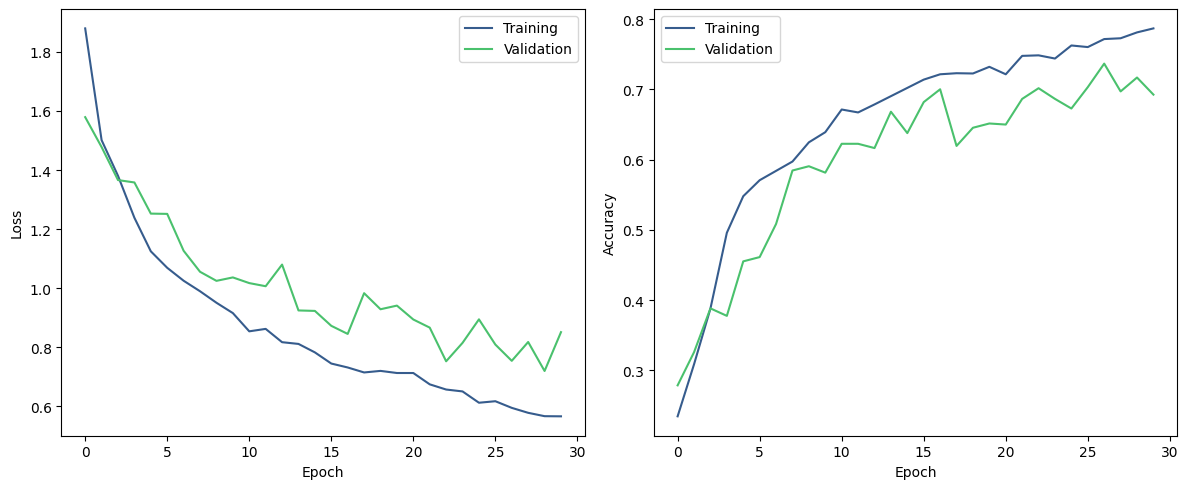

In [21]:
#Print and save accuracy plots
model17_128_accuracy_loss_plots = plot_training_history(history19_df)
model17_128_accuracy_loss_plots.savefig('model17_128_accuracy_loss_plots.png')

In [26]:
#Print metrics
metrics_model17_128 = print_final_metrics(history19_df)

Final Training Accuracy: 91.22%
Final Validation Accuracy: 77.93%
Final Training Loss: 0.2292
Final Validation Loss: 0.7785


In [27]:
#Evalute model on test set
y_pred, y_pred_cat = evaluate_model(model17, x_test, y_test_cat)

12/12 [==============================] - 10s 793ms/step - loss: 0.6952 - accuracy: 0.7890
Overall Accuracy: 78.90%
12/12 [==============================] - 9s 754ms/step


              precision    recall  f1-score   support

           0       0.77      0.88      0.82        50
           1       0.84      0.89      0.86        91
           2       0.62      0.74      0.68        68
           3       0.95      0.74      0.83        70
           4       0.80      0.71      0.75        86

    accuracy                           0.79       365
   macro avg       0.80      0.79      0.79       365
weighted avg       0.80      0.79      0.79       365



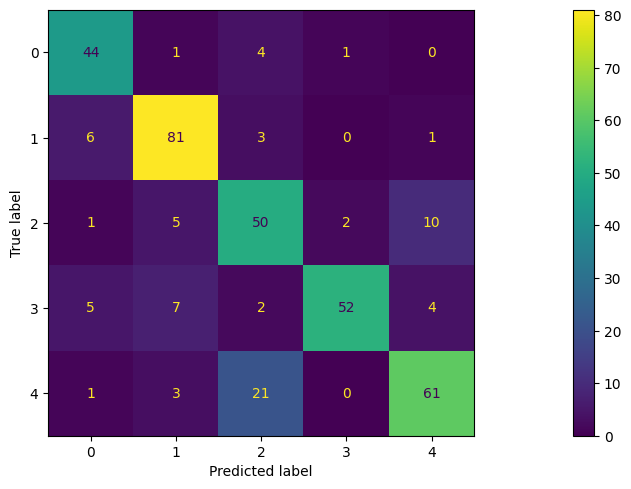

In [28]:
#Print and save confusion matrix
confusion_matrix_model17_128 = plot_confusion_matrix_report(y_test_cat, y_pred_cat)
confusion_matrix_model17_128.savefig('confusion_matrix_model17_128.png')

Overfitting with ok accuracy, classification slightly poorer compared to batch 32.

Next try model 8 with 0.001 L1 and L2, batch norm, dropout 0.3 with batch size 32 and 128.

In [16]:
#L1 and L2 regularisation 0.001 strength for both, with batch normalisation
model8 = build_cnn_model(width_npix, height_npix, num_classes, batch_norm=True, l1_reg=0.001, l2_reg=0.001)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 254, 254, 64)      1792      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 127, 127, 64)     0         
 )                                                               
                                                                 
 batch_normalization (BatchN  (None, 127, 127, 64)     256       
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 127, 127, 64)      0         
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 128)     73856     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 62, 62, 128)      0

In [32]:
#Train the model for 30 epochs and batch size 32
batch_size = 32 #82 batches (80% of training set (3289 images) = 2631.2 / 32 = 82)
history20 = model8.fit(train_datagen.flow(x_train, y_train_cat,
batch_size = batch_size,
subset = "training"),
epochs = 30, validation_data =
train_datagen.flow(x_train, y_train_cat,
batch_size = batch_size,
subset = "validation"))

Epoch 1/30
83/83 [==============================] - 423s 5s/step - loss: 1.5307 - accuracy: 0.4700 - val_loss: 1.3137 - val_accuracy: 0.4992
Epoch 2/30
83/83 [==============================] - 372s 4s/step - loss: 1.1933 - accuracy: 0.5479 - val_loss: 1.0684 - val_accuracy: 0.5647
Epoch 3/30
83/83 [==============================] - 363s 4s/step - loss: 1.0639 - accuracy: 0.5878 - val_loss: 1.0087 - val_accuracy: 0.5936
Epoch 4/30
83/83 [==============================] - 361s 4s/step - loss: 0.9882 - accuracy: 0.6212 - val_loss: 0.9704 - val_accuracy: 0.6225
Epoch 5/30
83/83 [==============================] - 360s 4s/step - loss: 0.9400 - accuracy: 0.6368 - val_loss: 0.9674 - val_accuracy: 0.6560
Epoch 6/30
83/83 [==============================] - 363s 4s/step - loss: 0.8625 - accuracy: 0.6721 - val_loss: 1.0428 - val_accuracy: 0.6027
Epoch 7/30
83/83 [==============================] - 359s 4s/step - loss: 0.8205 - accuracy: 0.6839 - val_loss: 0.8504 - val_accuracy: 0.6728
Epoch 8/30
83

In [33]:
#Convert history20 to df
history20_df = pd.DataFrame(history20.history)

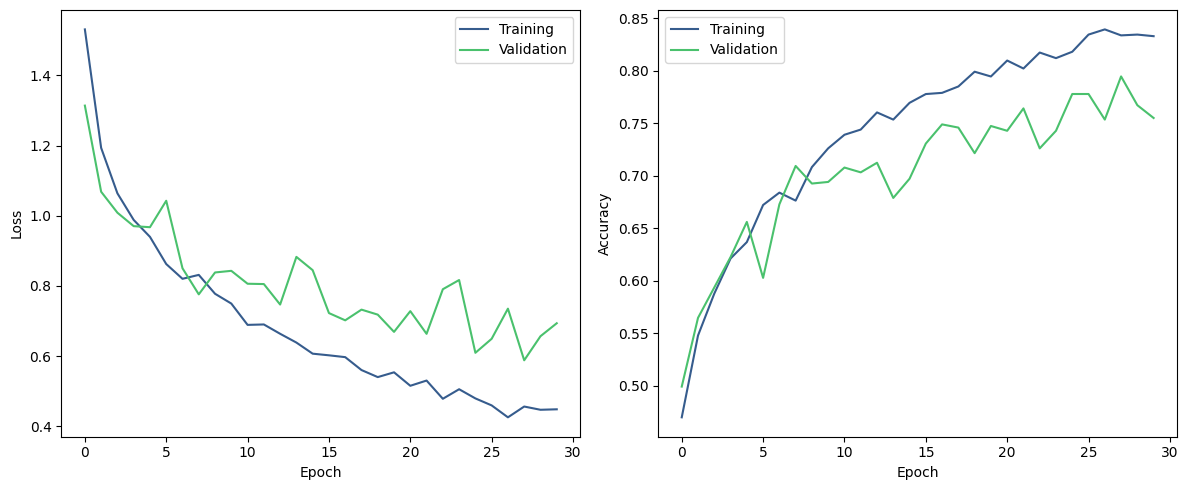

In [34]:
#Print and save accuracy plots
model8_32_accuracy_loss_plots = plot_training_history(history20_df)
model8_32_accuracy_loss_plots.savefig('model8_32_accuracy_loss_plots.png')

In [35]:
#Print metrics
metrics_model8_32 = print_final_metrics(history20_df)

Final Training Accuracy: 83.28%
Final Validation Accuracy: 75.49%
Final Training Loss: 0.4489
Final Validation Loss: 0.6939


In [36]:
#Evalute model on test set
y_pred, y_pred_cat = evaluate_model(model8, x_test, y_test_cat)

12/12 [==============================] - 10s 824ms/step - loss: 0.6576 - accuracy: 0.7534
Overall Accuracy: 75.34%
12/12 [==============================] - 10s 778ms/step


              precision    recall  f1-score   support

           0       0.73      0.86      0.79        50
           1       0.84      0.85      0.84        91
           2       0.65      0.62      0.63        68
           3       0.87      0.76      0.81        70
           4       0.68      0.70      0.69        86

    accuracy                           0.75       365
   macro avg       0.75      0.76      0.75       365
weighted avg       0.76      0.75      0.75       365



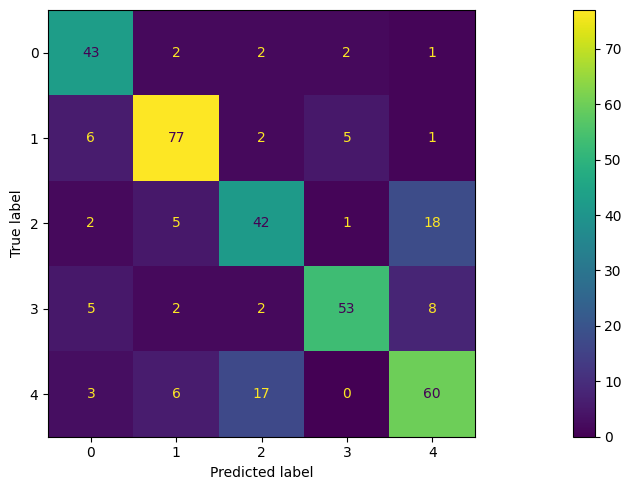

In [37]:
#Print and save confusion matrix
confusion_matrix_model8_32 = plot_confusion_matrix_report(y_test_cat, y_pred_cat)
confusion_matrix_model8_32.savefig('confusion_matrix_model8_32.png')

Overfitting, accuracy ok, classification confusing 4 and 2 (low f1 score for 2).

*Summary of batch size*

Decreasing to 32 for no batch normalisation or l1/l2 regularisation saw only slight overfitting and classification was improved with only tulip confused with rose.

Choosing batch size 32 going forward.

*Stride and padding*

Padding prevents loss of pixels on perimeter of images.

Stride dictates the slide across the convolution window.

Reference:

Naseri, H. & Mehrdad, V. (2023) Novel CNN with investigation on accuracy by modifying stride, padding, kernel size and filter numbers. Multimedia Tools and Applications, 82(15), 23673-23691.

Dive into deep learning Padding and stride. Available online: https://d2l.ai/chapter_convolutional-neural-networks/padding-and-strides.html [Accessed 16/12/2023].

Add padding to convolutional and pooling layers.

Stride to convolutional layers (2, 2), (3, 3).

For no L1 and L2, dropout 0.3, adam 0.001

With L1 and L2 (0.001) dropout 0.3, adam 0.001 (model 8)

In [16]:
#Adam is 0.001 (default), no L1 and L2, without batch normalisation, dropout 0.3, 30 epochs, stride (2,2) and padding
model18 = build_cnn_model(width_npix, height_npix, num_classes, conv_padding='same', pool_padding='same', conv_strides=(2, 2))

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 128, 128, 64)      1792      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 64, 64, 64)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 64, 64, 64)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 128)       73856     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 16, 16, 128)      0         
 2D)                                                             
                                                                 
 dropout_1 (Dropout)         (None, 16, 16, 128)       0

In [17]:
#Train the model for 30 epochs and batch size 32
batch_size = 32
history21 = model18.fit(train_datagen.flow(x_train, y_train_cat,
batch_size = batch_size,
subset = "training"),
epochs = 30, validation_data =
train_datagen.flow(x_train, y_train_cat,
batch_size = batch_size,
subset = "validation"))

Epoch 1/30
83/83 [==============================] - 64s 750ms/step - loss: 1.5758 - accuracy: 0.2515 - val_loss: 1.4528 - val_accuracy: 0.3790
Epoch 2/30
83/83 [==============================] - 69s 837ms/step - loss: 1.3347 - accuracy: 0.4001 - val_loss: 1.1714 - val_accuracy: 0.5282
Epoch 3/30
83/83 [==============================] - 73s 878ms/step - loss: 1.1477 - accuracy: 0.5091 - val_loss: 1.1148 - val_accuracy: 0.4992
Epoch 4/30
83/83 [==============================] - 64s 775ms/step - loss: 1.0671 - accuracy: 0.5570 - val_loss: 0.9817 - val_accuracy: 0.6058
Epoch 5/30
83/83 [==============================] - 65s 780ms/step - loss: 1.0411 - accuracy: 0.5798 - val_loss: 1.0085 - val_accuracy: 0.6104
Epoch 6/30
83/83 [==============================] - 71s 848ms/step - loss: 0.9936 - accuracy: 0.5980 - val_loss: 0.9696 - val_accuracy: 0.6134
Epoch 7/30
83/83 [==============================] - 64s 768ms/step - loss: 0.9739 - accuracy: 0.6052 - val_loss: 0.9713 - val_accuracy: 0.6377

In [18]:
#Convert history21 to df
history21_df = pd.DataFrame(history21.history)

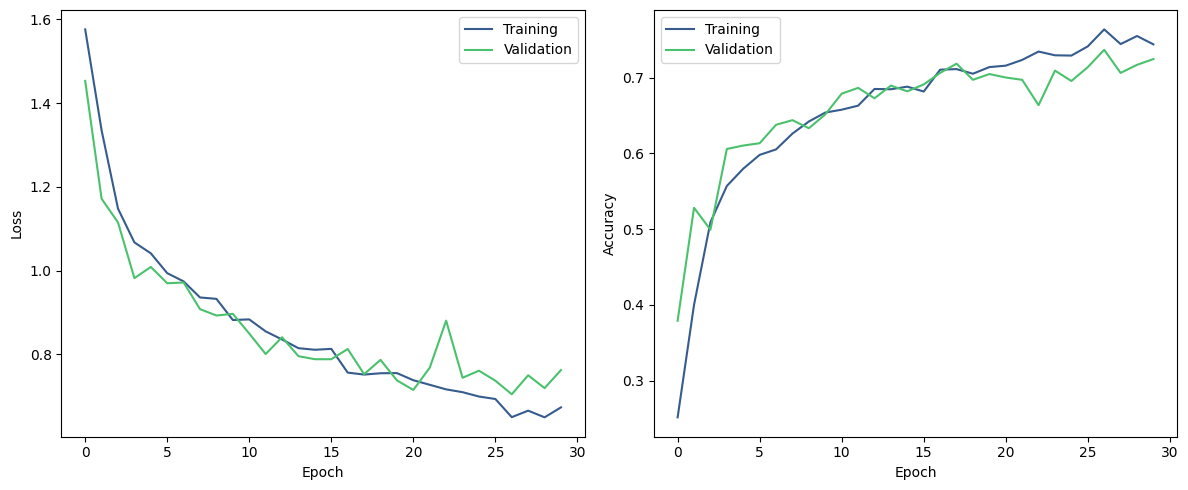

In [19]:
#Print and save accuracy plots
model18_accuracy_loss_plots = plot_training_history(history21_df)
model18_accuracy_loss_plots.savefig('model18_accuracy_loss_plots.png')

In [20]:
#Print metrics
metrics_model18 = print_final_metrics(history21_df)

Final Training Accuracy: 74.39%
Final Validation Accuracy: 72.45%
Final Training Loss: 0.6731
Final Validation Loss: 0.7623


In [21]:
#Evalute model on test set
y_pred, y_pred_cat = evaluate_model(model18, x_test, y_test_cat)

12/12 [==============================] - 2s 133ms/step - loss: 0.6783 - accuracy: 0.7616
Overall Accuracy: 76.16%
12/12 [==============================] - 2s 137ms/step


              precision    recall  f1-score   support

           0       0.89      0.84      0.87        50
           1       0.69      0.90      0.78        91
           2       0.65      0.63      0.64        68
           3       0.83      0.93      0.88        70
           4       0.84      0.53      0.65        86

    accuracy                           0.76       365
   macro avg       0.78      0.77      0.76       365
weighted avg       0.77      0.76      0.76       365



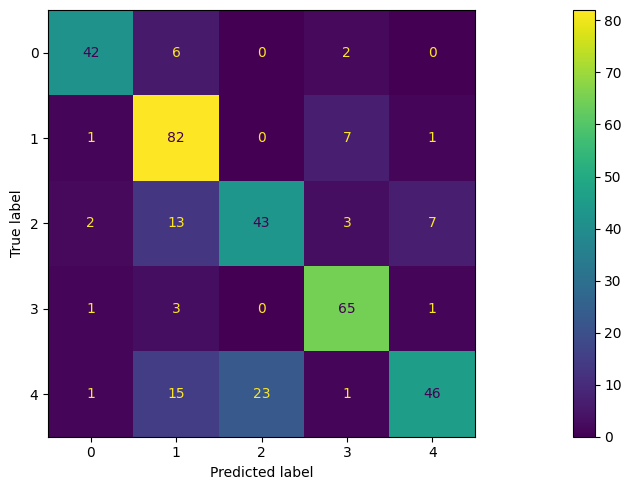

In [22]:
#Print and save confusion matrix
confusion_matrix_model18 = plot_confusion_matrix_report(y_test_cat, y_pred_cat)
confusion_matrix_model18.savefig('confusion_matrix_model18.png')

Very little overfitting, accuracy on test data good, f1 score low for 2 and 4 misclassified indicated by lower recall.

In [23]:
#L1 and L2 regularisation 0.001 strength for both, with batch normalisation, stride (2,2) and padding
model19 = build_cnn_model(width_npix, height_npix, num_classes, batch_norm=True, l1_reg=0.001, l2_reg=0.001, conv_padding='same', pool_padding='same', conv_strides=(2, 2))

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_5 (Conv2D)           (None, 128, 128, 64)      1792      
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 64, 64, 64)       0         
 2D)                                                             
                                                                 
 batch_normalization (BatchN  (None, 64, 64, 64)       256       
 ormalization)                                                   
                                                                 
 dropout_6 (Dropout)         (None, 64, 64, 64)        0         
                                                                 
 conv2d_6 (Conv2D)           (None, 32, 32, 128)       73856     
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 16, 16, 128)     

In [24]:
#Train the model for 30 epochs and batch size 32
batch_size = 32
history22 = model19.fit(train_datagen.flow(x_train, y_train_cat,
batch_size = batch_size,
subset = "training"),
epochs = 30, validation_data =
train_datagen.flow(x_train, y_train_cat,
batch_size = batch_size,
subset = "validation"))

Epoch 1/30
83/83 [==============================] - 70s 807ms/step - loss: 1.6635 - accuracy: 0.4233 - val_loss: 1.2854 - val_accuracy: 0.5008
Epoch 2/30
83/83 [==============================] - 69s 829ms/step - loss: 1.3175 - accuracy: 0.5091 - val_loss: 1.0986 - val_accuracy: 0.5784
Epoch 3/30
83/83 [==============================] - 64s 766ms/step - loss: 1.1680 - accuracy: 0.5433 - val_loss: 1.0911 - val_accuracy: 0.5890
Epoch 4/30
83/83 [==============================] - 62s 746ms/step - loss: 1.0670 - accuracy: 0.5832 - val_loss: 0.9623 - val_accuracy: 0.6225
Epoch 5/30
83/83 [==============================] - 62s 746ms/step - loss: 1.0607 - accuracy: 0.5855 - val_loss: 0.9282 - val_accuracy: 0.6301
Epoch 6/30
83/83 [==============================] - 62s 743ms/step - loss: 0.9778 - accuracy: 0.6193 - val_loss: 0.8781 - val_accuracy: 0.6682
Epoch 7/30
83/83 [==============================] - 62s 745ms/step - loss: 0.9450 - accuracy: 0.6379 - val_loss: 0.9291 - val_accuracy: 0.6499

In [25]:
#Convert history22 to df
history22_df = pd.DataFrame(history22.history)

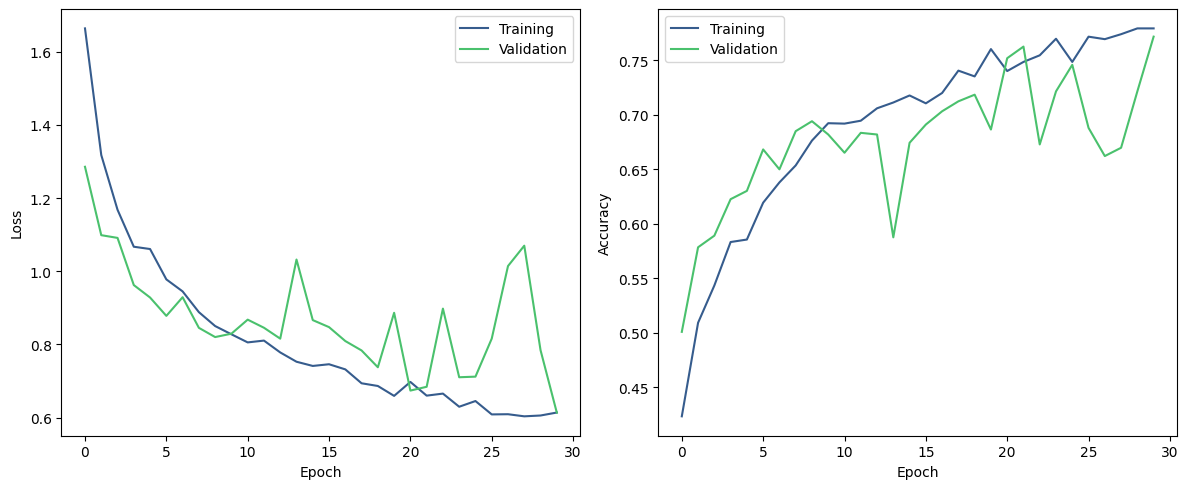

In [26]:
#Print and save accuracy plots
model19_accuracy_loss_plots = plot_training_history(history22_df)
model19_accuracy_loss_plots.savefig('model19_accuracy_loss_plots.png')

In [27]:
#Print metrics
metrics_model19 = print_final_metrics(history22_df)

Final Training Accuracy: 77.93%
Final Validation Accuracy: 77.17%
Final Training Loss: 0.6140
Final Validation Loss: 0.6138


In [28]:
#Evalute model on test set
y_pred, y_pred_cat = evaluate_model(model19, x_test, y_test_cat)

12/12 [==============================] - 1s 114ms/step - loss: 0.5960 - accuracy: 0.7890
Overall Accuracy: 78.90%
12/12 [==============================] - 2s 136ms/step


              precision    recall  f1-score   support

           0       0.82      0.80      0.81        50
           1       0.78      0.90      0.84        91
           2       0.73      0.68      0.70        68
           3       0.85      0.83      0.84        70
           4       0.78      0.72      0.75        86

    accuracy                           0.79       365
   macro avg       0.79      0.79      0.79       365
weighted avg       0.79      0.79      0.79       365



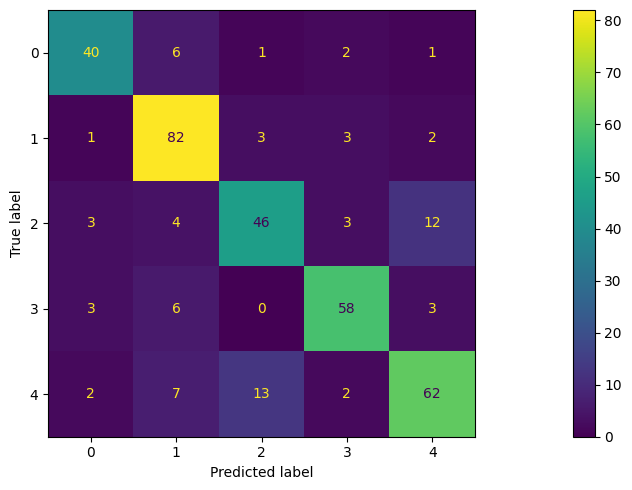

In [29]:
#Print and save confusion matrix
confusion_matrix_model19 = plot_confusion_matrix_report(y_test_cat, y_pred_cat)
confusion_matrix_model19.savefig('confusion_matrix_model19.png')

Less overfitting, accuracy very good, classification good, misclassifying 2 and 4 but to lesser extent.

*Stride (3, 3)*

In [30]:
#Adam is 0.001 (default), no L1 and L2, without batch normalisation, dropout 0.3, 30 epochs, stride (3,3) and padding
model20 = build_cnn_model(width_npix, height_npix, num_classes, conv_padding='same', pool_padding='same', conv_strides=(3, 3))

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_10 (Conv2D)          (None, 86, 86, 64)        1792      
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, 43, 43, 64)       0         
 g2D)                                                            
                                                                 
 dropout_12 (Dropout)        (None, 43, 43, 64)        0         
                                                                 
 conv2d_11 (Conv2D)          (None, 15, 15, 128)       73856     
                                                                 
 max_pooling2d_11 (MaxPoolin  (None, 8, 8, 128)        0         
 g2D)                                                            
                                                                 
 dropout_13 (Dropout)        (None, 8, 8, 128)        

In [31]:
#Train the model for 30 epochs and batch size 32
batch_size = 32
history23 = model20.fit(train_datagen.flow(x_train, y_train_cat,
batch_size = batch_size,
subset = "training"),
epochs = 30, validation_data =
train_datagen.flow(x_train, y_train_cat,
batch_size = batch_size,
subset = "validation"))

Epoch 1/30
83/83 [==============================] - 53s 626ms/step - loss: 1.5448 - accuracy: 0.2724 - val_loss: 1.3961 - val_accuracy: 0.3714
Epoch 2/30
83/83 [==============================] - 52s 626ms/step - loss: 1.2990 - accuracy: 0.4221 - val_loss: 1.1975 - val_accuracy: 0.4414
Epoch 3/30
83/83 [==============================] - 52s 626ms/step - loss: 1.1683 - accuracy: 0.5030 - val_loss: 1.0997 - val_accuracy: 0.5251
Epoch 4/30
83/83 [==============================] - 50s 607ms/step - loss: 1.1132 - accuracy: 0.5274 - val_loss: 1.0914 - val_accuracy: 0.5449
Epoch 5/30
83/83 [==============================] - 49s 591ms/step - loss: 1.0917 - accuracy: 0.5574 - val_loss: 1.0634 - val_accuracy: 0.5312
Epoch 6/30
83/83 [==============================] - 50s 604ms/step - loss: 1.0655 - accuracy: 0.5578 - val_loss: 1.0278 - val_accuracy: 0.5510
Epoch 7/30
83/83 [==============================] - 53s 640ms/step - loss: 1.0507 - accuracy: 0.5726 - val_loss: 1.0963 - val_accuracy: 0.5084

In [32]:
#Convert history23 to df
history23_df = pd.DataFrame(history23.history)

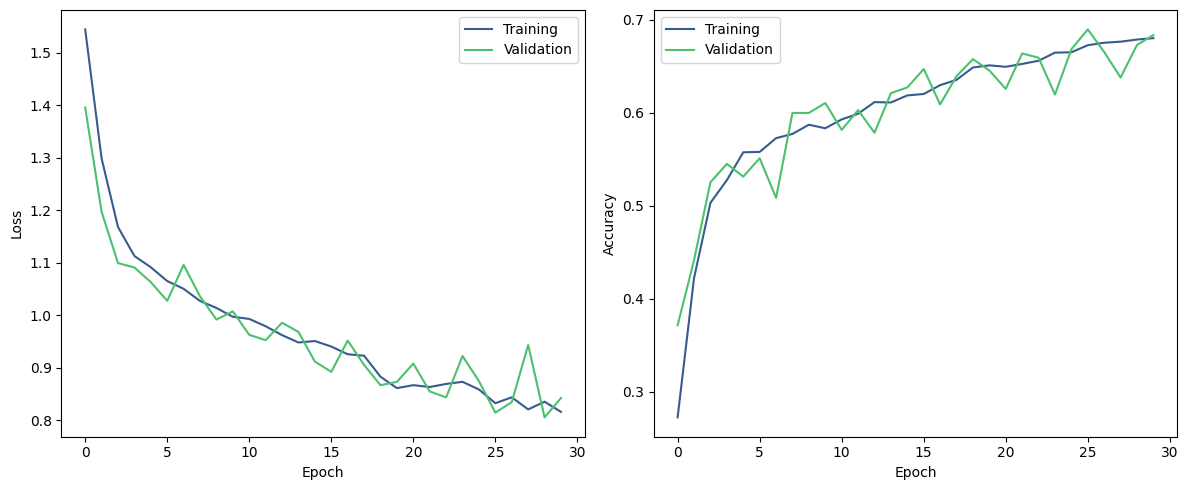

In [33]:
#Print and save accuracy plots
model20_accuracy_loss_plots = plot_training_history(history23_df)
model20_accuracy_loss_plots.savefig('model20_accuracy_loss_plots.png')

In [34]:
#Print metrics
metrics_model20 = print_final_metrics(history23_df)

Final Training Accuracy: 68.01%
Final Validation Accuracy: 68.34%
Final Training Loss: 0.8163
Final Validation Loss: 0.8426


In [35]:
#Evalute model on test set
y_pred, y_pred_cat = evaluate_model(model20, x_test, y_test_cat)

12/12 [==============================] - 1s 51ms/step - loss: 0.7647 - accuracy: 0.6685
Overall Accuracy: 66.85%
12/12 [==============================] - 1s 44ms/step


              precision    recall  f1-score   support

           0       0.72      0.82      0.77        50
           1       0.64      0.79      0.71        91
           2       0.53      0.66      0.59        68
           3       0.84      0.74      0.79        70
           4       0.69      0.40      0.50        86

    accuracy                           0.67       365
   macro avg       0.68      0.68      0.67       365
weighted avg       0.68      0.67      0.66       365



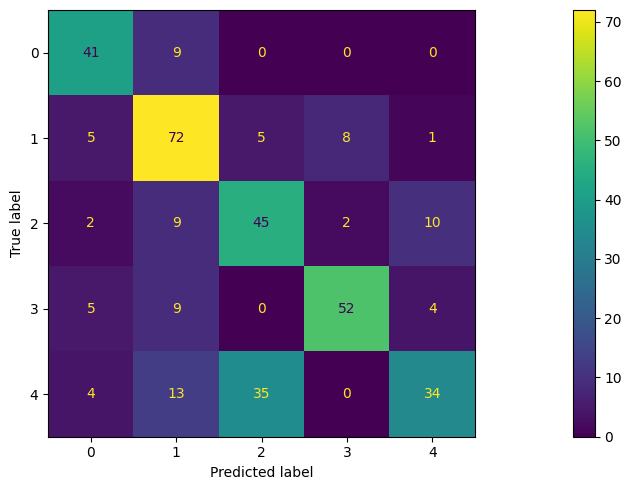

In [36]:
#Print and save confusion matrix
confusion_matrix_model20 = plot_confusion_matrix_report(y_test_cat, y_pred_cat)
confusion_matrix_model20.savefig('confusion_matrix_model20.png')

Lower accuracy but no overfitting. Classification for 4 and 2 in particular worse.

In [37]:
#L1 and L2 regularisation 0.001 strength for both, with batch normalisation, stride (3, 3) and padding
model21 = build_cnn_model(width_npix, height_npix, num_classes, batch_norm=True, l1_reg=0.001, l2_reg=0.001, conv_padding='same', pool_padding='same', conv_strides=(3, 3))

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_15 (Conv2D)          (None, 86, 86, 64)        1792      
                                                                 
 max_pooling2d_15 (MaxPoolin  (None, 43, 43, 64)       0         
 g2D)                                                            
                                                                 
 batch_normalization_6 (Batc  (None, 43, 43, 64)       256       
 hNormalization)                                                 
                                                                 
 dropout_18 (Dropout)        (None, 43, 43, 64)        0         
                                                                 
 conv2d_16 (Conv2D)          (None, 15, 15, 128)       73856     
                                                                 
 max_pooling2d_16 (MaxPoolin  (None, 8, 8, 128)       

In [38]:
#Train the model for 30 epochs and batch size 32
batch_size = 32
history24 = model21.fit(train_datagen.flow(x_train, y_train_cat,
batch_size = batch_size,
subset = "training"),
epochs = 30, validation_data =
train_datagen.flow(x_train, y_train_cat,
batch_size = batch_size,
subset = "validation"))

Epoch 1/30
83/83 [==============================] - 58s 666ms/step - loss: 1.8339 - accuracy: 0.3670 - val_loss: 1.3353 - val_accuracy: 0.5053
Epoch 2/30
83/83 [==============================] - 55s 660ms/step - loss: 1.4576 - accuracy: 0.4316 - val_loss: 1.1155 - val_accuracy: 0.5358
Epoch 3/30
83/83 [==============================] - 54s 648ms/step - loss: 1.3268 - accuracy: 0.5053 - val_loss: 1.0784 - val_accuracy: 0.5616
Epoch 4/30
83/83 [==============================] - 52s 622ms/step - loss: 1.2321 - accuracy: 0.5236 - val_loss: 1.0435 - val_accuracy: 0.5753
Epoch 5/30
83/83 [==============================] - 51s 610ms/step - loss: 1.1436 - accuracy: 0.5464 - val_loss: 1.0232 - val_accuracy: 0.6088
Epoch 6/30
83/83 [==============================] - 52s 623ms/step - loss: 1.0846 - accuracy: 0.5840 - val_loss: 1.0203 - val_accuracy: 0.5845
Epoch 7/30
83/83 [==============================] - 50s 605ms/step - loss: 1.0531 - accuracy: 0.5866 - val_loss: 0.9044 - val_accuracy: 0.6301

In [39]:
#Convert history24 to df
history24_df = pd.DataFrame(history24.history)

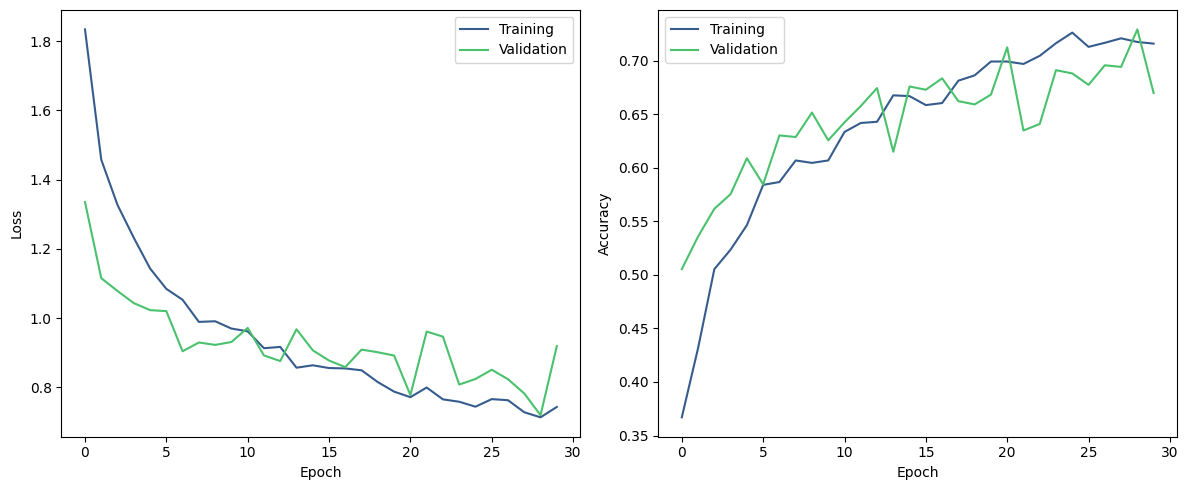

In [40]:
#Print and save accuracy plots
model21_accuracy_loss_plots = plot_training_history(history24_df)
model21_accuracy_loss_plots.savefig('model21_accuracy_loss_plots.png')

In [41]:
#Print metrics
metrics_model21 = print_final_metrics(history24_df)

Final Training Accuracy: 71.58%
Final Validation Accuracy: 66.97%
Final Training Loss: 0.7436
Final Validation Loss: 0.9191


In [42]:
#Evalute model on test set
y_pred, y_pred_cat = evaluate_model(model21, x_test, y_test_cat)

12/12 [==============================] - 1s 53ms/step - loss: 0.8498 - accuracy: 0.7014
Overall Accuracy: 70.14%
12/12 [==============================] - 1s 53ms/step


              precision    recall  f1-score   support

           0       0.76      0.76      0.76        50
           1       0.62      0.87      0.72        91
           2       0.60      0.60      0.60        68
           3       0.77      0.90      0.83        70
           4       0.95      0.41      0.57        86

    accuracy                           0.70       365
   macro avg       0.74      0.71      0.70       365
weighted avg       0.74      0.70      0.69       365



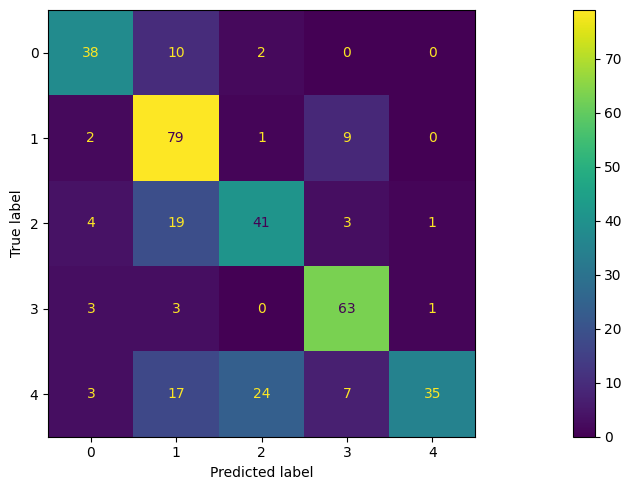

In [43]:
#Print and save confusion matrix
confusion_matrix_model21 = plot_confusion_matrix_report(y_test_cat, y_pred_cat)
confusion_matrix_model21.savefig('confusion_matrix_model21.png')

Some overfitting, accuracy ok but not as good as other models at 70%. Classification particularly reduced for 4 with lower recall.

*Summary of stride and padding*

Stride of (2,2) with batch norm and l1/l2 of 0.001 caused slight overfitting but accuracy was good with only slight misclassification of tulip and rose.

Stride of (3,3) with no batch norm and no l1/l1 saw no overfitting, accuracy decreased, classification was good of tulip and rose.

Difficult to determine which stride will be best for final model at this point but stride and padding have made significant difference to overfitting and classification performance.

*Kernel size*

Increase kernel size to (5, 5)

The size of the window that slides over the image performing local feaure extraction. rade off between local and global (bigger kernel) info capture.

Reference:

Naseri, H. & Mehrdad, V. (2023) Novel CNN with investigation on accuracy by modifying stride, padding, kernel size and filter numbers. Multimedia Tools and Applications, 82(15), 23673-23691.

Chansong, D. & Supratid, S. (2021) Impacts of kernel size on different resized images in object recognition based on convolutional neural network, 2021 9th International Electrical Engineering Congress (iEECON). Pattaya, Thailand, 448-451.

In [16]:
#L1 and L2 regularisation 0.001 strength for both, with batch normalisation, stride (2,2) and padding, kernel size (5, 5)
model22 = build_cnn_model(width_npix, height_npix, num_classes, kernel_size=(5, 5), batch_norm=True, l1_reg=0.001, l2_reg=0.001, conv_padding='same', pool_padding='same', conv_strides=(2, 2))

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 128, 128, 64)      4864      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 64, 64, 64)       0         
 )                                                               
                                                                 
 batch_normalization (BatchN  (None, 64, 64, 64)       256       
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 64, 64, 64)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 128)       204928    
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 16, 16, 128)      0

In [17]:
#Train the model for 30 epochs and batch size 32
batch_size = 32
history25 = model22.fit(train_datagen.flow(x_train, y_train_cat,
batch_size = batch_size,
subset = "training"),
epochs = 30, validation_data =
train_datagen.flow(x_train, y_train_cat,
batch_size = batch_size,
subset = "validation"))

Epoch 1/30
83/83 [==============================] - 112s 1s/step - loss: 1.7664 - accuracy: 0.3974 - val_loss: 1.2197 - val_accuracy: 0.5190
Epoch 2/30
83/83 [==============================] - 96s 1s/step - loss: 1.3830 - accuracy: 0.4882 - val_loss: 1.1133 - val_accuracy: 0.5510
Epoch 3/30
83/83 [==============================] - 104s 1s/step - loss: 1.2309 - accuracy: 0.5376 - val_loss: 1.0534 - val_accuracy: 0.5799
Epoch 4/30
83/83 [==============================] - 99s 1s/step - loss: 1.0917 - accuracy: 0.5824 - val_loss: 1.0397 - val_accuracy: 0.6012
Epoch 5/30
83/83 [==============================] - 95s 1s/step - loss: 1.0409 - accuracy: 0.6087 - val_loss: 0.9732 - val_accuracy: 0.5967
Epoch 6/30
83/83 [==============================] - 104s 1s/step - loss: 0.9778 - accuracy: 0.6136 - val_loss: 0.9780 - val_accuracy: 0.6043
Epoch 7/30
83/83 [==============================] - 103s 1s/step - loss: 0.9221 - accuracy: 0.6600 - val_loss: 0.8800 - val_accuracy: 0.6575
Epoch 8/30
83/83

In [18]:
#Convert history25 to df
history25_df = pd.DataFrame(history25.history)

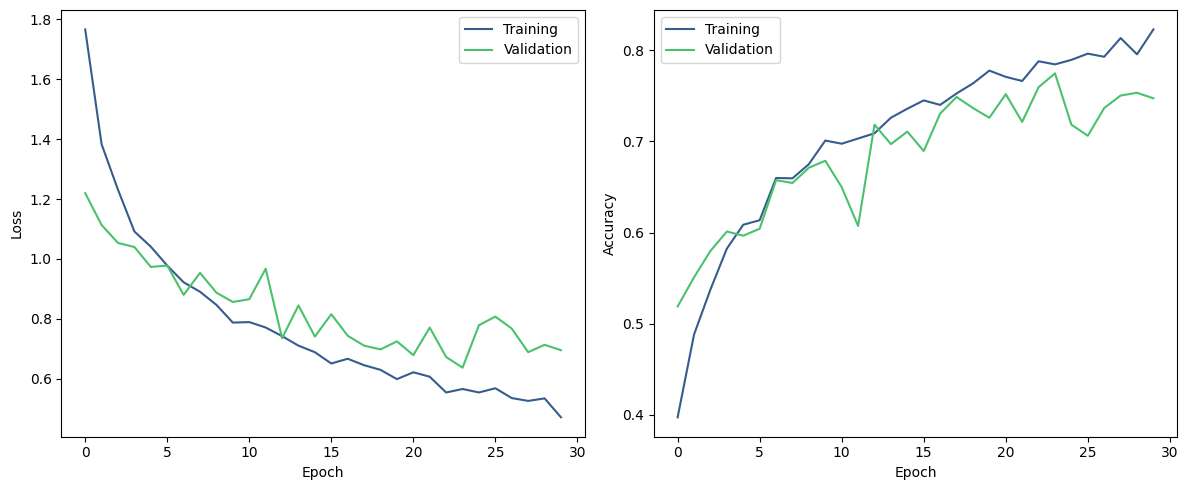

In [19]:
#Print and save accuracy plots
model22_accuracy_loss_plots = plot_training_history(history25_df)
model22_accuracy_loss_plots.savefig('model22_accuracy_loss_plots.png')

In [20]:
#Print metrics
metrics_model22 = print_final_metrics(history25_df)

Final Training Accuracy: 82.29%
Final Validation Accuracy: 74.73%
Final Training Loss: 0.4711
Final Validation Loss: 0.6953


In [21]:
#Evalute model on test set
y_pred, y_pred_cat = evaluate_model(model22, x_test, y_test_cat)

12/12 [==============================] - 2s 193ms/step - loss: 0.6923 - accuracy: 0.7534
Overall Accuracy: 75.34%
12/12 [==============================] - 2s 167ms/step


              precision    recall  f1-score   support

           0       0.81      0.84      0.82        50
           1       0.80      0.73      0.76        91
           2       0.57      0.79      0.66        68
           3       0.89      0.79      0.83        70
           4       0.79      0.67      0.73        86

    accuracy                           0.75       365
   macro avg       0.77      0.76      0.76       365
weighted avg       0.77      0.75      0.76       365



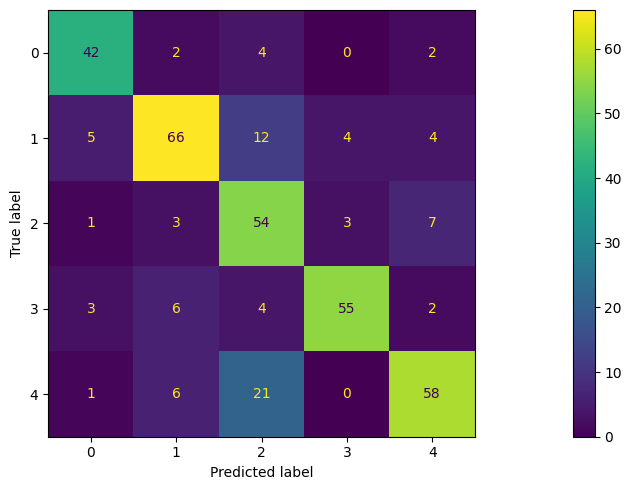

In [22]:
#Print and save confusion matrix
confusion_matrix_model22 = plot_confusion_matrix_report(y_test_cat, y_pred_cat)
confusion_matrix_model22.savefig('confusion_matrix_model22.png')

Slight overfitting, good accuracy, lower recall for 4, precision lower for 2.

*Summary of increased kernel size*

Increasing the kernel size did not improve accuracy of the model and overfitting was present again. Classification, particularly for class 4, tulip was reduced also.

Sticking with kernel size (3, 3).

*Average vs Max pooling*

Try average pooling instead of max pooling.

Max pooling is a down-sampling operation that extracts the maximum value within a specified kernel or filter. 

Average pooling computes the average value within a specified kernel or filter. 

Tensorflow (2023) tf.keras.layers.AveragePooling2D. Available online: https://www.tensorflow.org/api_docs/python/tf/keras/layers/AveragePooling2D [Accessed 16/12/2023].

Tensorflow (2023) tf.keras.layers.MaxPooling2D. Available online: https://www.tensorflow.org/api_docs/python/tf/keras/layers/MaxPooling2D [Accessed 16/12/2023].

In [23]:
#L1 and L2 regularisation 0.001 strength for both, with batch normalisation, stride (2,2) and padding, kernel size (3, 3), average pooling
model23 = build_cnn_model(width_npix, height_npix, num_classes, batch_norm=True, l1_reg=0.001, l2_reg=0.001, pooling='average', conv_padding='same', pool_padding='same', conv_strides=(2, 2))

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_5 (Conv2D)           (None, 128, 128, 64)      1792      
                                                                 
 average_pooling2d (AverageP  (None, 64, 64, 64)       0         
 ooling2D)                                                       
                                                                 
 batch_normalization_6 (Batc  (None, 64, 64, 64)       256       
 hNormalization)                                                 
                                                                 
 dropout_6 (Dropout)         (None, 64, 64, 64)        0         
                                                                 
 conv2d_6 (Conv2D)           (None, 32, 32, 128)       73856     
                                                                 
 average_pooling2d_1 (Averag  (None, 16, 16, 128)     

In [24]:
#Train the model for 30 epochs and batch size 32
batch_size = 32
history26 = model23.fit(train_datagen.flow(x_train, y_train_cat,
batch_size = batch_size,
subset = "training"),
epochs = 30, validation_data =
train_datagen.flow(x_train, y_train_cat,
batch_size = batch_size,
subset = "validation"))

Epoch 1/30
83/83 [==============================] - 73s 837ms/step - loss: 1.6761 - accuracy: 0.3940 - val_loss: 1.2622 - val_accuracy: 0.5266
Epoch 2/30
83/83 [==============================] - 64s 772ms/step - loss: 1.3723 - accuracy: 0.4833 - val_loss: 1.2874 - val_accuracy: 0.4992
Epoch 3/30
83/83 [==============================] - 66s 799ms/step - loss: 1.2603 - accuracy: 0.5209 - val_loss: 1.1679 - val_accuracy: 0.5632
Epoch 4/30
83/83 [==============================] - 66s 798ms/step - loss: 1.1771 - accuracy: 0.5540 - val_loss: 1.2899 - val_accuracy: 0.5099
Epoch 5/30
83/83 [==============================] - 66s 790ms/step - loss: 1.1414 - accuracy: 0.5505 - val_loss: 1.0630 - val_accuracy: 0.6012
Epoch 6/30
83/83 [==============================] - 68s 820ms/step - loss: 1.0822 - accuracy: 0.5855 - val_loss: 1.0120 - val_accuracy: 0.6073
Epoch 7/30
83/83 [==============================] - 66s 793ms/step - loss: 1.0502 - accuracy: 0.5904 - val_loss: 1.0349 - val_accuracy: 0.5967

In [25]:
#Convert history26 to df
history26_df = pd.DataFrame(history26.history)

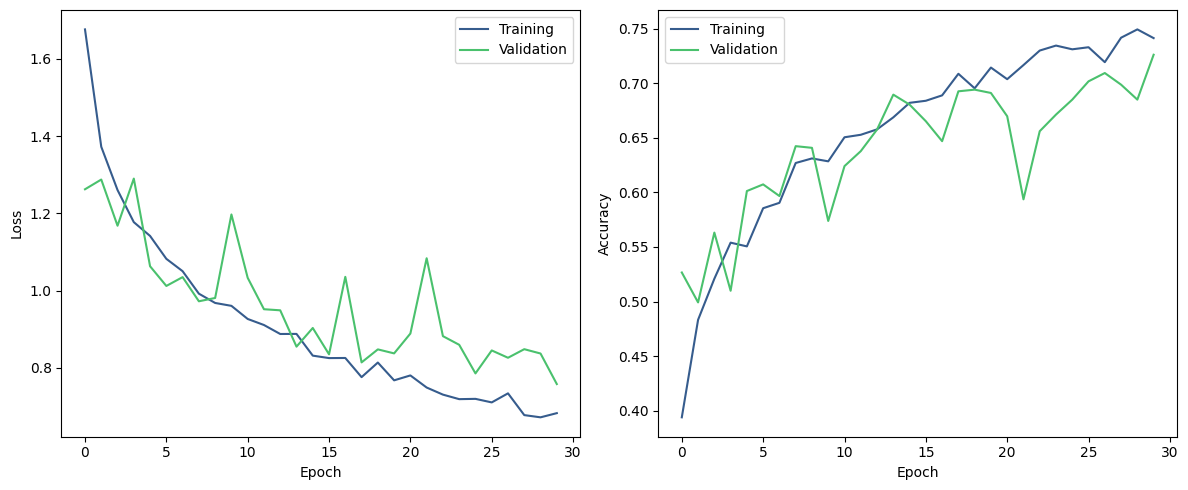

In [26]:
#Print and save accuracy plots
model23_accuracy_loss_plots = plot_training_history(history26_df)
model23_accuracy_loss_plots.savefig('model23_accuracy_loss_plots.png')

In [27]:
#Print metrics
metrics_model23 = print_final_metrics(history26_df)

Final Training Accuracy: 74.13%
Final Validation Accuracy: 72.60%
Final Training Loss: 0.6828
Final Validation Loss: 0.7581


In [28]:
#Evalute model on test set
y_pred, y_pred_cat = evaluate_model(model23, x_test, y_test_cat)

12/12 [==============================] - 1s 116ms/step - loss: 0.6845 - accuracy: 0.7397
Overall Accuracy: 73.97%
12/12 [==============================] - 1s 110ms/step


              precision    recall  f1-score   support

           0       0.74      0.84      0.79        50
           1       0.76      0.81      0.79        91
           2       0.60      0.68      0.63        68
           3       0.79      0.87      0.83        70
           4       0.82      0.55      0.66        86

    accuracy                           0.74       365
   macro avg       0.74      0.75      0.74       365
weighted avg       0.75      0.74      0.74       365



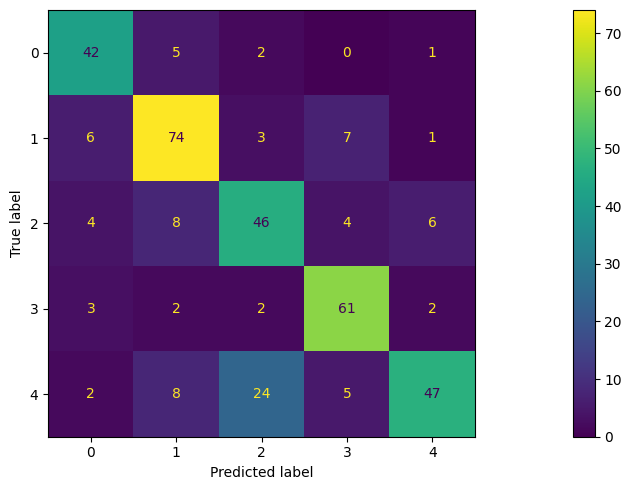

In [29]:
#Print and save confusion matrix
confusion_matrix_model23 = plot_confusion_matrix_report(y_test_cat, y_pred_cat)
confusion_matrix_model23.savefig('confusion_matrix_model23.png')

Slight overfitting, accuracy ok at 74%, Misclassification mainly of 4 (confused with 2).

*Summary of average vs max pooling*

Using average pooling reduced the performnce of the model slightly. Will stick with Max pooling.

*Activation Function*

Try scaled exponential linear unit,SeLU or eLU as alternative in convolutional layers.

The activation function, ReLU, was chosen as widely used and effective. It replaces any negative input with zero and leaves positive values unchanged. There are no negative values to account for.

Tensorflow (2023) tf.keras.layers.ReLU. Available online: https://www.tensorflow.org/api_docs/python/tf/keras/layers/ReLU [Accessed 16/12/2023].

Tensorflow (2023) tf.keras.layers.SeLU. Available online: https://www.tensorflow.org/api_docs/python/tf/keras/activations/selu [Accessed 16/12/2023].

Tensorflow (2023) tf.keras.layers.ELU. Available online: https://www.tensorflow.org/api_docs/python/tf/keras/layers/ELU [Accessed 16/12/2023].

In [30]:
#L1 and L2 regularisation 0.001 strength for both, with batch normalisation, stride (2,2) and padding, kernel size (3, 3), max pooling, activation function selu
model24 = build_cnn_model(width_npix, height_npix, num_classes, batch_norm=True, l1_reg=0.001, l2_reg=0.001, conv_padding='same', pool_padding='same', conv_strides=(2, 2), conv_activation='selu')

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_10 (Conv2D)          (None, 128, 128, 64)      1792      
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 64, 64, 64)       0         
 2D)                                                             
                                                                 
 batch_normalization_12 (Bat  (None, 64, 64, 64)       256       
 chNormalization)                                                
                                                                 
 dropout_12 (Dropout)        (None, 64, 64, 64)        0         
                                                                 
 conv2d_11 (Conv2D)          (None, 32, 32, 128)       73856     
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 16, 16, 128)     

In [31]:
#Train the model for 30 epochs and batch size 32
batch_size = 32
history27 = model24.fit(train_datagen.flow(x_train, y_train_cat,
batch_size = batch_size,
subset = "training"),
epochs = 30, validation_data =
train_datagen.flow(x_train, y_train_cat,
batch_size = batch_size,
subset = "validation"))

Epoch 1/30
83/83 [==============================] - 75s 876ms/step - loss: 1.7664 - accuracy: 0.3830 - val_loss: 1.3225 - val_accuracy: 0.5160
Epoch 2/30
83/83 [==============================] - 66s 797ms/step - loss: 1.3730 - accuracy: 0.4886 - val_loss: 1.1319 - val_accuracy: 0.5525
Epoch 3/30
83/83 [==============================] - 77s 923ms/step - loss: 1.2360 - accuracy: 0.5243 - val_loss: 1.1648 - val_accuracy: 0.5738
Epoch 4/30
83/83 [==============================] - 80s 963ms/step - loss: 1.1372 - accuracy: 0.5578 - val_loss: 1.0481 - val_accuracy: 0.5997
Epoch 5/30
83/83 [==============================] - 72s 868ms/step - loss: 1.0849 - accuracy: 0.5862 - val_loss: 0.9874 - val_accuracy: 0.6134
Epoch 6/30
83/83 [==============================] - 72s 865ms/step - loss: 1.0259 - accuracy: 0.6163 - val_loss: 0.9276 - val_accuracy: 0.6317
Epoch 7/30
83/83 [==============================] - 70s 838ms/step - loss: 0.9646 - accuracy: 0.6261 - val_loss: 0.9237 - val_accuracy: 0.6438

In [32]:
#Convert history27 to df
history27_df = pd.DataFrame(history27.history)

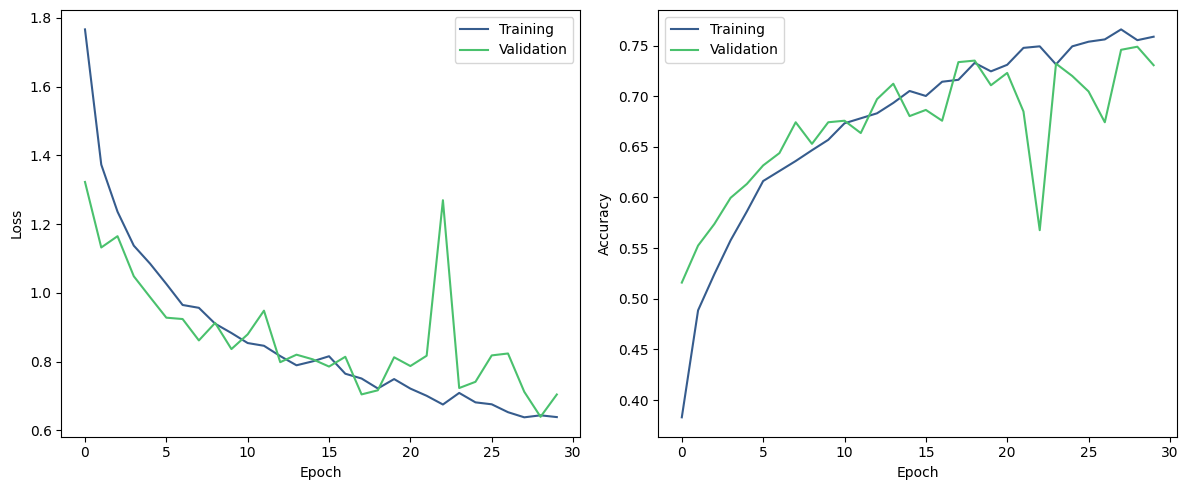

In [33]:
#Print and save accuracy plots
model24_accuracy_loss_plots = plot_training_history(history27_df)
model24_accuracy_loss_plots.savefig('model24_accuracy_loss_plots.png')

In [34]:
#Print metrics
metrics_model24 = print_final_metrics(history27_df)

Final Training Accuracy: 75.87%
Final Validation Accuracy: 73.06%
Final Training Loss: 0.6384
Final Validation Loss: 0.7042


In [35]:
#Evalute model on test set
y_pred, y_pred_cat = evaluate_model(model24, x_test, y_test_cat)

12/12 [==============================] - 1s 117ms/step - loss: 0.7021 - accuracy: 0.7507
Overall Accuracy: 75.07%
12/12 [==============================] - 1s 105ms/step


              precision    recall  f1-score   support

           0       0.76      0.84      0.80        50
           1       0.68      0.88      0.77        91
           2       0.65      0.69      0.67        68
           3       0.85      0.83      0.84        70
           4       0.89      0.55      0.68        86

    accuracy                           0.75       365
   macro avg       0.77      0.76      0.75       365
weighted avg       0.77      0.75      0.75       365



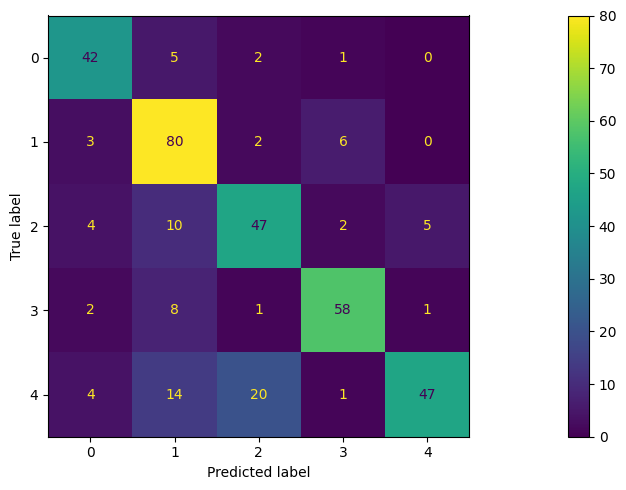

In [36]:
#Print and save confusion matrix
confusion_matrix_model24 = plot_confusion_matrix_report(y_test_cat, y_pred_cat)
confusion_matrix_model24.savefig('confusion_matrix_model24.png')

Only slight overfitting, accuracy good, missclassification particularly for 4 and 2.

In [37]:
#L1 and L2 regularisation 0.001 strength for both, with batch normalisation, stride (2,2) and padding, kernel size (3, 3), max pooling, activation function elu
model25 = build_cnn_model(width_npix, height_npix, num_classes, batch_norm=True, l1_reg=0.001, l2_reg=0.001, conv_padding='same', pool_padding='same', conv_strides=(2, 2), conv_activation='elu')

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_15 (Conv2D)          (None, 128, 128, 64)      1792      
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, 64, 64, 64)       0         
 g2D)                                                            
                                                                 
 batch_normalization_18 (Bat  (None, 64, 64, 64)       256       
 chNormalization)                                                
                                                                 
 dropout_18 (Dropout)        (None, 64, 64, 64)        0         
                                                                 
 conv2d_16 (Conv2D)          (None, 32, 32, 128)       73856     
                                                                 
 max_pooling2d_11 (MaxPoolin  (None, 16, 16, 128)     

In [38]:
#Train the model for 30 epochs and batch size 32
batch_size = 32
history28 = model25.fit(train_datagen.flow(x_train, y_train_cat,
batch_size = batch_size,
subset = "training"),
epochs = 30, validation_data =
train_datagen.flow(x_train, y_train_cat,
batch_size = batch_size,
subset = "validation"))

Epoch 1/30
83/83 [==============================] - 75s 870ms/step - loss: 1.6774 - accuracy: 0.4138 - val_loss: 1.3120 - val_accuracy: 0.5312
Epoch 2/30
83/83 [==============================] - 68s 815ms/step - loss: 1.2839 - accuracy: 0.5144 - val_loss: 1.1170 - val_accuracy: 0.5753
Epoch 3/30
83/83 [==============================] - 67s 807ms/step - loss: 1.2092 - accuracy: 0.5293 - val_loss: 1.0534 - val_accuracy: 0.5890
Epoch 4/30
83/83 [==============================] - 69s 826ms/step - loss: 1.0646 - accuracy: 0.5950 - val_loss: 1.0192 - val_accuracy: 0.6240
Epoch 5/30
83/83 [==============================] - 69s 824ms/step - loss: 1.0371 - accuracy: 0.5919 - val_loss: 0.9779 - val_accuracy: 0.6499
Epoch 6/30
83/83 [==============================] - 66s 795ms/step - loss: 0.9768 - accuracy: 0.6254 - val_loss: 0.8967 - val_accuracy: 0.6423
Epoch 7/30
83/83 [==============================] - 71s 859ms/step - loss: 0.9528 - accuracy: 0.6231 - val_loss: 0.9979 - val_accuracy: 0.6164

In [39]:
#Convert history28 to df
history28_df = pd.DataFrame(history28.history)

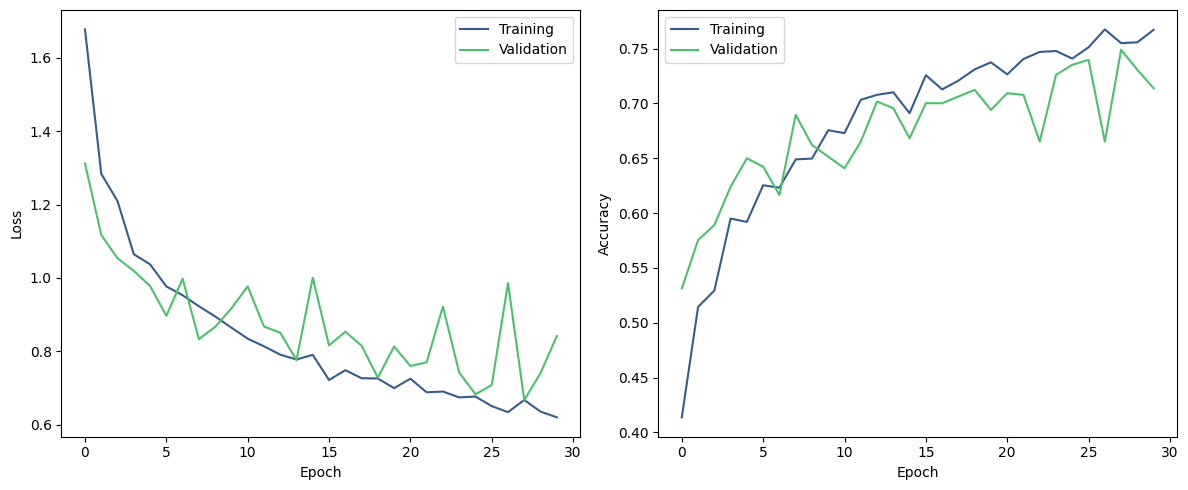

In [40]:
#Print and save accuracy plots
model25_accuracy_loss_plots = plot_training_history(history28_df)
model25_accuracy_loss_plots.savefig('model25_accuracy_loss_plots.png')

In [41]:
#Print metrics
metrics_model25 = print_final_metrics(history28_df)

Final Training Accuracy: 76.71%
Final Validation Accuracy: 71.39%
Final Training Loss: 0.6200
Final Validation Loss: 0.8415


In [42]:
#Evalute model on test set
y_pred, y_pred_cat = evaluate_model(model25, x_test, y_test_cat)

12/12 [==============================] - 1s 113ms/step - loss: 0.7769 - accuracy: 0.7068
Overall Accuracy: 70.68%
12/12 [==============================] - 2s 128ms/step


              precision    recall  f1-score   support

           0       0.82      0.80      0.81        50
           1       0.69      0.84      0.76        91
           2       0.59      0.69      0.64        68
           3       0.69      0.90      0.78        70
           4       0.91      0.37      0.53        86

    accuracy                           0.71       365
   macro avg       0.74      0.72      0.70       365
weighted avg       0.74      0.71      0.69       365



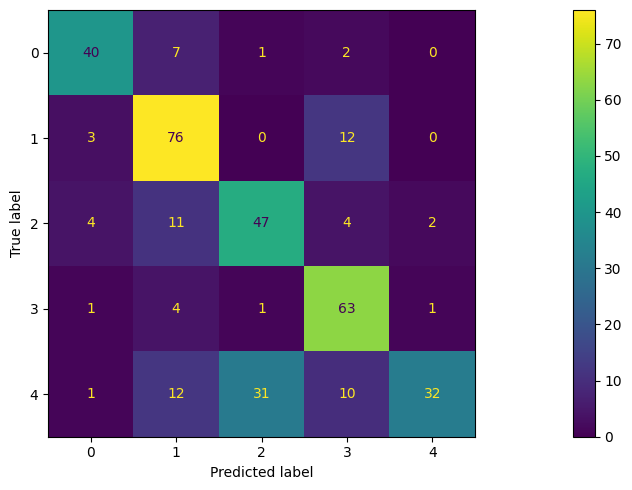

In [43]:
#Print and save confusion matrix
confusion_matrix_model25 = plot_confusion_matrix_report(y_test_cat, y_pred_cat)
confusion_matrix_model25.savefig('confusion_matrix_model25.png')

Overfitting, reduced classification performance and reduced accuracy.

*Summary of activation function*

ReLU is superior to SelU and eLU, with increased performance (accuracy) and better classification.

*Dropout of 0.5 with batch normalisation and l1/l2 0.001, stride (2,2), max pooling and relu activation*

In [44]:
#L1 and L2 regularisation 0.001 strength for both, with batch normalisation, stride (2,2) and padding, kernel size (3, 3), max pooling, dropout 0.5
model26 = build_cnn_model(width_npix, height_npix, num_classes, batch_norm=True, l1_reg=0.001, l2_reg=0.001, dropout_rate=0.5, conv_padding='same', pool_padding='same', conv_strides=(2, 2))

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_20 (Conv2D)          (None, 128, 128, 64)      1792      
                                                                 
 max_pooling2d_15 (MaxPoolin  (None, 64, 64, 64)       0         
 g2D)                                                            
                                                                 
 batch_normalization_24 (Bat  (None, 64, 64, 64)       256       
 chNormalization)                                                
                                                                 
 dropout_24 (Dropout)        (None, 64, 64, 64)        0         
                                                                 
 conv2d_21 (Conv2D)          (None, 32, 32, 128)       73856     
                                                                 
 max_pooling2d_16 (MaxPoolin  (None, 16, 16, 128)     

In [45]:
#Train the model for 30 epochs and batch size 32
batch_size = 32
history29 = model26.fit(train_datagen.flow(x_train, y_train_cat,
batch_size = batch_size,
subset = "training"),
epochs = 30, validation_data =
train_datagen.flow(x_train, y_train_cat,
batch_size = batch_size,
subset = "validation"))

Epoch 1/30
83/83 [==============================] - 70s 809ms/step - loss: 1.8226 - accuracy: 0.3381 - val_loss: 1.2509 - val_accuracy: 0.4916
Epoch 2/30
83/83 [==============================] - 67s 801ms/step - loss: 1.5271 - accuracy: 0.4335 - val_loss: 1.2218 - val_accuracy: 0.4779
Epoch 3/30
83/83 [==============================] - 70s 835ms/step - loss: 1.3723 - accuracy: 0.4719 - val_loss: 1.1944 - val_accuracy: 0.4871
Epoch 4/30
83/83 [==============================] - 68s 816ms/step - loss: 1.2665 - accuracy: 0.4992 - val_loss: 1.0749 - val_accuracy: 0.5769
Epoch 5/30
83/83 [==============================] - 72s 864ms/step - loss: 1.2487 - accuracy: 0.5038 - val_loss: 1.0528 - val_accuracy: 0.5677
Epoch 6/30
83/83 [==============================] - 69s 831ms/step - loss: 1.1684 - accuracy: 0.5220 - val_loss: 1.0625 - val_accuracy: 0.5586
Epoch 7/30
83/83 [==============================] - 67s 810ms/step - loss: 1.1304 - accuracy: 0.5429 - val_loss: 1.0779 - val_accuracy: 0.5525

In [46]:
#Convert history29 to df
history29_df = pd.DataFrame(history29.history)

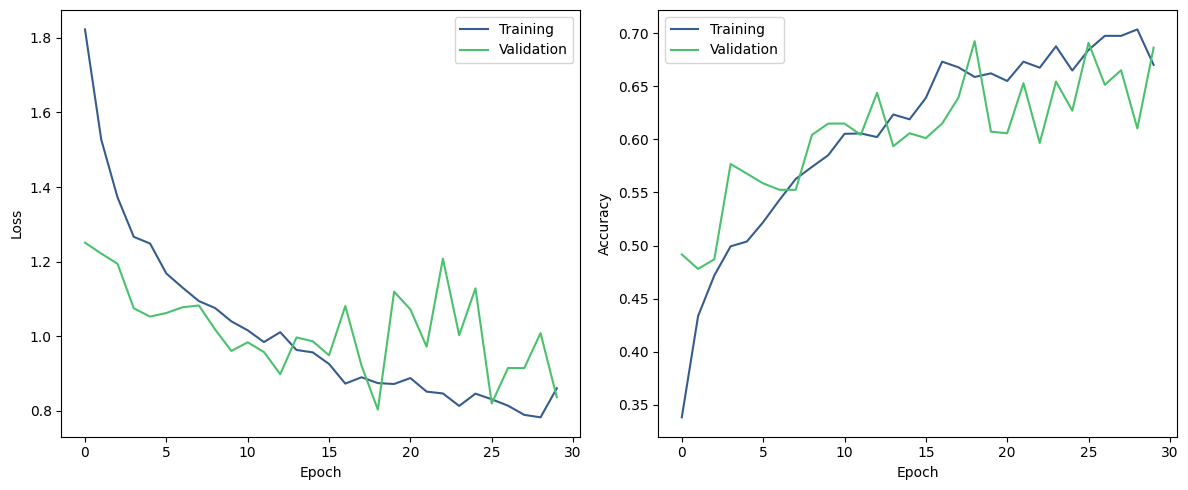

In [47]:
#Print and save accuracy plots
model26_accuracy_loss_plots = plot_training_history(history29_df)
model26_accuracy_loss_plots.savefig('model26_accuracy_loss_plots.png')

In [48]:
#Print metrics
metrics_model26 = print_final_metrics(history29_df)

Final Training Accuracy: 67.02%
Final Validation Accuracy: 68.65%
Final Training Loss: 0.8607
Final Validation Loss: 0.8367


In [49]:
#Evalute model on test set
y_pred, y_pred_cat = evaluate_model(model26, x_test, y_test_cat)

12/12 [==============================] - 1s 97ms/step - loss: 0.7899 - accuracy: 0.6712
Overall Accuracy: 67.12%
12/12 [==============================] - 1s 96ms/step


              precision    recall  f1-score   support

           0       0.88      0.60      0.71        50
           1       0.56      0.85      0.67        91
           2       0.62      0.46      0.53        68
           3       0.73      0.89      0.80        70
           4       0.78      0.52      0.62        86

    accuracy                           0.67       365
   macro avg       0.71      0.66      0.67       365
weighted avg       0.70      0.67      0.66       365



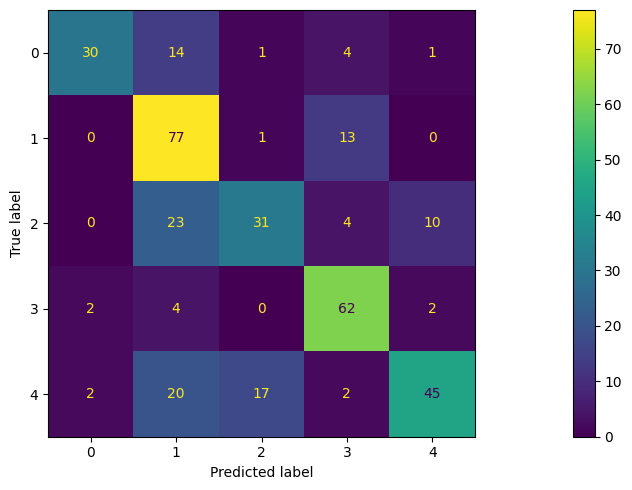

In [50]:
#Print and save confusion matrix
confusion_matrix_model26 = plot_confusion_matrix_report(y_test_cat, y_pred_cat)
confusion_matrix_model26.savefig('confusion_matrix_model26.png')

Reduced accuracy, slight overfitting, poorer classification performance, particularly for 4 and 2.

*Dropout 0.5 summary*

Reduced accuracy and classification for increasing dropout to 0.5 from 0.3. 0.3 still optimal dropout.

*Change batch normalisation momentum to 0.95*

In [51]:
#L1 and L2 regularisation 0.001 strength for both, with batch normalisation, stride (2,2) and padding, kernel size (3, 3), max pooling, dropout 0.3, momentum 0.95
model27 = build_cnn_model(width_npix, height_npix, num_classes, batch_norm=True, momentum=0.95, l1_reg=0.001, l2_reg=0.001, conv_padding='same', pool_padding='same', conv_strides=(2, 2))

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_25 (Conv2D)          (None, 128, 128, 64)      1792      
                                                                 
 max_pooling2d_20 (MaxPoolin  (None, 64, 64, 64)       0         
 g2D)                                                            
                                                                 
 batch_normalization_30 (Bat  (None, 64, 64, 64)       256       
 chNormalization)                                                
                                                                 
 dropout_30 (Dropout)        (None, 64, 64, 64)        0         
                                                                 
 conv2d_26 (Conv2D)          (None, 32, 32, 128)       73856     
                                                                 
 max_pooling2d_21 (MaxPoolin  (None, 16, 16, 128)     

In [52]:
#Train the model for 30 epochs and batch size 32
batch_size = 32
history30 = model27.fit(train_datagen.flow(x_train, y_train_cat,
batch_size = batch_size,
subset = "training"),
epochs = 30, validation_data =
train_datagen.flow(x_train, y_train_cat,
batch_size = batch_size,
subset = "validation"))

Epoch 1/30
83/83 [==============================] - 74s 866ms/step - loss: 1.6914 - accuracy: 0.4145 - val_loss: 2.4703 - val_accuracy: 0.2801
Epoch 2/30
83/83 [==============================] - 69s 833ms/step - loss: 1.3290 - accuracy: 0.5011 - val_loss: 1.0950 - val_accuracy: 0.5358
Epoch 3/30
83/83 [==============================] - 78s 935ms/step - loss: 1.2214 - accuracy: 0.5350 - val_loss: 1.0844 - val_accuracy: 0.5571
Epoch 4/30
83/83 [==============================] - 72s 861ms/step - loss: 1.1194 - accuracy: 0.5650 - val_loss: 1.0433 - val_accuracy: 0.6012
Epoch 5/30
83/83 [==============================] - 70s 841ms/step - loss: 1.0752 - accuracy: 0.5817 - val_loss: 0.9606 - val_accuracy: 0.6317
Epoch 6/30
83/83 [==============================] - 69s 832ms/step - loss: 0.9875 - accuracy: 0.6140 - val_loss: 1.1349 - val_accuracy: 0.5693
Epoch 7/30
83/83 [==============================] - 65s 784ms/step - loss: 0.9310 - accuracy: 0.6379 - val_loss: 1.1544 - val_accuracy: 0.5936

In [53]:
#Convert history30 to df
history30_df = pd.DataFrame(history30.history)

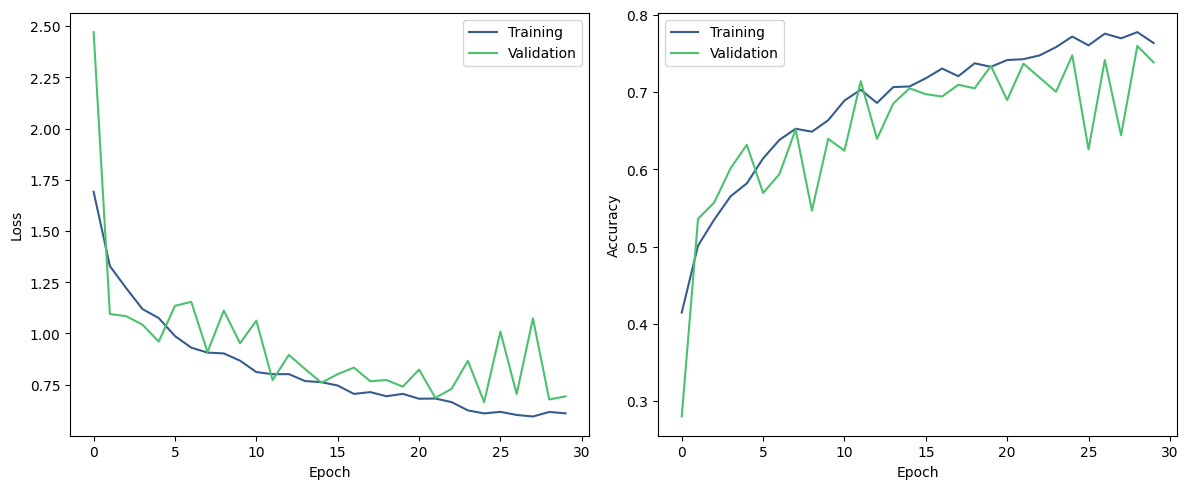

In [54]:
#Print and save accuracy plots
model27_accuracy_loss_plots = plot_training_history(history30_df)
model27_accuracy_loss_plots.savefig('model27_accuracy_loss_plots.png')

In [55]:
#Print metrics
metrics_model27 = print_final_metrics(history30_df)

Final Training Accuracy: 76.33%
Final Validation Accuracy: 73.82%
Final Training Loss: 0.6105
Final Validation Loss: 0.6933


In [56]:
#Evalute model on test set
y_pred, y_pred_cat = evaluate_model(model27, x_test, y_test_cat)

12/12 [==============================] - 1s 113ms/step - loss: 0.7038 - accuracy: 0.7123
Overall Accuracy: 71.23%
12/12 [==============================] - 1s 104ms/step


              precision    recall  f1-score   support

           0       0.86      0.64      0.74        50
           1       0.79      0.84      0.81        91
           2       0.57      0.43      0.49        68
           3       0.88      0.76      0.82        70
           4       0.58      0.81      0.68        86

    accuracy                           0.71       365
   macro avg       0.74      0.69      0.71       365
weighted avg       0.73      0.71      0.71       365



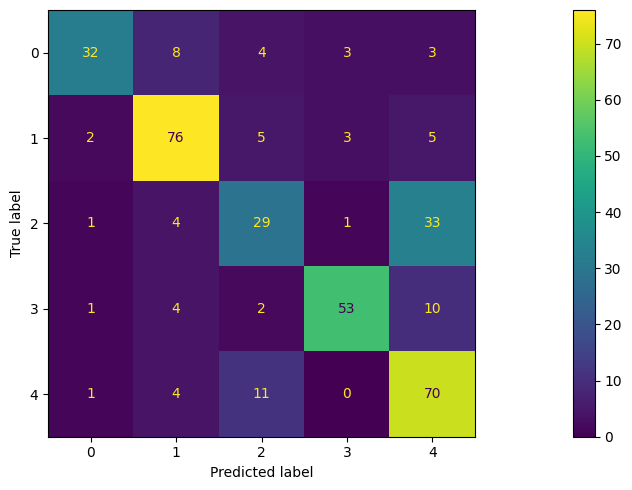

In [57]:
#Print and save confusion matrix
confusion_matrix_model27 = plot_confusion_matrix_report(y_test_cat, y_pred_cat)
confusion_matrix_model27.savefig('confusion_matrix_model27.png')

Some overfitting, slightly lower accuracy, poor classification of 2 in particular (lower recall, precision and f1 score).

*Summary of increasing momentum to 0.95 for batch normalisation*

Momentum of 0.9 appears to have improved classification performance over 0.95.

*Increase epochs*

Play with epochs to ensure allowing training to achieve maximum loss, but make sure not running for too long where see overfitting. 

Also going to play with l1/l2 reg and batch normalisation in combination with and without, one or the other, with different strides to try and increase accuracy further.

In [80]:
#L1 and L2 regularisation 0.001 strength for both, with batch normalisation, stride (2,2) and padding, kernel size (3, 3), max pooling, dropout 0.3, momentum 0.9
model28 = build_cnn_model(width_npix, height_npix, num_classes, batch_norm=True, l1_reg=0.001, l2_reg=0.001, conv_padding='same', pool_padding='same', conv_strides=(2, 2))

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_45 (Conv2D)          (None, 128, 128, 64)      1792      
                                                                 
 max_pooling2d_40 (MaxPoolin  (None, 64, 64, 64)       0         
 g2D)                                                            
                                                                 
 batch_normalization_48 (Bat  (None, 64, 64, 64)       256       
 chNormalization)                                                
                                                                 
 dropout_54 (Dropout)        (None, 64, 64, 64)        0         
                                                                 
 conv2d_46 (Conv2D)          (None, 32, 32, 128)       73856     
                                                                 
 max_pooling2d_41 (MaxPoolin  (None, 16, 16, 128)     

In [81]:
#Train the model for 60 epochs and batch size 32
batch_size = 32
history31 = model28.fit(train_datagen.flow(x_train, y_train_cat,
batch_size = batch_size,
subset = "training"),
epochs = 60, validation_data =
train_datagen.flow(x_train, y_train_cat,
batch_size = batch_size,
subset = "validation"))

Epoch 1/60
83/83 [==============================] - 93s 1s/step - loss: 1.7430 - accuracy: 0.4027 - val_loss: 1.2024 - val_accuracy: 0.5236
Epoch 2/60
83/83 [==============================] - 74s 882ms/step - loss: 1.4146 - accuracy: 0.4871 - val_loss: 1.1867 - val_accuracy: 0.5312
Epoch 3/60
83/83 [==============================] - 93s 1s/step - loss: 1.1823 - accuracy: 0.5433 - val_loss: 0.9562 - val_accuracy: 0.6347
Epoch 4/60
83/83 [==============================] - 85s 1s/step - loss: 1.1209 - accuracy: 0.5676 - val_loss: 1.0571 - val_accuracy: 0.5753
Epoch 5/60
83/83 [==============================] - 67s 804ms/step - loss: 1.0658 - accuracy: 0.5779 - val_loss: 1.1120 - val_accuracy: 0.5830
Epoch 6/60
83/83 [==============================] - 67s 802ms/step - loss: 0.9635 - accuracy: 0.6235 - val_loss: 0.8968 - val_accuracy: 0.6484
Epoch 7/60
83/83 [==============================] - 67s 806ms/step - loss: 0.9496 - accuracy: 0.6410 - val_loss: 0.8743 - val_accuracy: 0.6682
Epoch 8/

83/83 [==============================] - 62s 746ms/step - loss: 0.4543 - accuracy: 0.8343 - val_loss: 0.5555 - val_accuracy: 0.8082
Epoch 59/60
83/83 [==============================] - 64s 765ms/step - loss: 0.4208 - accuracy: 0.8461 - val_loss: 0.6201 - val_accuracy: 0.7686
Epoch 60/60
83/83 [==============================] - 61s 734ms/step - loss: 0.4370 - accuracy: 0.8400 - val_loss: 0.5967 - val_accuracy: 0.7930


In [82]:
#Convert history31 to df
history31_df = pd.DataFrame(history31.history)

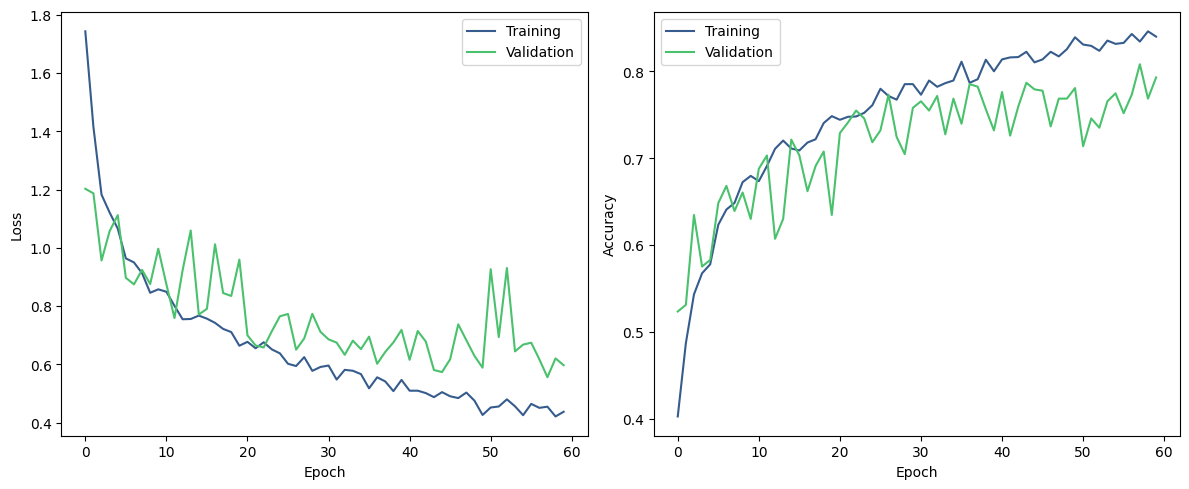

In [83]:
#Print and save accuracy plots
model28_accuracy_loss_plots = plot_training_history(history31_df)
model28_accuracy_loss_plots.savefig('model28_accuracy_loss_plots.png')

In [84]:
#Print metrics
metrics_model28 = print_final_metrics(history31_df)

Final Training Accuracy: 84.00%
Final Validation Accuracy: 79.30%
Final Training Loss: 0.4370
Final Validation Loss: 0.5967


In [85]:
#Evalute model on test set
y_pred, y_pred_cat = evaluate_model(model28, x_test, y_test_cat)

12/12 [==============================] - 1s 99ms/step - loss: 0.5463 - accuracy: 0.8027
Overall Accuracy: 80.27%
12/12 [==============================] - 1s 91ms/step


              precision    recall  f1-score   support

           0       0.77      0.86      0.81        50
           1       0.81      0.88      0.84        91
           2       0.72      0.76      0.74        68
           3       0.82      0.91      0.86        70
           4       0.90      0.63      0.74        86

    accuracy                           0.80       365
   macro avg       0.80      0.81      0.80       365
weighted avg       0.81      0.80      0.80       365



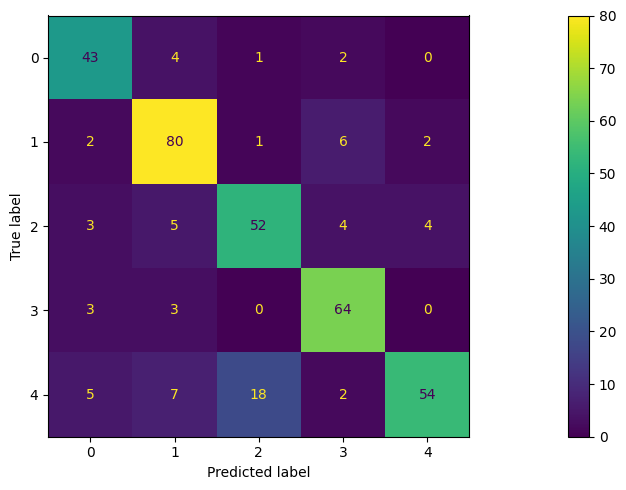

In [86]:
#Print and save confusion matrix
confusion_matrix_model28 = plot_confusion_matrix_report(y_test_cat, y_pred_cat)
confusion_matrix_model28.savefig('confusion_matrix_model28.png')

Overfitting but good accuracy, misclassifying 4 for 2 (lower recall for 4).

In [87]:
#Adam is 0.001 (default), no L1 and L2, without batch normalisation, dropout 0.3, stride (2,2) and padding
model29 = build_cnn_model(width_npix, height_npix, num_classes, conv_padding='same', pool_padding='same', conv_strides=(2, 2))

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_50 (Conv2D)          (None, 128, 128, 64)      1792      
                                                                 
 max_pooling2d_45 (MaxPoolin  (None, 64, 64, 64)       0         
 g2D)                                                            
                                                                 
 dropout_60 (Dropout)        (None, 64, 64, 64)        0         
                                                                 
 conv2d_51 (Conv2D)          (None, 32, 32, 128)       73856     
                                                                 
 max_pooling2d_46 (MaxPoolin  (None, 16, 16, 128)      0         
 g2D)                                                            
                                                                 
 dropout_61 (Dropout)        (None, 16, 16, 128)     

In [88]:
#Train the model for 60 epochs and batch size 32
batch_size = 32
history32 = model29.fit(train_datagen.flow(x_train, y_train_cat,
batch_size = batch_size,
subset = "training"),
epochs = 60, validation_data =
train_datagen.flow(x_train, y_train_cat,
batch_size = batch_size,
subset = "validation"))

Epoch 1/60
83/83 [==============================] - 66s 779ms/step - loss: 1.5112 - accuracy: 0.3271 - val_loss: 1.2399 - val_accuracy: 0.4749
Epoch 2/60
83/83 [==============================] - 63s 758ms/step - loss: 1.2318 - accuracy: 0.4517 - val_loss: 1.1615 - val_accuracy: 0.4444
Epoch 3/60
83/83 [==============================] - 63s 753ms/step - loss: 1.1475 - accuracy: 0.5061 - val_loss: 1.1024 - val_accuracy: 0.5312
Epoch 4/60
83/83 [==============================] - 63s 755ms/step - loss: 1.0900 - accuracy: 0.5361 - val_loss: 1.1954 - val_accuracy: 0.4597
Epoch 5/60
83/83 [==============================] - 65s 782ms/step - loss: 1.0721 - accuracy: 0.5646 - val_loss: 1.0123 - val_accuracy: 0.5860
Epoch 6/60
83/83 [==============================] - 63s 758ms/step - loss: 1.0160 - accuracy: 0.5779 - val_loss: 0.9736 - val_accuracy: 0.5921
Epoch 7/60
83/83 [==============================] - 63s 752ms/step - loss: 0.9985 - accuracy: 0.5999 - val_loss: 0.9084 - val_accuracy: 0.6362

83/83 [==============================] - 61s 738ms/step - loss: 0.5276 - accuracy: 0.8055 - val_loss: 0.5913 - val_accuracy: 0.7717
Epoch 59/60
83/83 [==============================] - 64s 767ms/step - loss: 0.4723 - accuracy: 0.8229 - val_loss: 0.6436 - val_accuracy: 0.7626
Epoch 60/60
83/83 [==============================] - 62s 739ms/step - loss: 0.4638 - accuracy: 0.8321 - val_loss: 0.6296 - val_accuracy: 0.7763


In [89]:
#Convert history32 to df
history32_df = pd.DataFrame(history32.history)

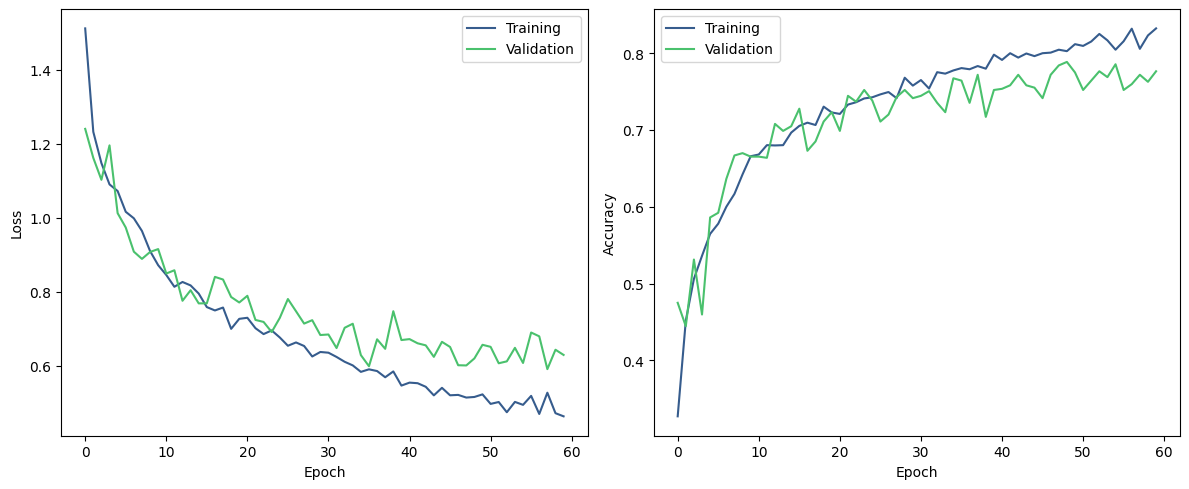

In [90]:
#Print and save accuracy plots
model29_accuracy_loss_plots = plot_training_history(history32_df)
model29_accuracy_loss_plots.savefig('model29_accuracy_loss_plots.png')

In [91]:
#Print metrics
metrics_model29 = print_final_metrics(history32_df)

Final Training Accuracy: 83.21%
Final Validation Accuracy: 77.63%
Final Training Loss: 0.4638
Final Validation Loss: 0.6296


In [92]:
#Evalute model on test set
y_pred, y_pred_cat = evaluate_model(model29, x_test, y_test_cat)

12/12 [==============================] - 1s 99ms/step - loss: 0.6509 - accuracy: 0.7863
Overall Accuracy: 78.63%
12/12 [==============================] - 1s 92ms/step


              precision    recall  f1-score   support

           0       0.80      0.86      0.83        50
           1       0.81      0.91      0.86        91
           2       0.65      0.78      0.71        68
           3       0.88      0.74      0.81        70
           4       0.82      0.65      0.73        86

    accuracy                           0.79       365
   macro avg       0.79      0.79      0.79       365
weighted avg       0.79      0.79      0.79       365



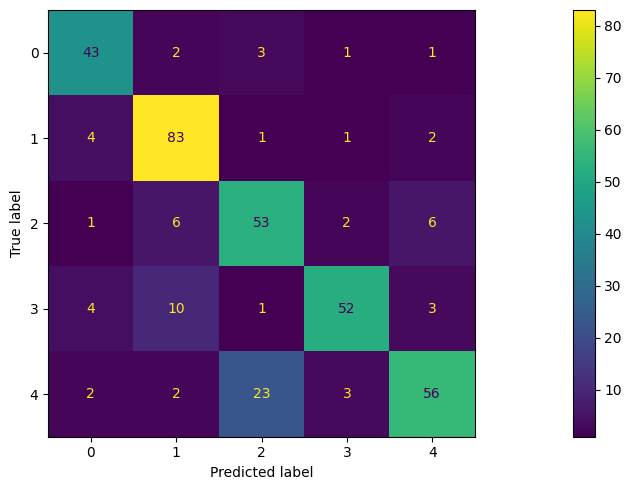

In [93]:
#Print and save confusion matrix
confusion_matrix_model29 = plot_confusion_matrix_report(y_test_cat, y_pred_cat)
confusion_matrix_model29.savefig('confusion_matrix_model29.png')

Overfitting, good accuracy, classification good for all but 4 and slightly off for 3.

In [96]:
#Adam is 0.001 (default), no L1 and L2, without batch normalisation, dropout 0.3, stride (3,3) and padding
model30 = build_cnn_model(width_npix, height_npix, num_classes, conv_padding='same', pool_padding='same', conv_strides=(3, 3))

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_60 (Conv2D)          (None, 86, 86, 64)        1792      
                                                                 
 max_pooling2d_55 (MaxPoolin  (None, 43, 43, 64)       0         
 g2D)                                                            
                                                                 
 dropout_72 (Dropout)        (None, 43, 43, 64)        0         
                                                                 
 conv2d_61 (Conv2D)          (None, 15, 15, 128)       73856     
                                                                 
 max_pooling2d_56 (MaxPoolin  (None, 8, 8, 128)        0         
 g2D)                                                            
                                                                 
 dropout_73 (Dropout)        (None, 8, 8, 128)       

In [97]:
#Train the model for 60 epochs and batch size 32
batch_size = 32
history33 = model30.fit(train_datagen.flow(x_train, y_train_cat,
batch_size = batch_size,
subset = "training"),
epochs = 60, validation_data =
train_datagen.flow(x_train, y_train_cat,
batch_size = batch_size,
subset = "validation"))

Epoch 1/60
83/83 [==============================] - 52s 607ms/step - loss: 1.5573 - accuracy: 0.2542 - val_loss: 1.4211 - val_accuracy: 0.3318
Epoch 2/60
83/83 [==============================] - 50s 600ms/step - loss: 1.3516 - accuracy: 0.4016 - val_loss: 1.2082 - val_accuracy: 0.4825
Epoch 3/60
83/83 [==============================] - 50s 605ms/step - loss: 1.1835 - accuracy: 0.4932 - val_loss: 1.1020 - val_accuracy: 0.5495
Epoch 4/60
83/83 [==============================] - 50s 600ms/step - loss: 1.1170 - accuracy: 0.5289 - val_loss: 1.0300 - val_accuracy: 0.5723
Epoch 5/60
83/83 [==============================] - 50s 602ms/step - loss: 1.0585 - accuracy: 0.5653 - val_loss: 0.9988 - val_accuracy: 0.5738
Epoch 6/60
83/83 [==============================] - 50s 602ms/step - loss: 1.0238 - accuracy: 0.5817 - val_loss: 0.9760 - val_accuracy: 0.5951
Epoch 7/60
83/83 [==============================] - 50s 604ms/step - loss: 0.9917 - accuracy: 0.6011 - val_loss: 0.9591 - val_accuracy: 0.6119

Epoch 58/60
83/83 [==============================] - 47s 562ms/step - loss: 0.6575 - accuracy: 0.7549 - val_loss: 0.7013 - val_accuracy: 0.7428
Epoch 59/60
83/83 [==============================] - 48s 576ms/step - loss: 0.6640 - accuracy: 0.7481 - val_loss: 0.7175 - val_accuracy: 0.7275
Epoch 60/60
83/83 [==============================] - 48s 576ms/step - loss: 0.6478 - accuracy: 0.7614 - val_loss: 0.6927 - val_accuracy: 0.7367


In [98]:
#Convert history33 to df
history33_df = pd.DataFrame(history33.history)

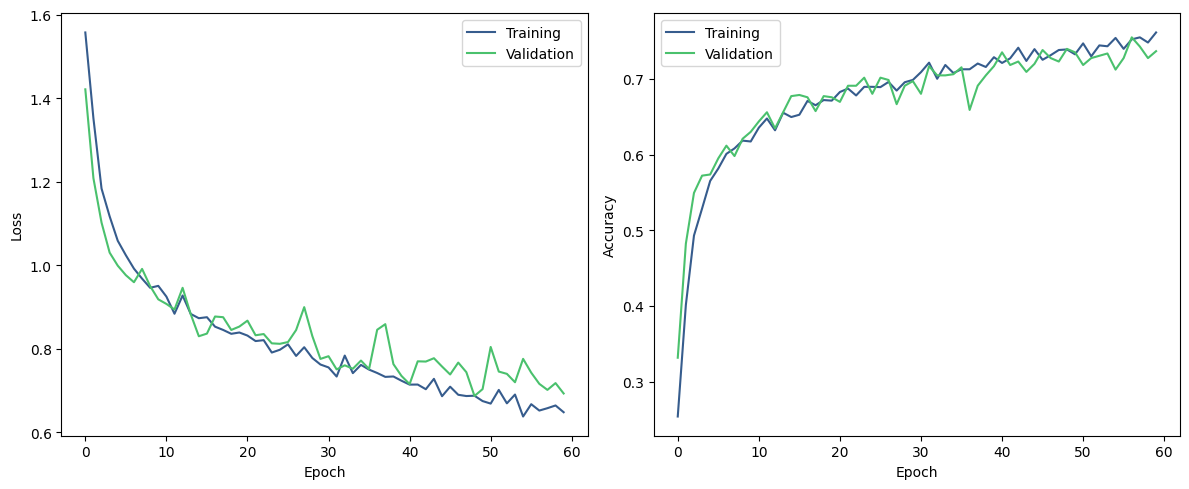

In [99]:
#Print and save accuracy plots
model30_accuracy_loss_plots = plot_training_history(history33_df)
model30_accuracy_loss_plots.savefig('model30_accuracy_loss_plots.png')

In [100]:
#Print metrics
metrics_model30 = print_final_metrics(history33_df)

Final Training Accuracy: 76.14%
Final Validation Accuracy: 73.67%
Final Training Loss: 0.6478
Final Validation Loss: 0.6927


In [101]:
#Evalute model on test set
y_pred, y_pred_cat = evaluate_model(model30, x_test, y_test_cat)

12/12 [==============================] - 1s 52ms/step - loss: 0.6337 - accuracy: 0.7753
Overall Accuracy: 77.53%
12/12 [==============================] - 1s 47ms/step


              precision    recall  f1-score   support

           0       0.80      0.88      0.84        50
           1       0.77      0.84      0.80        91
           2       0.70      0.69      0.70        68
           3       0.85      0.81      0.83        70
           4       0.77      0.69      0.72        86

    accuracy                           0.78       365
   macro avg       0.78      0.78      0.78       365
weighted avg       0.78      0.78      0.77       365



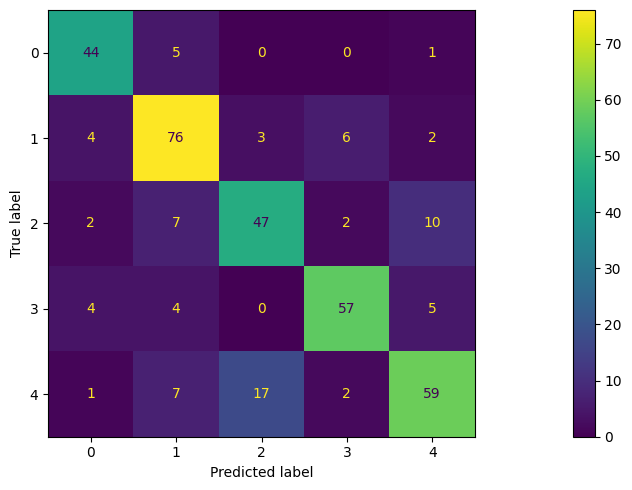

In [102]:
#Print and save confusion matrix
confusion_matrix_model30 = plot_confusion_matrix_report(y_test_cat, y_pred_cat)
confusion_matrix_model30.savefig('confusion_matrix_model30.png')

Very little overfitting at later epochs, good accuracy, classification pretty good, 4 and 2 mistaken for each other but not significantly.

*Try adding batch normalisation without L1 and L2 regularisation*

In [104]:
#Adam is 0.001 (default), no L1 and L2, with batch normalisation, dropout 0.3, stride (3,3) and padding
model31 = build_cnn_model(width_npix, height_npix, num_classes, batch_norm=True, conv_padding='same', pool_padding='same', conv_strides=(3, 3))

Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_65 (Conv2D)          (None, 86, 86, 64)        1792      
                                                                 
 max_pooling2d_60 (MaxPoolin  (None, 43, 43, 64)       0         
 g2D)                                                            
                                                                 
 batch_normalization_54 (Bat  (None, 43, 43, 64)       256       
 chNormalization)                                                
                                                                 
 dropout_78 (Dropout)        (None, 43, 43, 64)        0         
                                                                 
 conv2d_66 (Conv2D)          (None, 15, 15, 128)       73856     
                                                                 
 max_pooling2d_61 (MaxPoolin  (None, 8, 8, 128)      

In [105]:
#Train the model for 40 epochs and batch size 32
batch_size = 32
history34 = model31.fit(train_datagen.flow(x_train, y_train_cat,
batch_size = batch_size,
subset = "training"),
epochs = 40, validation_data =
train_datagen.flow(x_train, y_train_cat,
batch_size = batch_size,
subset = "validation"))

Epoch 1/40
83/83 [==============================] - 52s 601ms/step - loss: 1.7686 - accuracy: 0.3655 - val_loss: 1.3003 - val_accuracy: 0.4825
Epoch 2/40
83/83 [==============================] - 50s 597ms/step - loss: 1.4084 - accuracy: 0.4593 - val_loss: 1.1952 - val_accuracy: 0.5388
Epoch 3/40
83/83 [==============================] - 48s 577ms/step - loss: 1.2804 - accuracy: 0.5065 - val_loss: 1.0760 - val_accuracy: 0.5632
Epoch 4/40
83/83 [==============================] - 48s 579ms/step - loss: 1.1925 - accuracy: 0.5289 - val_loss: 1.0580 - val_accuracy: 0.5799
Epoch 5/40
83/83 [==============================] - 48s 578ms/step - loss: 1.1511 - accuracy: 0.5490 - val_loss: 1.0107 - val_accuracy: 0.5936
Epoch 6/40
83/83 [==============================] - 48s 579ms/step - loss: 1.0757 - accuracy: 0.5665 - val_loss: 0.9706 - val_accuracy: 0.6149
Epoch 7/40
83/83 [==============================] - 48s 573ms/step - loss: 1.0419 - accuracy: 0.5935 - val_loss: 0.9323 - val_accuracy: 0.6393

In [106]:
#Convert history34 to df
history34_df = pd.DataFrame(history34.history)

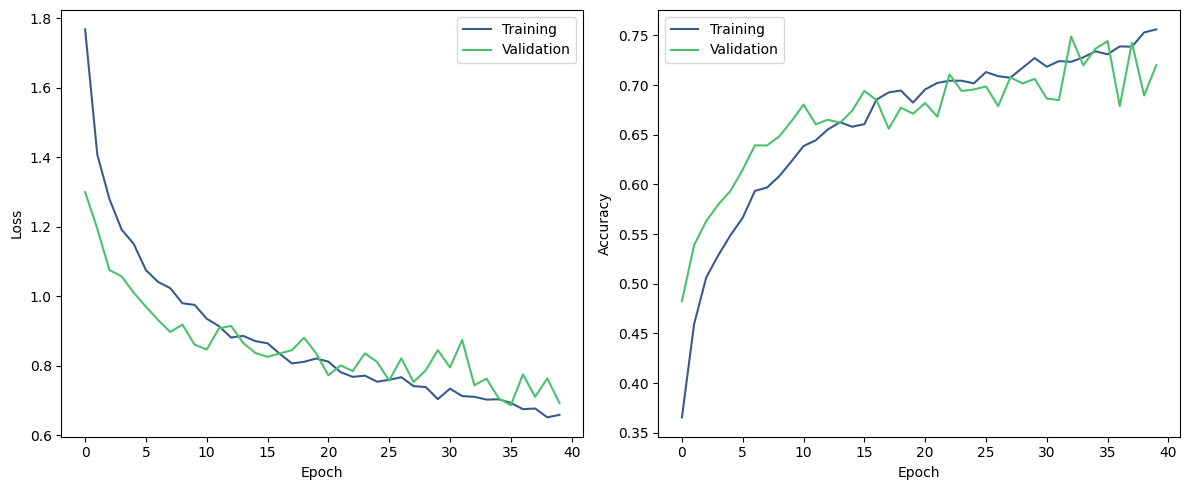

In [107]:
#Print and save accuracy plots
model31_accuracy_loss_plots = plot_training_history(history34_df)
model31_accuracy_loss_plots.savefig('model31_accuracy_loss_plots.png')

In [108]:
#Print metrics
metrics_model31 = print_final_metrics(history34_df)

Final Training Accuracy: 75.61%
Final Validation Accuracy: 71.99%
Final Training Loss: 0.6593
Final Validation Loss: 0.6933


In [109]:
#Evalute model on test set
y_pred, y_pred_cat = evaluate_model(model31, x_test, y_test_cat)

12/12 [==============================] - 1s 60ms/step - loss: 0.6504 - accuracy: 0.7479
Overall Accuracy: 74.79%
12/12 [==============================] - 1s 54ms/step


              precision    recall  f1-score   support

           0       0.73      0.86      0.79        50
           1       0.77      0.87      0.81        91
           2       0.64      0.69      0.66        68
           3       0.81      0.83      0.82        70
           4       0.81      0.53      0.64        86

    accuracy                           0.75       365
   macro avg       0.75      0.76      0.75       365
weighted avg       0.75      0.75      0.74       365



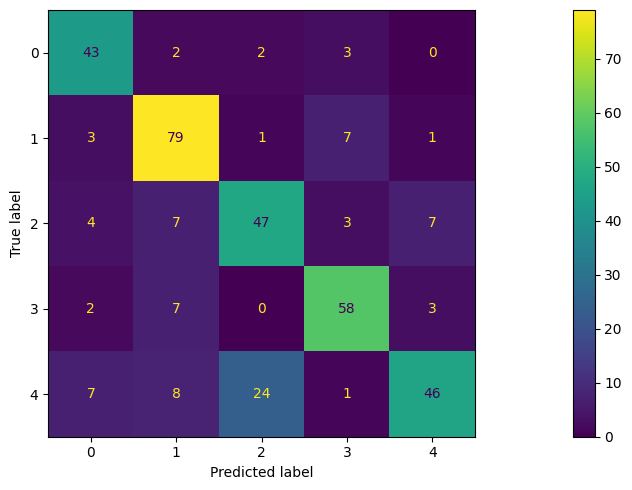

In [110]:
#Print and save confusion matrix
confusion_matrix_model31 = plot_confusion_matrix_report(y_test_cat, y_pred_cat)
confusion_matrix_model31.savefig('confusion_matrix_model31.png')

Slight overfitting, accuracy ok, misclassification more pronounced for 4 (confused for 2 and lesser extent 0 and 1).

In [17]:
#Adam is 0.001 (default), no L1 and L2, without batch normalisation, dropout 0.3, stride (3,3) and padding
model32 = build_cnn_model(width_npix, height_npix, num_classes, conv_padding='same', pool_padding='same', conv_strides=(3, 3))

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 86, 86, 64)        1792      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 43, 43, 64)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 43, 43, 64)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 15, 15, 128)       73856     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 8, 8, 128)        0         
 2D)                                                             
                                                                 
 dropout_1 (Dropout)         (None, 8, 8, 128)         0

In [119]:
#Train the model for 50 epochs and batch size 32
batch_size = 32
history35 = model32.fit(train_datagen.flow(x_train, y_train_cat,
batch_size = batch_size,
subset = "training"),
epochs = 50, validation_data =
train_datagen.flow(x_train, y_train_cat,
batch_size = batch_size,
subset = "validation"))

Epoch 1/50
83/83 [==============================] - 53s 628ms/step - loss: 1.5902 - accuracy: 0.2561 - val_loss: 1.4422 - val_accuracy: 0.4231
Epoch 2/50
83/83 [==============================] - 52s 626ms/step - loss: 1.2880 - accuracy: 0.4259 - val_loss: 1.1959 - val_accuracy: 0.4673
Epoch 3/50
83/83 [==============================] - 52s 627ms/step - loss: 1.1605 - accuracy: 0.4996 - val_loss: 1.1075 - val_accuracy: 0.5358
Epoch 4/50
83/83 [==============================] - 49s 590ms/step - loss: 1.1253 - accuracy: 0.5201 - val_loss: 1.0877 - val_accuracy: 0.5114
Epoch 5/50
83/83 [==============================] - 52s 622ms/step - loss: 1.0992 - accuracy: 0.5395 - val_loss: 1.0536 - val_accuracy: 0.5601
Epoch 6/50
83/83 [==============================] - 54s 648ms/step - loss: 1.0701 - accuracy: 0.5597 - val_loss: 1.0133 - val_accuracy: 0.5693
Epoch 7/50
83/83 [==============================] - 54s 648ms/step - loss: 1.0295 - accuracy: 0.5722 - val_loss: 0.9896 - val_accuracy: 0.6012

In [120]:
#Convert history35 to df
history35_df = pd.DataFrame(history35.history)

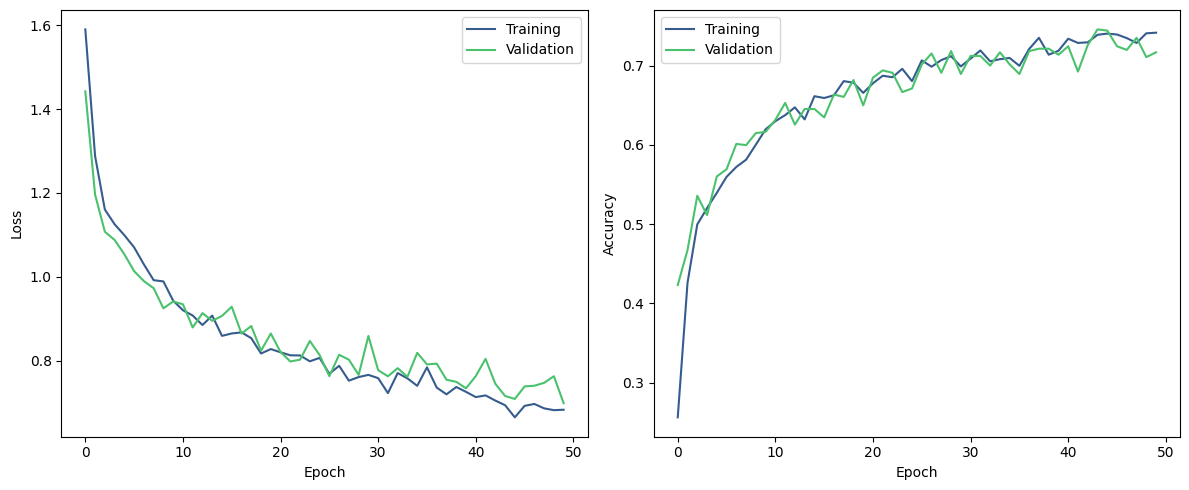

In [121]:
#Print and save accuracy plots
model32_accuracy_loss_plots = plot_training_history(history35_df)
model32_accuracy_loss_plots.savefig('model32_accuracy_loss_plots.png')

In [122]:
#Print metrics
metrics_model32 = print_final_metrics(history35_df)

Final Training Accuracy: 74.16%
Final Validation Accuracy: 71.69%
Final Training Loss: 0.6827
Final Validation Loss: 0.6983


In [123]:
#Evalute model on test set
y_pred, y_pred_cat = evaluate_model(model32, x_test, y_test_cat)

12/12 [==============================] - 1s 83ms/step - loss: 0.7090 - accuracy: 0.7479
Overall Accuracy: 74.79%
12/12 [==============================] - 1s 76ms/step


              precision    recall  f1-score   support

           0       0.77      0.86      0.81        50
           1       0.74      0.89      0.81        91
           2       0.61      0.74      0.67        68
           3       0.84      0.83      0.83        70
           4       0.84      0.48      0.61        86

    accuracy                           0.75       365
   macro avg       0.76      0.76      0.75       365
weighted avg       0.76      0.75      0.74       365



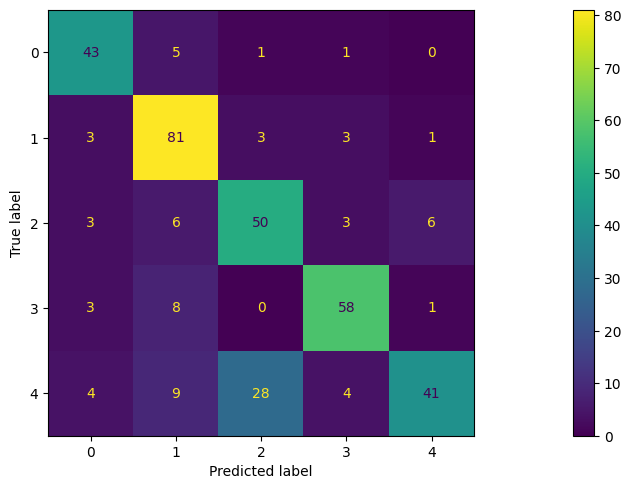

In [124]:
#Print and save confusion matrix
confusion_matrix_model32 = plot_confusion_matrix_report(y_test_cat, y_pred_cat)
confusion_matrix_model32.savefig('confusion_matrix_model32.png')

This model looks good with very small amount of overfitting over 50 epochs, no batch normalisation or l1/l2, stride (3,3), dropout 0.3, kernel size (3,3), adam opmisier 0.001, ReLU activation. Test accuracy of 75%. Misclassifying 4 (tulips) with 2 (rose) primarily.

This is essentially the same model as model 20 (run for 30 epochs) which saw no overfitting, same slight miscclassification of tulip and rose, but reduced accuracy of 67%.

Model 30 is the same again but run for 60 epochs, again saw slight overfitting with rose and tulip and tulip and rose misclassified in equal measure, increased accuracy of 78%.

Definitely a trade-off with overfitting and accuracy and classification performance!

Re-try stride of (2,2)

In [24]:
#Adam is 0.001 (default), no L1 and L2, with batch normalisation, dropout 0.3, stride (2,2) and padding
model33 = build_cnn_model(width_npix, height_npix, num_classes, batch_norm=True, conv_padding='same', pool_padding='same', conv_strides=(2, 2))

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_5 (Conv2D)           (None, 128, 128, 64)      1792      
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 64, 64, 64)       0         
 2D)                                                             
                                                                 
 batch_normalization_6 (Batc  (None, 64, 64, 64)       256       
 hNormalization)                                                 
                                                                 
 dropout_6 (Dropout)         (None, 64, 64, 64)        0         
                                                                 
 conv2d_6 (Conv2D)           (None, 32, 32, 128)       73856     
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 16, 16, 128)     

In [25]:
#Train the model for 50 epochs and batch size 32
batch_size = 32
history36 = model33.fit(train_datagen.flow(x_train, y_train_cat,
batch_size = batch_size,
subset = "training"),
epochs = 40, validation_data =
train_datagen.flow(x_train, y_train_cat,
batch_size = batch_size,
subset = "validation"))

Epoch 1/40
83/83 [==============================] - 84s 976ms/step - loss: 1.6844 - accuracy: 0.4088 - val_loss: 1.2907 - val_accuracy: 0.4962
Epoch 2/40
83/83 [==============================] - 64s 765ms/step - loss: 1.3513 - accuracy: 0.4985 - val_loss: 1.1080 - val_accuracy: 0.5556
Epoch 3/40
83/83 [==============================] - 68s 818ms/step - loss: 1.2063 - accuracy: 0.5403 - val_loss: 0.9768 - val_accuracy: 0.6256
Epoch 4/40
83/83 [==============================] - 66s 793ms/step - loss: 1.1492 - accuracy: 0.5524 - val_loss: 0.9835 - val_accuracy: 0.6073
Epoch 5/40
83/83 [==============================] - 64s 773ms/step - loss: 1.0575 - accuracy: 0.5946 - val_loss: 0.9414 - val_accuracy: 0.6332
Epoch 6/40
83/83 [==============================] - 68s 814ms/step - loss: 1.0188 - accuracy: 0.5938 - val_loss: 0.9399 - val_accuracy: 0.6377
Epoch 7/40
83/83 [==============================] - 68s 821ms/step - loss: 0.9748 - accuracy: 0.6223 - val_loss: 0.8789 - val_accuracy: 0.6499

In [26]:
#Convert history36 to df
history36_df = pd.DataFrame(history36.history)

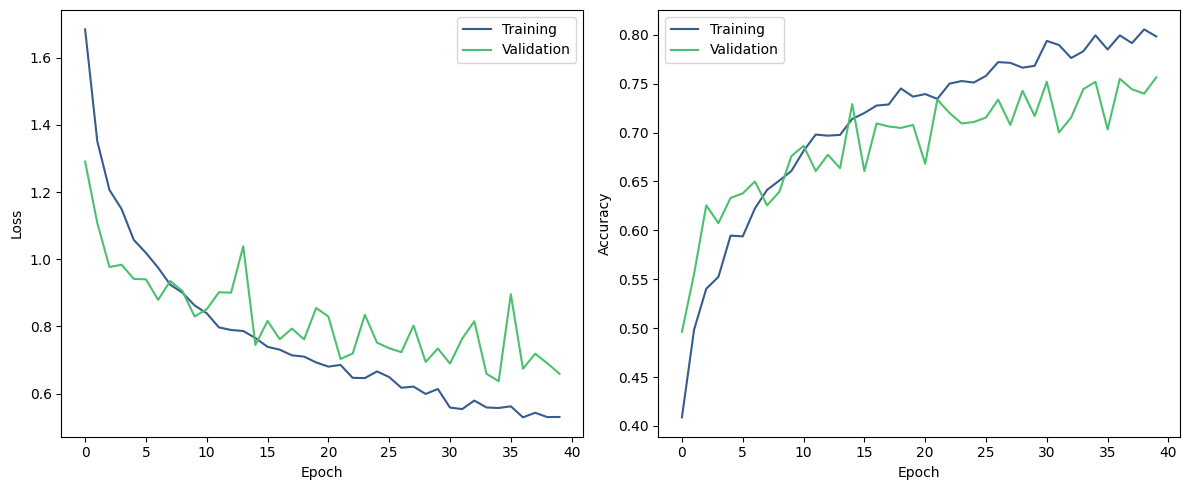

In [27]:
#Print and save accuracy plots
model33_accuracy_loss_plots = plot_training_history(history36_df)
model33_accuracy_loss_plots.savefig('model33_accuracy_loss_plots.png')

In [28]:
#Print metrics
metrics_model33 = print_final_metrics(history36_df)

Final Training Accuracy: 79.83%
Final Validation Accuracy: 75.65%
Final Training Loss: 0.5301
Final Validation Loss: 0.6589


In [29]:
#Evalute model on test set
y_pred, y_pred_cat = evaluate_model(model33, x_test, y_test_cat)

12/12 [==============================] - 2s 127ms/step - loss: 0.6003 - accuracy: 0.7781
Overall Accuracy: 77.81%
12/12 [==============================] - 2s 105ms/step


              precision    recall  f1-score   support

           0       0.82      0.80      0.81        50
           1       0.70      0.92      0.80        91
           2       0.71      0.69      0.70        68
           3       0.86      0.86      0.86        70
           4       0.88      0.62      0.73        86

    accuracy                           0.78       365
   macro avg       0.79      0.78      0.78       365
weighted avg       0.79      0.78      0.78       365



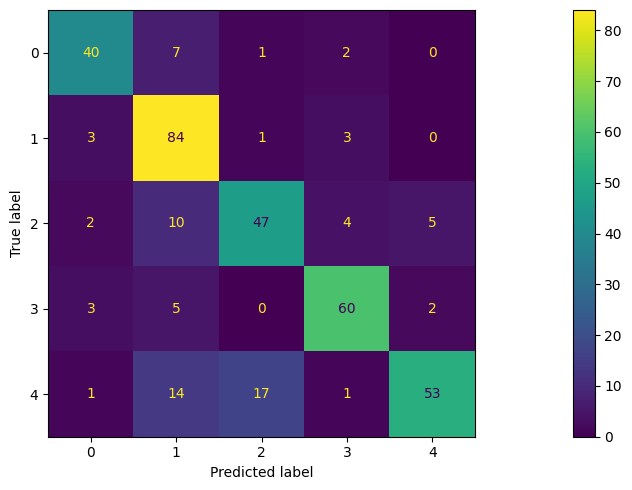

In [30]:
#Print and save confusion matrix
confusion_matrix_model33 = plot_confusion_matrix_report(y_test_cat, y_pred_cat)
confusion_matrix_model33.savefig('confusion_matrix_model33.png')

Overfitting apparent, stride (3,3) favoured.

Try L1 and L2 regularisation without batch normalisation.

In [31]:
#Adam is 0.001 (default), L1 and L2 0.001, no batch normalisation, dropout 0.3, stride (3,3) and padding
model34 = build_cnn_model(width_npix, height_npix, num_classes, l1_reg=0.001, l2_reg=0.001, conv_padding='same', pool_padding='same', conv_strides=(3, 3))

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_10 (Conv2D)          (None, 86, 86, 64)        1792      
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, 43, 43, 64)       0         
 g2D)                                                            
                                                                 
 dropout_12 (Dropout)        (None, 43, 43, 64)        0         
                                                                 
 conv2d_11 (Conv2D)          (None, 15, 15, 128)       73856     
                                                                 
 max_pooling2d_11 (MaxPoolin  (None, 8, 8, 128)        0         
 g2D)                                                            
                                                                 
 dropout_13 (Dropout)        (None, 8, 8, 128)        

In [32]:
#Train the model for 50 epochs and batch size 32
batch_size = 32
history37 = model34.fit(train_datagen.flow(x_train, y_train_cat,
batch_size = batch_size,
subset = "training"),
epochs = 40, validation_data =
train_datagen.flow(x_train, y_train_cat,
batch_size = batch_size,
subset = "validation"))

Epoch 1/40
83/83 [==============================] - 55s 642ms/step - loss: 1.5861 - accuracy: 0.2538 - val_loss: 1.5112 - val_accuracy: 0.2648
Epoch 2/40
83/83 [==============================] - 50s 602ms/step - loss: 1.3668 - accuracy: 0.3803 - val_loss: 1.2596 - val_accuracy: 0.4323
Epoch 3/40
83/83 [==============================] - 55s 659ms/step - loss: 1.1906 - accuracy: 0.4783 - val_loss: 1.1301 - val_accuracy: 0.5084
Epoch 4/40
83/83 [==============================] - 50s 602ms/step - loss: 1.1559 - accuracy: 0.5015 - val_loss: 1.0639 - val_accuracy: 0.5464
Epoch 5/40
83/83 [==============================] - 50s 599ms/step - loss: 1.0894 - accuracy: 0.5407 - val_loss: 1.0619 - val_accuracy: 0.5495
Epoch 6/40
83/83 [==============================] - 49s 588ms/step - loss: 1.0669 - accuracy: 0.5608 - val_loss: 1.0145 - val_accuracy: 0.5769
Epoch 7/40
83/83 [==============================] - 48s 578ms/step - loss: 1.0352 - accuracy: 0.5665 - val_loss: 1.0521 - val_accuracy: 0.5830

In [33]:
#Convert history37 to df
history37_df = pd.DataFrame(history37.history)

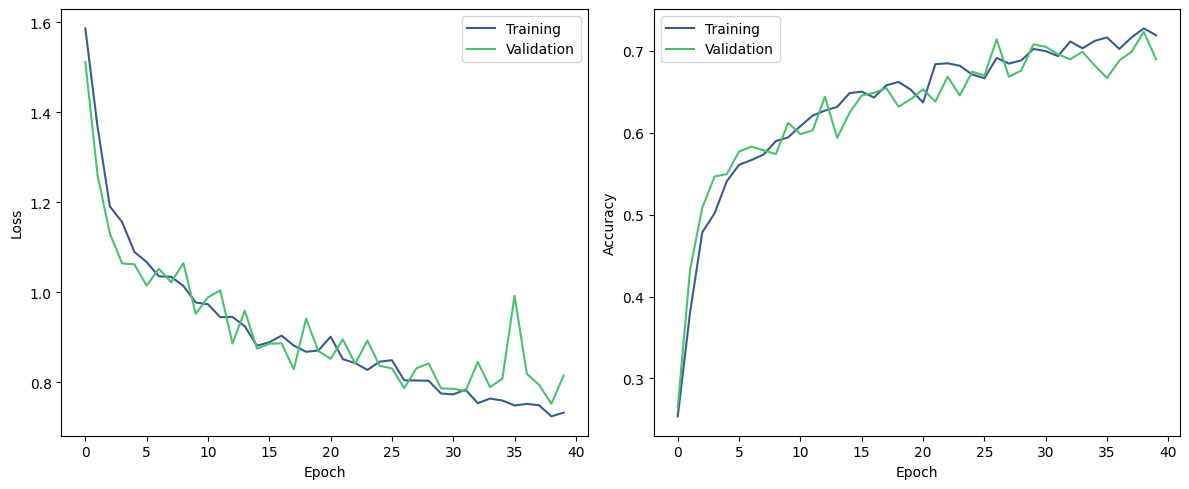

In [34]:
#Print and save accuracy plots
model34_accuracy_loss_plots = plot_training_history(history37_df)
model34_accuracy_loss_plots.savefig('model34_accuracy_loss_plots.png')

In [35]:
#Print metrics
metrics_model34 = print_final_metrics(history37_df)

Final Training Accuracy: 71.88%
Final Validation Accuracy: 68.95%
Final Training Loss: 0.7323
Final Validation Loss: 0.8148


In [36]:
#Evalute model on test set
y_pred, y_pred_cat = evaluate_model(model34, x_test, y_test_cat)

12/12 [==============================] - 1s 59ms/step - loss: 0.7488 - accuracy: 0.7425
Overall Accuracy: 74.25%
12/12 [==============================] - 1s 45ms/step


              precision    recall  f1-score   support

           0       0.84      0.82      0.83        50
           1       0.66      0.93      0.77        91
           2       0.66      0.62      0.64        68
           3       0.85      0.86      0.85        70
           4       0.83      0.50      0.62        86

    accuracy                           0.74       365
   macro avg       0.76      0.75      0.74       365
weighted avg       0.76      0.74      0.73       365



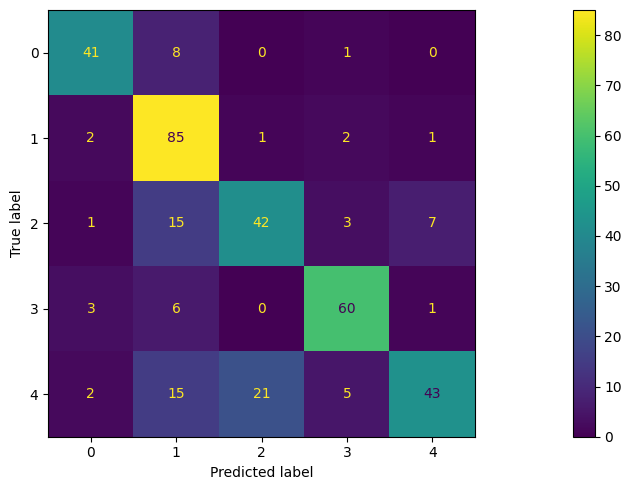

In [37]:
#Print and save confusion matrix
confusion_matrix_model34 = plot_confusion_matrix_report(y_test_cat, y_pred_cat)
confusion_matrix_model34.savefig('confusion_matrix_model34.png')

Accuracy looks pretty good but classification performace is reduced compared to no batch normalisation and l1 and l2 regularisation. Particularly misclassifying 2 and 4. Low precision for 1 and 2.

*Try different number of epochs for model 32*

In [39]:
#Train the model for 70 epochs and batch size 32
batch_size = 32
history38 = model32.fit(train_datagen.flow(x_train, y_train_cat,
batch_size = batch_size,
subset = "training"),
epochs = 70, validation_data =
train_datagen.flow(x_train, y_train_cat,
batch_size = batch_size,
subset = "validation"))

Epoch 1/70
83/83 [==============================] - 61s 718ms/step - loss: 1.5658 - accuracy: 0.2561 - val_loss: 1.4650 - val_accuracy: 0.3151
Epoch 2/70
83/83 [==============================] - 51s 617ms/step - loss: 1.3720 - accuracy: 0.3777 - val_loss: 1.3195 - val_accuracy: 0.4749
Epoch 3/70
83/83 [==============================] - 51s 619ms/step - loss: 1.1874 - accuracy: 0.4897 - val_loss: 1.1059 - val_accuracy: 0.5571
Epoch 4/70
83/83 [==============================] - 48s 583ms/step - loss: 1.1374 - accuracy: 0.5125 - val_loss: 1.0844 - val_accuracy: 0.5373
Epoch 5/70
83/83 [==============================] - 46s 550ms/step - loss: 1.0999 - accuracy: 0.5384 - val_loss: 1.0488 - val_accuracy: 0.5419
Epoch 6/70
83/83 [==============================] - 47s 571ms/step - loss: 1.0716 - accuracy: 0.5479 - val_loss: 1.0342 - val_accuracy: 0.5860
Epoch 7/70
83/83 [==============================] - 48s 574ms/step - loss: 1.0559 - accuracy: 0.5798 - val_loss: 1.0074 - val_accuracy: 0.5753

Epoch 58/70
83/83 [==============================] - 50s 606ms/step - loss: 0.6576 - accuracy: 0.7576 - val_loss: 0.7163 - val_accuracy: 0.7336
Epoch 59/70
83/83 [==============================] - 47s 569ms/step - loss: 0.6442 - accuracy: 0.7496 - val_loss: 0.6927 - val_accuracy: 0.7352
Epoch 60/70
83/83 [==============================] - 49s 585ms/step - loss: 0.6539 - accuracy: 0.7538 - val_loss: 0.7004 - val_accuracy: 0.7443
Epoch 61/70
83/83 [==============================] - 48s 579ms/step - loss: 0.6446 - accuracy: 0.7485 - val_loss: 0.6961 - val_accuracy: 0.7336
Epoch 62/70
83/83 [==============================] - 48s 574ms/step - loss: 0.6209 - accuracy: 0.7606 - val_loss: 0.7198 - val_accuracy: 0.7291
Epoch 63/70
83/83 [==============================] - 48s 574ms/step - loss: 0.6199 - accuracy: 0.7523 - val_loss: 0.7090 - val_accuracy: 0.7260
Epoch 64/70
83/83 [==============================] - 46s 556ms/step - loss: 0.6473 - accuracy: 0.7527 - val_loss: 0.7407 - val_accuracy:

In [40]:
#Convert history38 to df
history38_df = pd.DataFrame(history38.history)

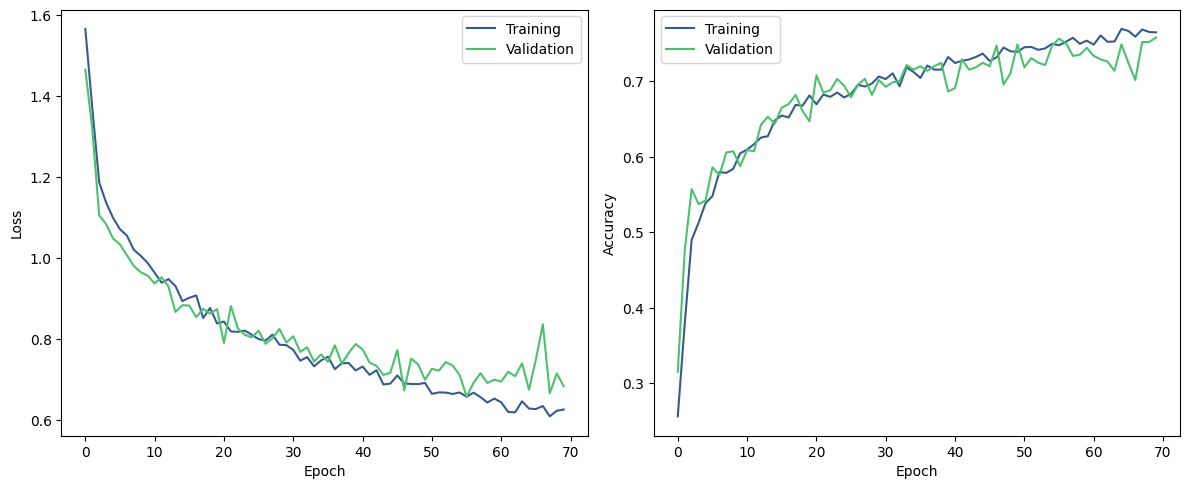

In [41]:
#Print and save accuracy plots
model32_2_accuracy_loss_plots = plot_training_history(history38_df)
model32_2_accuracy_loss_plots.savefig('model32_2_accuracy_loss_plots.png')

In [42]:
#Print metrics
metrics_model32_2 = print_final_metrics(history38_df)

Final Training Accuracy: 76.48%
Final Validation Accuracy: 75.80%
Final Training Loss: 0.6270
Final Validation Loss: 0.6845


In [43]:
#Evalute model on test set
y_pred, y_pred_cat = evaluate_model(model32, x_test, y_test_cat)

12/12 [==============================] - 1s 60ms/step - loss: 0.6087 - accuracy: 0.7808
Overall Accuracy: 78.08%
12/12 [==============================] - 1s 45ms/step


              precision    recall  f1-score   support

           0       0.88      0.74      0.80        50
           1       0.80      0.86      0.83        91
           2       0.73      0.71      0.72        68
           3       0.77      0.91      0.84        70
           4       0.76      0.67      0.72        86

    accuracy                           0.78       365
   macro avg       0.79      0.78      0.78       365
weighted avg       0.78      0.78      0.78       365



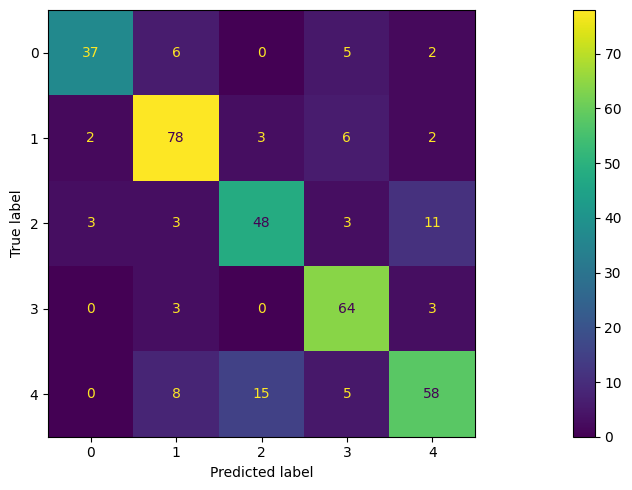

In [44]:
#Print and save confusion matrix
confusion_matrix_model32_2 = plot_confusion_matrix_report(y_test_cat, y_pred_cat)
confusion_matrix_model32_2.savefig('confusion_matrix_model32_2.png')

Slight overfitting for longer epochs, good accuracy 78%, good classification (4 confused with 2 indicated by slightly lower recall).

In [18]:
#Train the model for 40 epochs and batch size 32
batch_size = 32
history39 = model32.fit(train_datagen.flow(x_train, y_train_cat,
batch_size = batch_size,
subset = "training"),
epochs = 40, validation_data =
train_datagen.flow(x_train, y_train_cat,
batch_size = batch_size,
subset = "validation"))

Epoch 1/40
83/83 [==============================] - 50s 575ms/step - loss: 1.5929 - accuracy: 0.2470 - val_loss: 1.5967 - val_accuracy: 0.2725
Epoch 2/40
83/83 [==============================] - 47s 567ms/step - loss: 1.4616 - accuracy: 0.3207 - val_loss: 1.2158 - val_accuracy: 0.4871
Epoch 3/40
83/83 [==============================] - 47s 562ms/step - loss: 1.1984 - accuracy: 0.4688 - val_loss: 1.1134 - val_accuracy: 0.5068
Epoch 4/40
83/83 [==============================] - 47s 568ms/step - loss: 1.1407 - accuracy: 0.5000 - val_loss: 1.0525 - val_accuracy: 0.5479
Epoch 5/40
83/83 [==============================] - 46s 557ms/step - loss: 1.1264 - accuracy: 0.5217 - val_loss: 1.0974 - val_accuracy: 0.5068
Epoch 6/40
83/83 [==============================] - 51s 616ms/step - loss: 1.0905 - accuracy: 0.5399 - val_loss: 1.0246 - val_accuracy: 0.5373
Epoch 7/40
83/83 [==============================] - 50s 600ms/step - loss: 1.0359 - accuracy: 0.5722 - val_loss: 0.9736 - val_accuracy: 0.5875

In [19]:
#Convert history39 to df
history39_df = pd.DataFrame(history39.history)

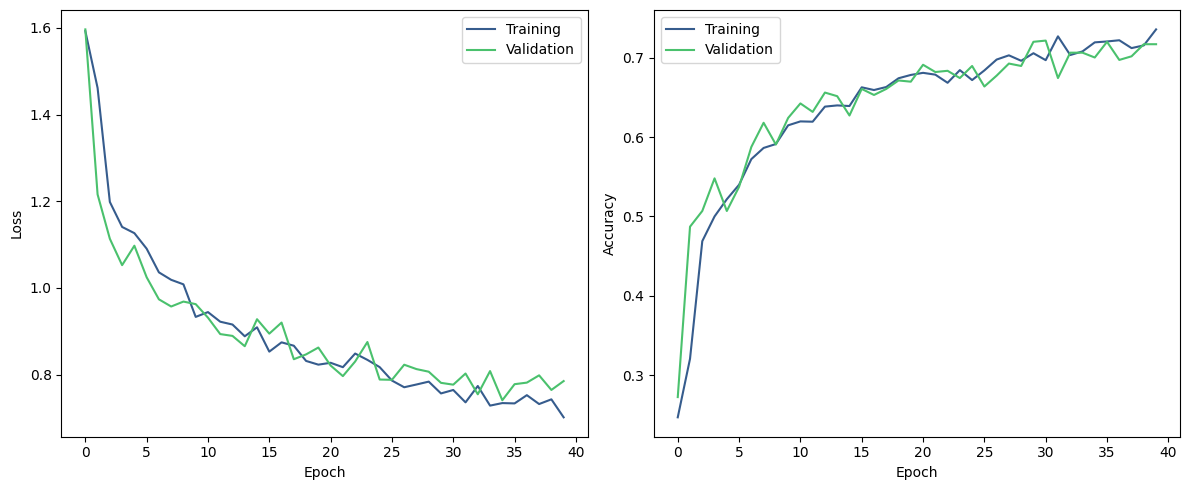

In [20]:
#Print and save accuracy plots
model32_3_accuracy_loss_plots = plot_training_history(history39_df)
model32_3_accuracy_loss_plots.savefig('model32_3_accuracy_loss_plots.png')

In [21]:
#Print metrics
metrics_model32_3 = print_final_metrics(history39_df)

Final Training Accuracy: 73.56%
Final Validation Accuracy: 71.69%
Final Training Loss: 0.7013
Final Validation Loss: 0.7850


In [22]:
#Evalute model on test set
y_pred, y_pred_cat = evaluate_model(model32, x_test, y_test_cat)

12/12 [==============================] - 1s 62ms/step - loss: 0.7034 - accuracy: 0.7370
Overall Accuracy: 73.70%
12/12 [==============================] - 1s 63ms/step


              precision    recall  f1-score   support

           0       0.74      0.78      0.76        50
           1       0.76      0.81      0.78        91
           2       0.64      0.69      0.66        68
           3       0.84      0.73      0.78        70
           4       0.73      0.67      0.70        86

    accuracy                           0.74       365
   macro avg       0.74      0.74      0.74       365
weighted avg       0.74      0.74      0.74       365



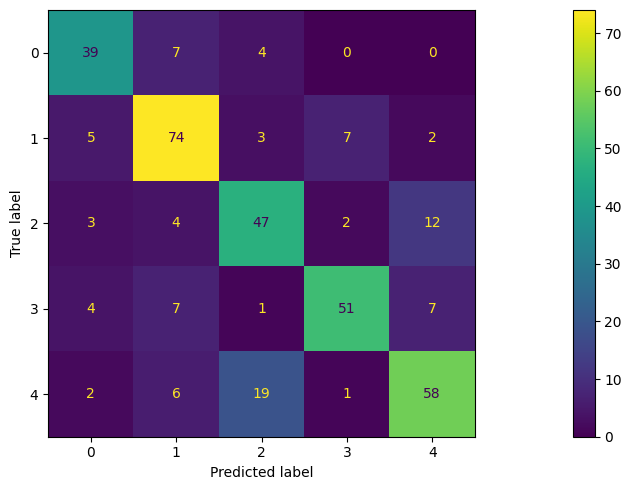

In [23]:
#Print and save confusion matrix
confusion_matrix_model32_3 = plot_confusion_matrix_report(y_test_cat, y_pred_cat)
confusion_matrix_model32_3.savefig('confusion_matrix_model32_3.png')

40 epochs no evidence of overfitting, accuracy good at 74%, classification good, usual confusion between 2 and 4!

*Summary of changing epochs with and without batch norm an/or l1 and l2, playng with stride (2,2) and (2,3)*

Model 32 with (3,3) strides, without batch normalisation and l1 and l2 shows the least overfitting and best accuracy for increased epochs. 

Model 20 was run for 30 epochs, showed no over-fitting but reduced accuracy of 67% but good classification performance.

Run at 50, 60 and 70, only very slight over-fitting occurs, accuracy increases the longer the training runs. Classification performance is good generally with any discrepancy seen for tulips misclassified with rose, maybe due to textural and colour similarities.

The best trade-off between accuracy, good classification and where the model is not overfitting will be selected.
For this reason, the best model obtained here for flower data classification is the final model 32_3 with accuracy of 74%.
This model runs for 40 epochs, batch size 32, adam optimiser 0.001, dropout 0.4, no batch normalisation or L1 and L2 regularisation, stride (3, 3) and padding, kernel size (3,3), ReLU activation.

Slightly reduced classification performance for rose and tulip.

*Misclassifications*

For the flower dataset there is a little class imbalance but nothing significant. 

Misclassifications between rose and tulip classes could be attributed to their visual similarities in shape, texture, and colour. These two flower types share certain characteristics that might make it challenging for a model to distinguish between them accurately. The model is struggling to generalise for these two classes, potentially due to high variation also that makes it difficult for the model to leanr distinctive features.

**Final model architecture**

#Visualise architecture and save to png
#pip install pydot graphviz
#from tensorflow.keras.utils import plot_model
#plot_model(model32, to_file='model32_architecture.png', show_shapes=True, show_layer_names=True)

**Future work**

1. L1 or L2 alone instead of elastic net
2. Different strenghts of elastic L1 and L2 together
3. Random search using keras tuner to determine optimal regularisation and/or hyperparameters- trade off with computation!
4. Optimise early stopping additional regularisation refining min delta to deal with noise and patience and prevent overfitting for longer epochs.
5. Determine impact of changing image size
6. Play with number of filters per layer
7. Reduce number of dropout layers, add L1 and L2 to convolutional layers in addition or instead of dense layer.
8. Alternative approaches such as transfer learning on a pre-trained model such as ResNet, or ensemble learning combining approaches such as bagging or boosting.